# Uplift Modeling


Maximizing the incremental return of your marketing campaigns

**Problem Statement** : Image your marketing team/department wanted a model that could distinguish between customers who would respond positively to a marketing campaign (Responders) and those who would respond negatively if left untreated but positively if targeted (Anti-Responders). In other words, they sought a way to maximize the incremental impact of their marketing efforts.

Uplift modeling, a magical technique, promised to unveil the true impact of marketing interventions on individual customers. It aimed not just to predict who would respond positively to a campaign, but more importantly, who would respond better if treated compared to not being treated.


In [1]:
import pandas as pd
from typing import List
from joblib import Parallel, delayed
from abc import abstractmethod
import numpy as np
import statsmodels.formula.api as smf
from causalml.inference.meta.base import BaseLearner
from causalml.inference.meta import(
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
)

from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Read the data 

We are going to follow the example The overview of the basic approaches to solving the Uplift Modeling problem presented in **scikit-uplift’s** Tutorials Section.

Data Set : I have dataset reference from  kaggle [Uplift Modeling to predict and target the right customers](https://www.kaggle.com/datasets/davinwijaya/customer-retention/)

**Datset Content**
* This dataset show customer's brief information,
* historical use of discount or BOGO(Buy One Get One) promotion,
* offer has been made, and the conversion result(buy or not).
* The conversion average value = $25




In [2]:
df_data = pd.read_csv('Datasets/uplift_data.csv')

In [3]:
df_data

recency  history  used_discount  used_bogo   zip_code  is_referral  \
0           10   142.44              1          0  Surburban            0   
1            6   329.08              1          1      Rural            1   
2            7   180.65              0          1  Surburban            1   
3            9   675.83              1          0      Rural            1   
4            2    45.34              1          0      Urban            0   
...        ...      ...            ...        ...        ...          ...   
63995       10   105.54              1          0      Urban            0   
63996        5    38.91              0          1      Urban            1   
63997        6    29.99              1          0      Urban            1   
63998        1   552.94              1          0  Surburban            1   
63999        1   472.82              0          1  Surburban            0   

            channel            offer  conversion  
0             Phone  Buy One Get One           0  
1               Web         No Offer           0  
2               Web  Buy One Get One           0  
3               Web         Discount           0  
4               Web  Buy One Get One           0  
...             ...              ...         ...  
63995           Web         Discount           0  
63996         Phone         Discount           0  
63997         Phone         Discount           0  
63998  Multichannel  Buy One Get One           0  
63999           Web         Discount           0  

[64000 rows x 9 columns]

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


The dataset looks good and we dont have any missing values 


we have the data of customers who received Discount and Buy One Get One offers and how they reacted. We also have a control group that didn’t receive anything.

Column descriptions are as follows:

* recency: months since last purchase
* history: $value of the historical purchases
* used_discount/used_bogo: indicates if the customer used a discount or buy one get one before
* zip_code: class of the zip code as Suburban/Urban/Rural
* is_referral: indicates if the customer was acquired from referral channel
* channel: channels that the customer using, Phone/Web/Multichannel
* offer: the offers sent to the customers, Discount/But One Get One/No Offer
* conversion: customer conversion(buy or not)

In [5]:
# Checking for object data
df_data.describe(include=np.object)

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


zip_code channel            offer
count       64000   64000            64000
unique          3       3                3
top     Surburban     Web  Buy One Get One
freq        28776   28217            21387

In [6]:
df_data['treatment_flg'] = 'treatment'
df_data.loc[df_data.offer == 'No Offer', 'treatment_flg'] = 'control'

In [7]:
df_data

recency  history  used_discount  used_bogo   zip_code  is_referral  \
0           10   142.44              1          0  Surburban            0   
1            6   329.08              1          1      Rural            1   
2            7   180.65              0          1  Surburban            1   
3            9   675.83              1          0      Rural            1   
4            2    45.34              1          0      Urban            0   
...        ...      ...            ...        ...        ...          ...   
63995       10   105.54              1          0      Urban            0   
63996        5    38.91              0          1      Urban            1   
63997        6    29.99              1          0      Urban            1   
63998        1   552.94              1          0  Surburban            1   
63999        1   472.82              0          1  Surburban            0   

            channel            offer  conversion treatment_flg  
0             Phone  Buy One Get One           0     treatment  
1               Web         No Offer           0       control  
2               Web  Buy One Get One           0     treatment  
3               Web         Discount           0     treatment  
4               Web  Buy One Get One           0     treatment  
...             ...              ...         ...           ...  
63995           Web         Discount           0     treatment  
63996         Phone         Discount           0     treatment  
63997         Phone         Discount           0     treatment  
63998  Multichannel  Buy One Get One           0     treatment  
63999           Web         Discount           0     treatment  

[64000 rows x 10 columns]

In [8]:
df_data['treatment_flg'].value_counts()

treatment    42694
control      21306
Name: treatment_flg, dtype: int64

The split of the treatment_flg is not balanced (approx. 66/34).

The balance of the treatment group (those exposed to a marketing treatment) and the control group (those not exposed) is crucial in uplift modeling. An imbalanced split can introduce biases and affect the model's ability to accurately assess the causal impact of the treatment. 


As we have two different kind of promotions, we split the data for each category of offer and check the split of data between treatmeant and group

In [12]:
# Split data with bogo and discount
df_model_bogo = df_data.copy().loc[df_data.offer != 'Discount'].reset_index(drop=True)
df_model_discount = df_data.copy().loc[df_data.offer != 'Buy One Get One'].reset_index(drop=True)

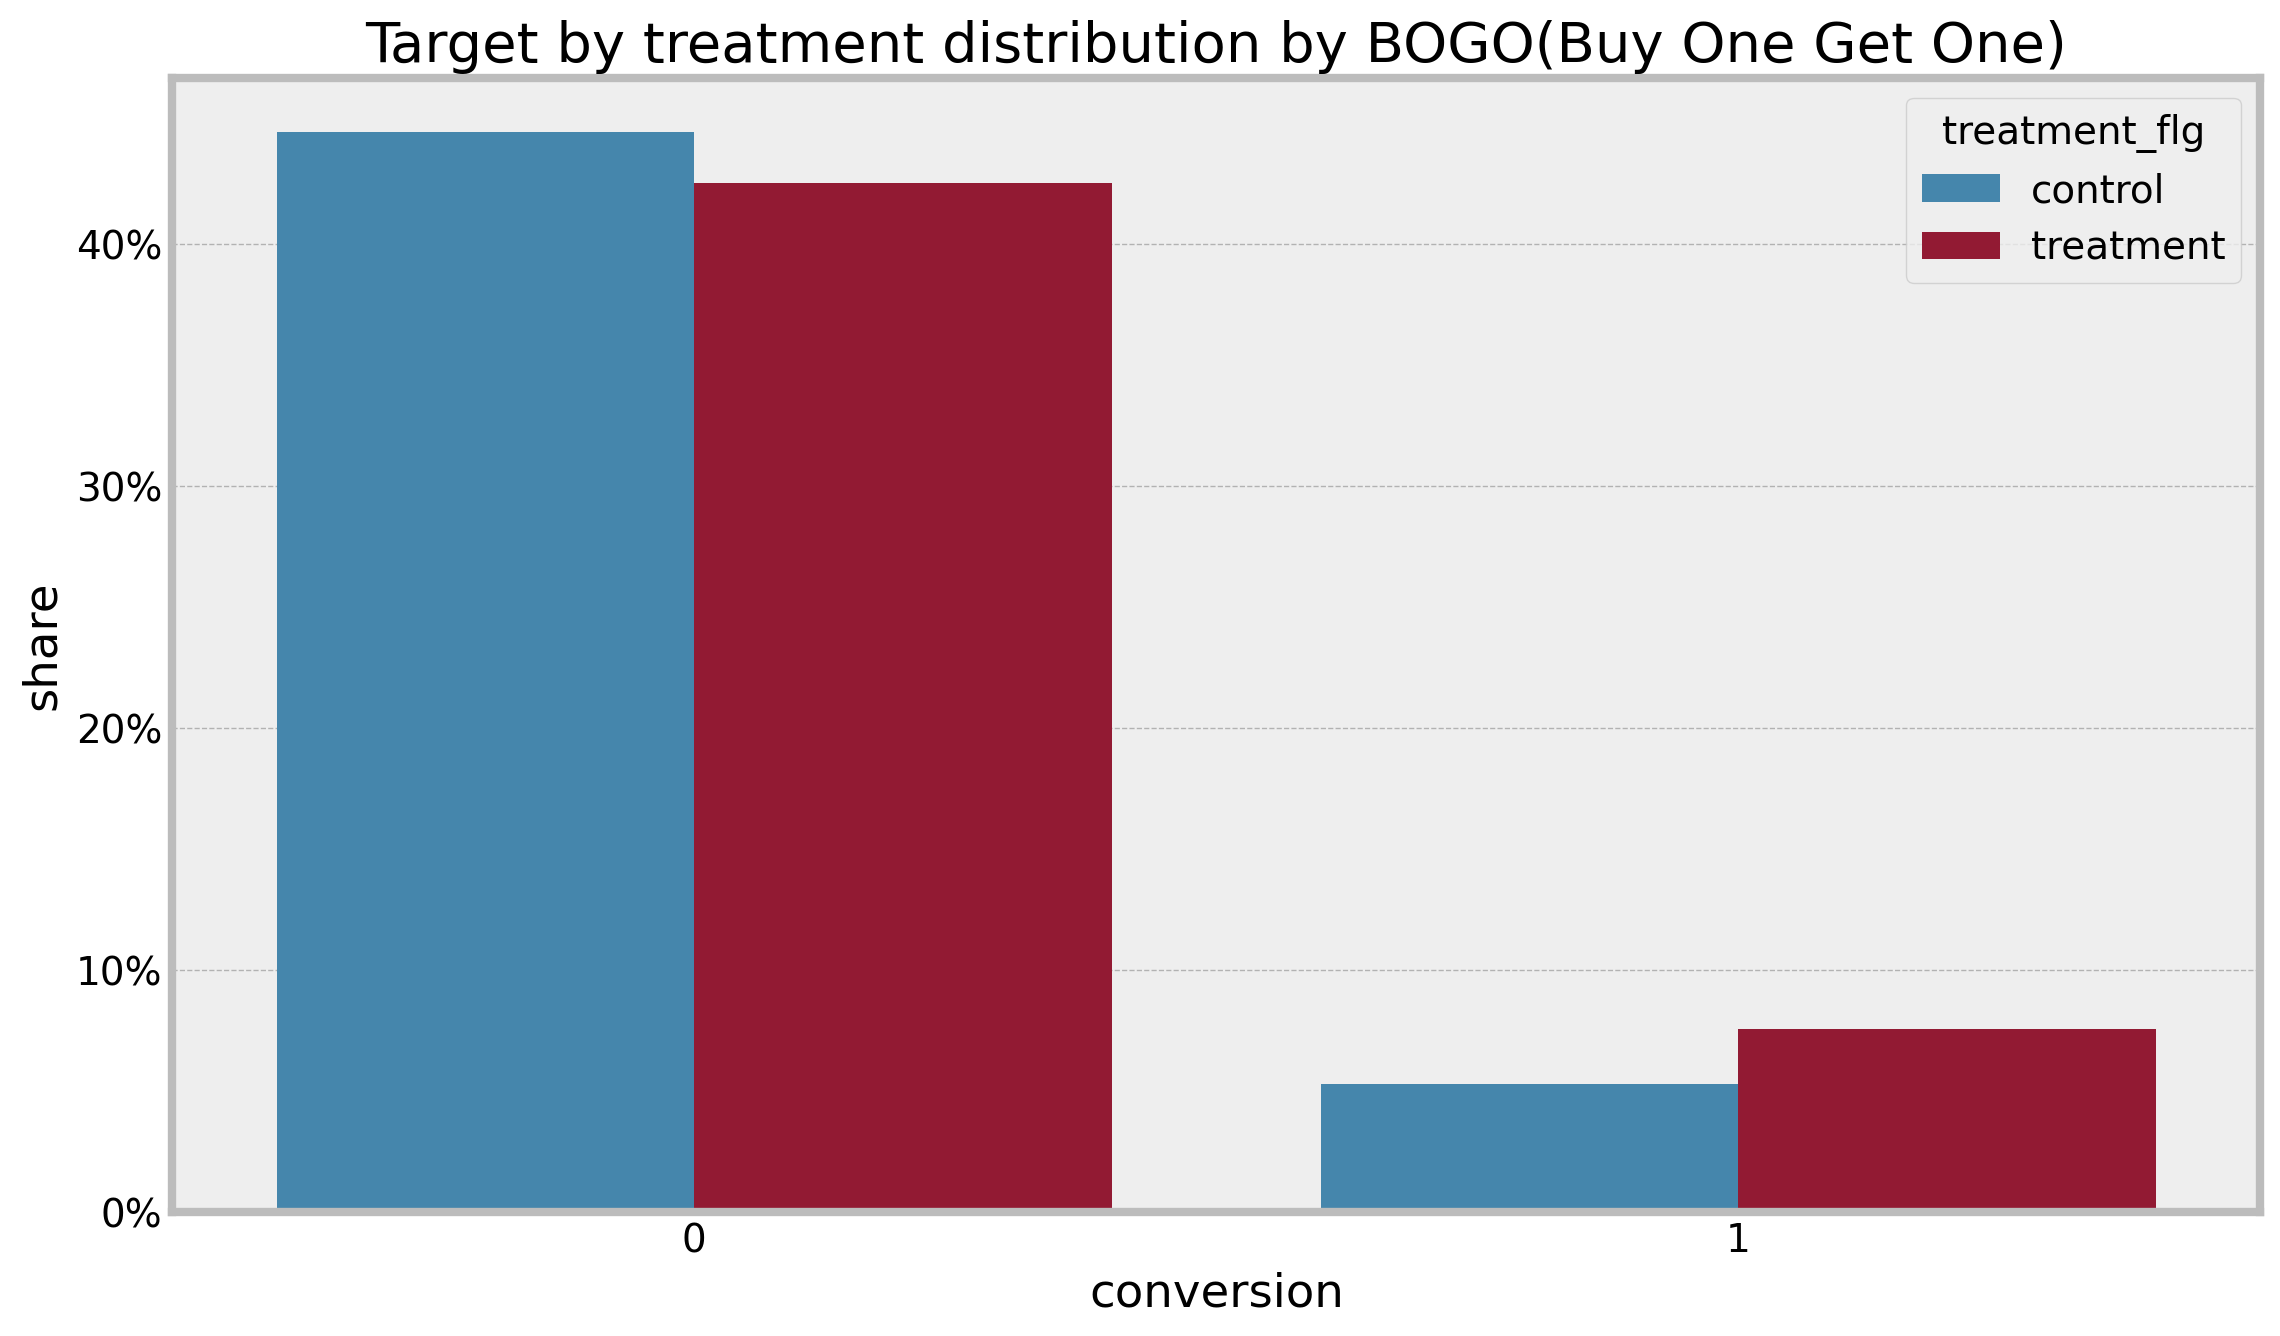

In [13]:
fig, ax = plt.subplots()

df_model_bogo \
  .groupby(["treatment_flg", "conversion"], as_index=False) \
  .size() \
  .assign(
    share=lambda x: x["size"] / x["size"].sum()
  ) \
  .pipe((sns.barplot, "data"), x="conversion", y="share", hue="treatment_flg", ax=ax)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y :.0%}"))
ax.set(title="Target by treatment distribution by BOGO(Buy One Get One)");

In [15]:
df_model_bogo['treatment_flg'].value_counts()

treatment    21387
control      21306
Name: treatment_flg, dtype: int64

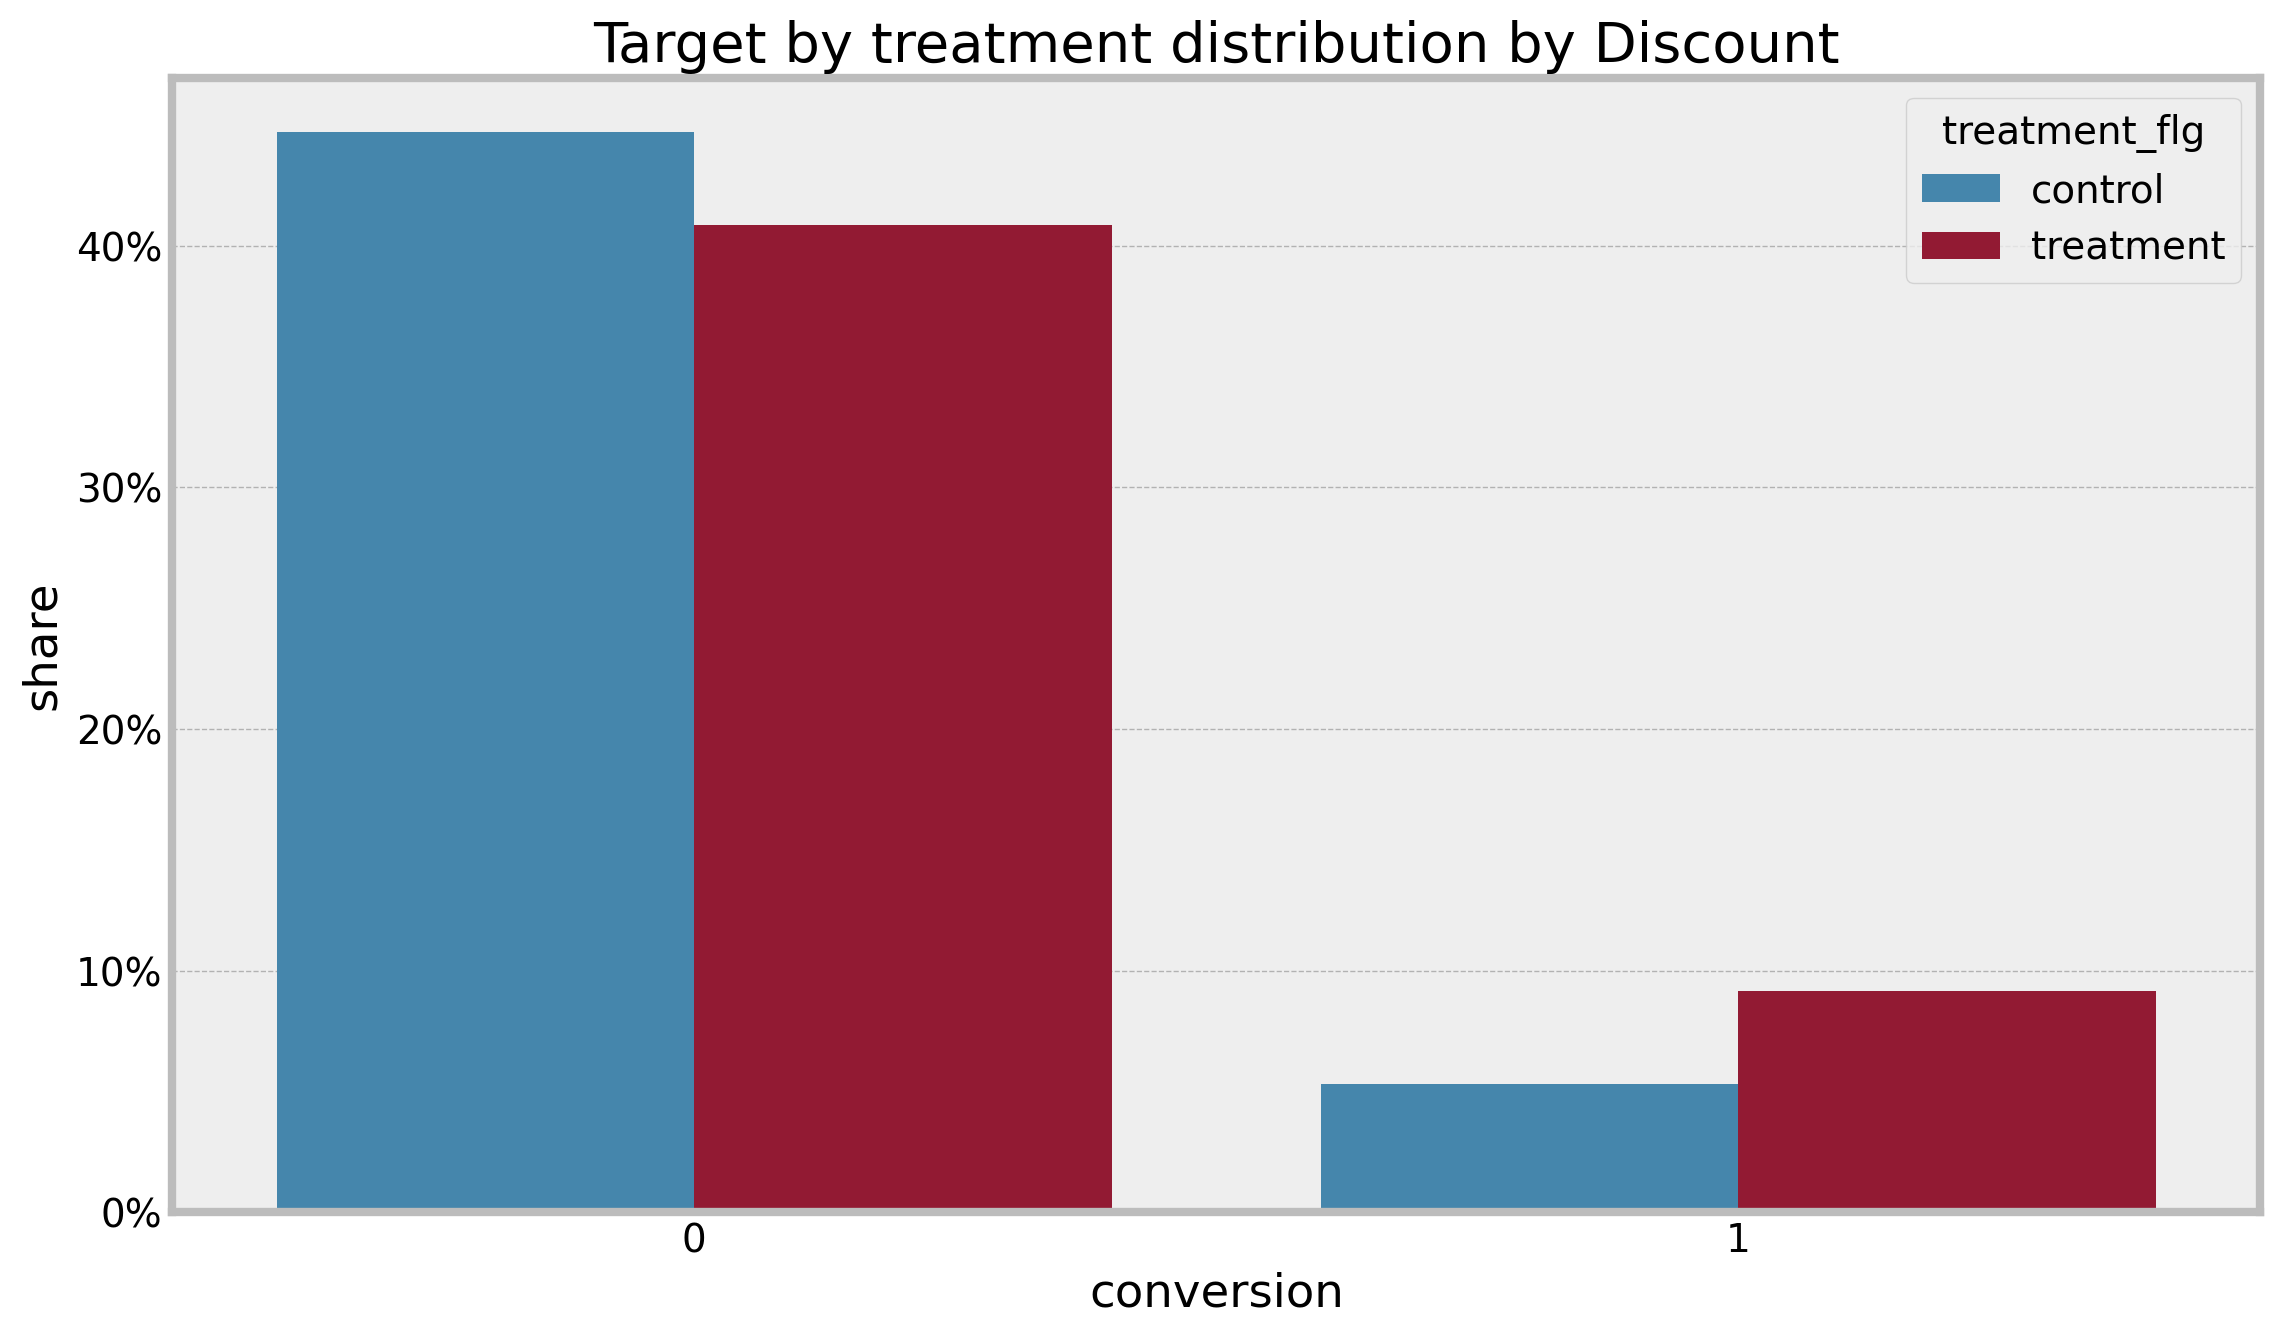

In [14]:
fig, ax = plt.subplots()

df_model_discount \
  .groupby(["treatment_flg", "conversion"], as_index=False) \
  .size() \
  .assign(
    share=lambda x: x["size"] / x["size"].sum()
  ) \
  .pipe((sns.barplot, "data"), x="conversion", y="share", hue="treatment_flg", ax=ax)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y :.0%}"))
ax.set(title="Target by treatment distribution by Discount");

In [17]:
df_model_discount['treatment_flg'].value_counts()

treatment    21307
control      21306
Name: treatment_flg, dtype: int64

We have approximately 50/50 split of the treatment_flg but the conversion is not balanced

In [21]:
df_data

recency  history  used_discount  used_bogo   zip_code  is_referral  \
0           10   142.44              1          0  Surburban            0   
1            6   329.08              1          1      Rural            1   
2            7   180.65              0          1  Surburban            1   
3            9   675.83              1          0      Rural            1   
4            2    45.34              1          0      Urban            0   
...        ...      ...            ...        ...        ...          ...   
63995       10   105.54              1          0      Urban            0   
63996        5    38.91              0          1      Urban            1   
63997        6    29.99              1          0      Urban            1   
63998        1   552.94              1          0  Surburban            1   
63999        1   472.82              0          1  Surburban            0   

            channel            offer  conversion treatment_flg  
0             Phone  Buy One Get One           0     treatment  
1               Web         No Offer           0       control  
2               Web  Buy One Get One           0     treatment  
3               Web         Discount           0     treatment  
4               Web  Buy One Get One           0     treatment  
...             ...              ...         ...           ...  
63995           Web         Discount           0     treatment  
63996         Phone         Discount           0     treatment  
63997         Phone         Discount           0     treatment  
63998  Multichannel  Buy One Get One           0     treatment  
63999           Web         Discount           0     treatment  

[64000 rows x 10 columns]

In [35]:
# total number of customers in each group
total_num_cust = df_data['offer'].value_counts().reset_index().rename(columns={'offer':'total_num'})

# number of customers who bought the product
num_resp = df_data[df_data['conversion'] == 1]['offer'].value_counts().reset_index().rename(columns={'offer':'conv_num'})



In [39]:
# Join the dataframes above and calculate the conversion rate
conv_rate = pd.merge(total_num_cust, num_resp, how='inner', on = 'index').set_index('index')
conv_rate['conversion_rate (%)'] = round(conv_rate['conv_num']/conv_rate['total_num']*100, 2)
conv_rate

total_num  conv_num  conversion_rate (%)
index                                                    
Buy One Get One      21387      3238                15.14
Discount             21307      3894                18.28
No Offer             21306      2262                10.62

In [11]:
#function for calculating the uplift
def calc_uplift(df):
    avg_order_value = 25
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
    
    if len(df[df.offer == 'Buy One Get One']['conversion']) > 0:
          
        print('-------------- \n')
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))     
        

Before we begin developing the model, let's use our calc_uplift method to compare the current uplift of this campaign:

In [12]:
calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


Conversion uplift is 7.66% for discount and 4.52% for buy one get one (BOGO).

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (treatment) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (control).

 
NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.


In addition:
For suppose assume the Cost of sending a promotion: $0.15


Revenue from purchase of product: $25 (There is only one product)

In [81]:
def get_eval_metrics(data, print_results=True):
    
    """
    Given a dataframe, it computes the IRR and the NIR
    
    Arguments:
        data: pandas dataframe
        print_results: Bool for whether to print the metrics
    
    Returns:
        irr, nir: float"""
    
    n_treat       = data.loc[data['treatment_flg'] == 1,:].shape[0]
    n_control     = data.loc[data['treatment_flg'] == 0,:].shape[0]
    n_treat_purch = data.loc[data['treatment_flg'] == 1, 'conversion'].sum()
    n_ctrl_purch  = data.loc[data['treatment_flg'] == 0, 'conversion'].sum()
    
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = (25 * n_treat_purch - 0.15 * n_treat) - 25 * n_ctrl_purch
    
    if print_results==True:
        print(f'IRR: {irr:.4f}')
        print(f'NIR: {nir:.2f}') 
        print(n_treat,n_control,n_treat_purch,n_ctrl_purch)
    return irr, nir

#### Target varibale description 

* Control Non-Responders: Customers that will not purchase if they don’t receive an offer i.e(0)
* Control Responders: Customers that will purchase without an offer i.e(1)
* Treatment Non-Responders: Customer that won’t purchase in any case  i.e(2)
* Treatment Responders: Customers that will purchase only if they receive an offer i.e(3)


In [40]:
# Function to declare Target Class
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 
    return df

In [41]:
df_data

recency  history  used_discount  used_bogo   zip_code  is_referral  \
0           10   142.44              1          0  Surburban            0   
1            6   329.08              1          1      Rural            1   
2            7   180.65              0          1  Surburban            1   
3            9   675.83              1          0      Rural            1   
4            2    45.34              1          0      Urban            0   
...        ...      ...            ...        ...        ...          ...   
63995       10   105.54              1          0      Urban            0   
63996        5    38.91              0          1      Urban            1   
63997        6    29.99              1          0      Urban            1   
63998        1   552.94              1          0  Surburban            1   
63999        1   472.82              0          1  Surburban            0   

            channel            offer  conversion treatment_flg  
0             Phone  Buy One Get One           0     treatment  
1               Web         No Offer           0       control  
2               Web  Buy One Get One           0     treatment  
3               Web         Discount           0     treatment  
4               Web  Buy One Get One           0     treatment  
...             ...              ...         ...           ...  
63995           Web         Discount           0     treatment  
63996         Phone         Discount           0     treatment  
63997         Phone         Discount           0     treatment  
63998  Multichannel  Buy One Get One           0     treatment  
63999           Web         Discount           0     treatment  

[64000 rows x 10 columns]

In [42]:
df_model_bogo['treatment_flg'] = np.where(df_model_bogo['treatment_flg']== 'treatment', 1, 0)
df_model_discount['treatment_flg'] = np.where(df_model_discount['treatment_flg']== 'treatment', 1, 0)

Lets evaluate the some other metrices like IRR (**Incremental Response Rate**) and NIR (**Net Incremental Revenue**)

In [82]:
irr_discount, nir_discount = get_eval_metrics(df_model_discount, print_results=True)

IRR: 0.0766
NIR: 37603.95
21307 21306 3894 2262


In [83]:
irr_bogo, nir_bogo = get_eval_metrics(df_model_bogo, print_results=True)

IRR: 0.0452
NIR: 21191.95
21387 21306 3238 2262


Based on above results we clearly see postive impact of **Incremental Response Rate** and  **Net Incremental Revenue**

##### Discount offer
1. for Discount offer we see the IRR as 7.66 % Uplift in the conversion rate
2. for Discount offer we see the NIR  per customer is  \\$ 1.76 

##### BOGO offer
1. for BOGO offer we see the IRR as 4.5 % Uplift in the conversion rate
2. for BOGO offer we see the NIR  per customer is  \\$ 1 



In [45]:
df_discount = df_model_discount.drop(['offer',  'used_bogo'],axis=1)
df_discount = pd.get_dummies(df_discount)



df_bogo = df_model_bogo.drop(['offer', 'used_discount'],axis=1)
df_bogo = pd.get_dummies(df_bogo)

In [46]:
df_bogo

recency  history  used_bogo  is_referral  conversion  treatment_flg  \
0           10   142.44          0            0           0              1   
1            6   329.08          1            1           0              0   
2            7   180.65          1            1           0              1   
3            2    45.34          0            0           0              1   
4            6   134.83          1            0           1              1   
...        ...      ...        ...          ...         ...            ...   
42688       10   304.30          1            0           1              1   
42689        6    80.02          1            0           0              0   
42690        1   306.10          0            1           0              1   
42691        4   374.07          1            0           0              1   
42692        1   552.94          0            1           0              1   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
0                   0                   1               0   
1                   1                   0               0   
2                   0                   1               0   
3                   0                   0               1   
4                   0                   1               0   
...               ...                 ...             ...   
42688               0                   1               0   
42689               0                   1               0   
42690               0                   1               0   
42691               0                   1               0   
42692               0                   1               0   

       channel_Multichannel  channel_Phone  channel_Web  
0                         0              1            0  
1                         0              0            1  
2                         0              0            1  
3                         0              0            1  
4                         0              1            0  
...                     ...            ...          ...  
42688                     0              0            1  
42689                     0              1            0  
42690                     0              1            0  
42691                     0              1            0  
42692                     1              0            0  

[42693 rows x 12 columns]

#### Lets start with discount data first then we move on to BOGO 

In [47]:

target_col = "conversion"
treatment_col = "treatment_flg"

y = df_discount[target_col]
w = df_discount[treatment_col]
x = df_discount.drop(columns=[treatment_col, target_col])


idx_train, idx_val = train_test_split(
    df_discount.index,
    test_size=0.3,
    random_state=42,
    stratify=(y.astype(str) + "_" + w.astype(str)),
)

x_train = x.loc[idx_train]
x_val = x.loc[idx_val]

w_train = w.loc[idx_train]
w_val = w.loc[idx_val]

y_train = y.loc[idx_train]
y_val = y.loc[idx_val]

#### Propensity Score Model
The propensity score are defined as that is, the probability of having a treatment given the covariates. If the treatment assignment is at random these scores should be concentrated around 0.5. For a nice introduction to the subject you can see ["Propensity Score Matching: A Non-experimental Approach to Causal Inference” by Michael Johns, PyData New York 2019](https://www.youtube.com/watch?v=gaUgW7NWai8&ab_channel=PyData)


The is no such reasons of using HistGradientBoostingClassifier model (just picked it randomly), We can try with different models

In [48]:
## Lets fit the model 

propensity_model = HistGradientBoostingClassifier()

propensity_model.fit(X=x_train, y=w_train)
p_train = propensity_model.predict_proba(X=x_train)
p_val = propensity_model.predict_proba(X=x_val)

p_train = pd.Series(p_train[:, 0], index=idx_train)
p_val = pd.Series(p_val[:, 0], index=idx_val)

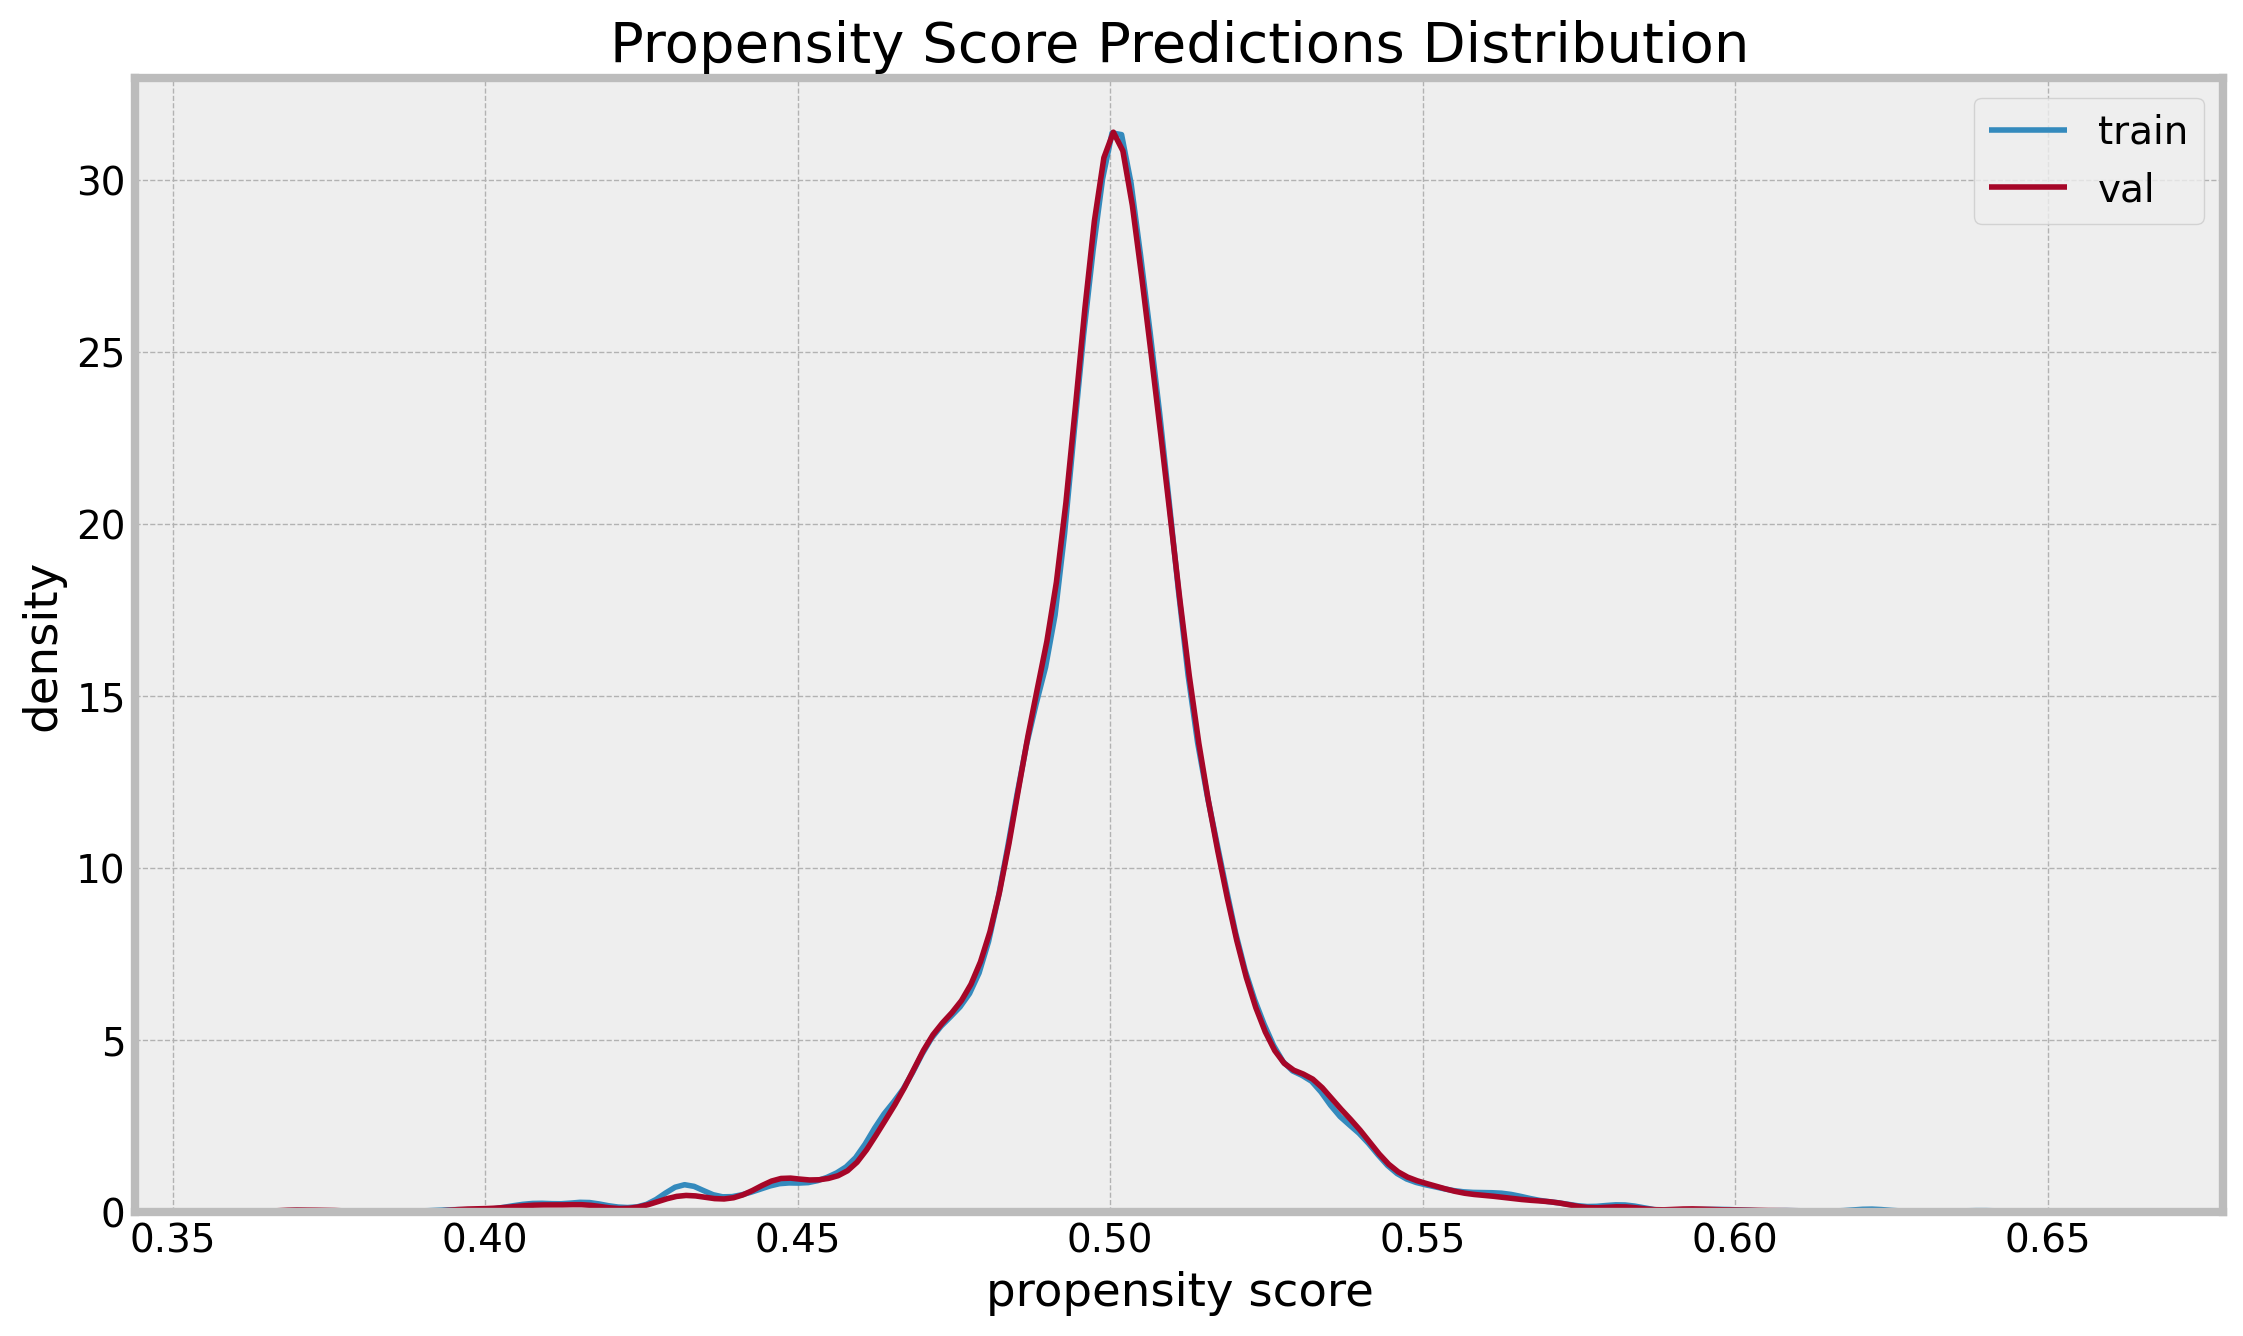

In [49]:
fig, ax = plt.subplots()
sns.kdeplot(x=p_train, label="train", ax=ax)
sns.kdeplot(x=p_val, label="val", ax=ax)
ax.legend()
ax.set(
    title="Propensity Score Predictions Distribution",
    xlabel="propensity score",
    ylabel="density",
);

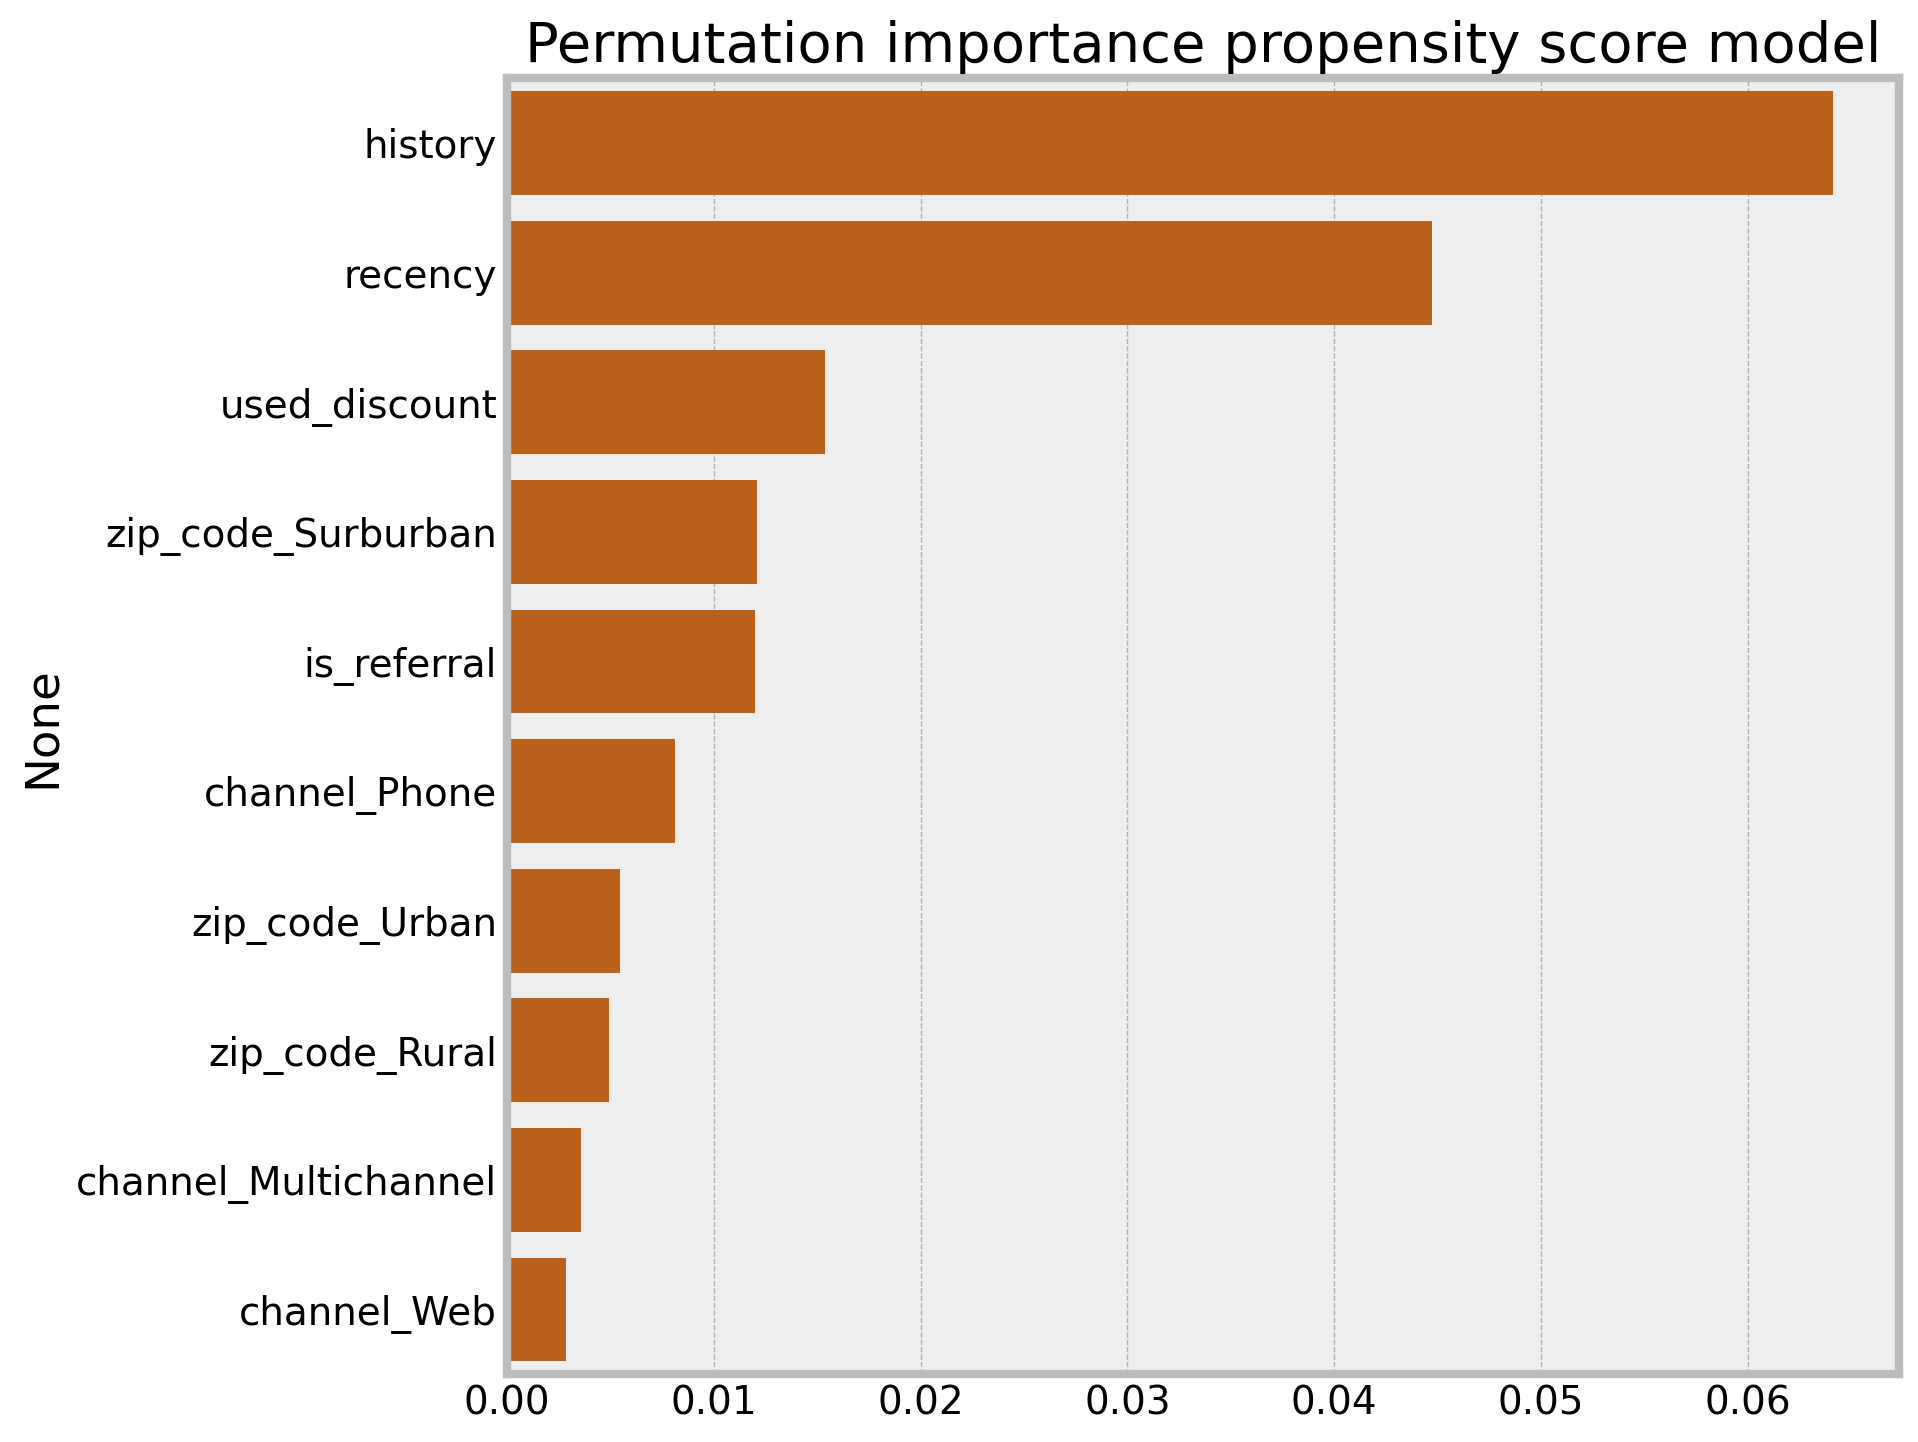

In [56]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(
    estimator=propensity_model, X=x_train, y=w_train
)

fig, ax = plt.subplots(figsize=(8, 8))

idx = pi["importances_mean"].argsort()[::-1]

sns.barplot(
    x=pi["importances_mean"][idx],
    y=x_train.columns[idx],
    color="C4",
    ax=ax
)
ax.set(title="Permutation importance propensity score model");

Modeling with Meta Learners, we define a convenient data structure for the uplift model inputdata 

In [51]:
from dataclasses import dataclass

@dataclass
class DataIn:
    x: pd.DataFrame
    y: pd.Series
    treatment: pd.Series
    p: pd.Series


data_train = DataIn(
    x=x_train,
    y=y_train,
    treatment=w_train,
    p=p_train,
)

data_val = DataIn(
    x=x_val,
    y=y_val,
    treatment=w_val,
    p=p_val
)

#### Models

We use Meta learners from Uber's python packages[**causalml**](https://causalml.readthedocs.io/en/latest/methodology.html#meta-learner-algorithms)

1. **S-Learner**: In this S-Learner(Single Learner) we simply train an ML model to predict the target variable using the covariates X plus the target as regressors.
2. **T-Learner**: In this T-Learner(Two Learners) we train two model one for each treatment and control
3. **X-Learners**: The X-Learner is similar to the T-Learner but it adds and additional step where we transfer information from one model to the other 

In [52]:
##S-learner model
s_learner = BaseSClassifier(learner=HistGradientBoostingClassifier())

s_ate = s_learner.estimate_ate(
    X=data_train.x, treatment=data_train.treatment, y=data_train.y

)


##T-learner model
t_learner = BaseTClassifier(learner=HistGradientBoostingClassifier())

t_ate_lwr, t_ate, t_ate_upr = t_learner.estimate_ate(
    X=data_train.x, treatment=data_train.treatment, y=data_train.y
)


##X-learner model
x_learner = BaseXClassifier(
    outcome_learner=HistGradientBoostingClassifier(),
    effect_learner=HistGradientBoostingRegressor(),
)

x_ate_lwr, x_ate, x_ate_upr = x_learner.estimate_ate(
    X=data_train.x,
    treatment=data_train.treatment,
    y=data_train.y,
    p=data_train.p,
)

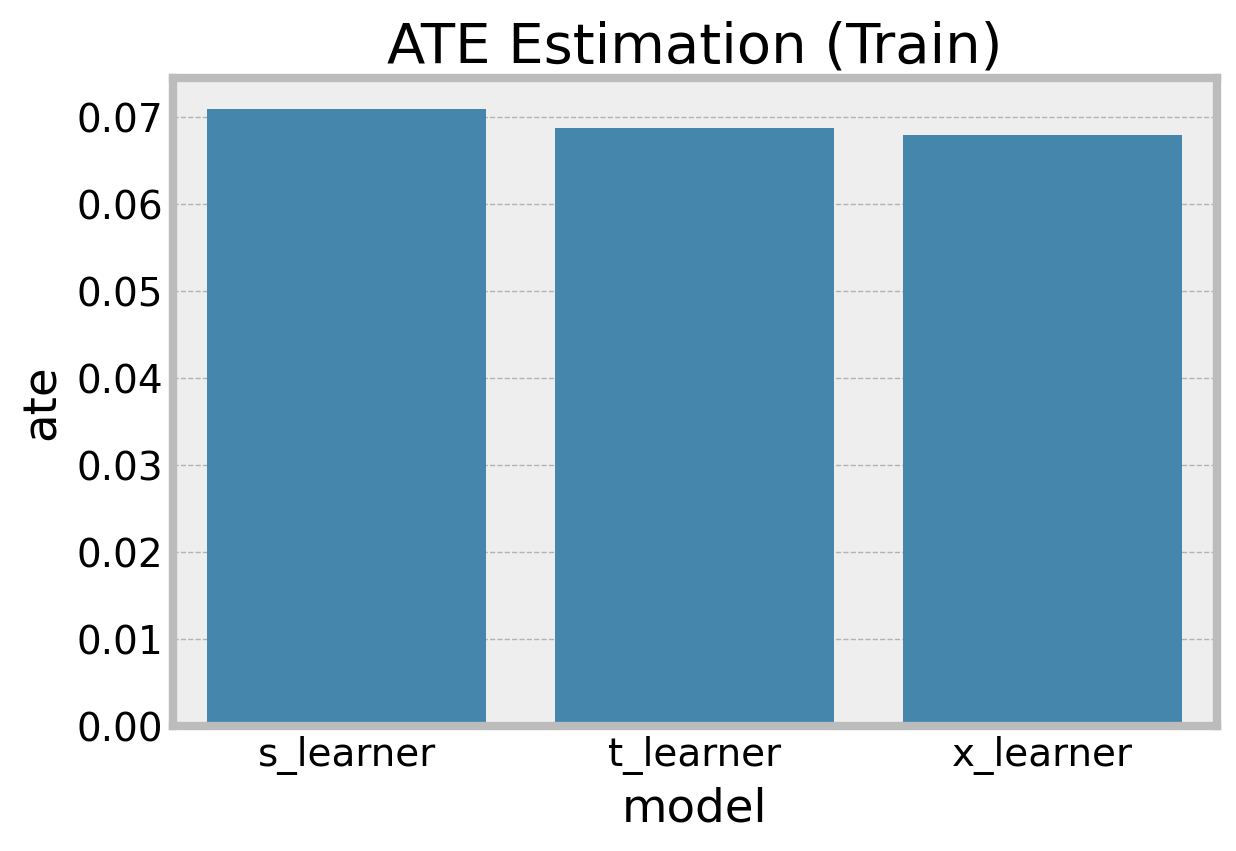

In [53]:
fig, ax = plt.subplots(figsize=(6, 4))

pd.DataFrame(
    data={
        "model": ["s_learner", "t_learner", "x_learner"],
        "ate": np.array([s_ate, t_ate, x_ate]).flatten(),
    },
).pipe((sns.barplot, "data"), x="model", y="ate", ax=ax)
ax.set(title="ATE Estimation (Train)");

From benchmark for the discount campaign.

* Discount Conversion Uplift: 7 %

### Predictions 

After we fitted the Meta Models, It is time to check the most critical part of having this model. Is these models really working? we generate predictions in the training and validations sets.

In [54]:
@dataclass
class DataOut:
    meta_learner_name: str
    meta_learner: BaseLearner
    y_pred: np.array


# in-sample predictions
data_out_train_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
        X=data_train.x, treatment=data_train.treatment
    ),
)
data_out_train_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
        X=data_train.x, treatment=data_train.treatment
    ),
)
data_out_train_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_train.x, treatment=data_train.treatment, p=data_train.p
    ),
)
# out-of-sample predictions
data_out_val_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
      X=data_val.x, treatment=data_val.treatment
    ),
)
data_out_val_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
      X=data_val.x, treatment=data_val.treatment
    ),
)
data_out_val_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_val.x, treatment=data_val.treatment, p=data_val.p
    ),
)

X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names


#### Calucate the uplift score for each customers



In [57]:
from sklift.metrics import uplift_by_percentile, uplift_curve
from sklift.viz import (
    plot_qini_curve,
    plot_uplift_by_percentile,
    plot_uplift_curve,
)

uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=data_out_train_s.y_pred.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    total=True,
)

uplift_by_percentile_df

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


n_treatment  n_control  response_rate_treatment  \
percentile                                                    
0-10               1519       1464                 0.345622   
10-20              1474       1509                 0.246947   
20-30              1497       1486                 0.203073   
30-40              1497       1486                 0.179025   
40-50              1516       1467                 0.178100   
50-60              1474       1509                 0.140434   
60-70              1477       1506                 0.115775   
70-80              1474       1509                 0.122795   
80-90              1493       1490                 0.127261   
90-100             1494       1488                 0.164659   
total             14915      14914                 0.182769   

            response_rate_control    uplift  
percentile                                   
0-10                     0.103825  0.241797  
10-20                    0.082836  0.164111  
20-30                    0.082773  0.120300  
30-40                    0.103634  0.075391  
40-50                    0.098160  0.079941  
50-60                    0.084162  0.056272  
60-70                    0.081009  0.034766  
70-80                    0.089463  0.033332  
80-90                    0.133557 -0.006296  
90-100                   0.202957 -0.038298  
total                    0.106142  0.076627

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


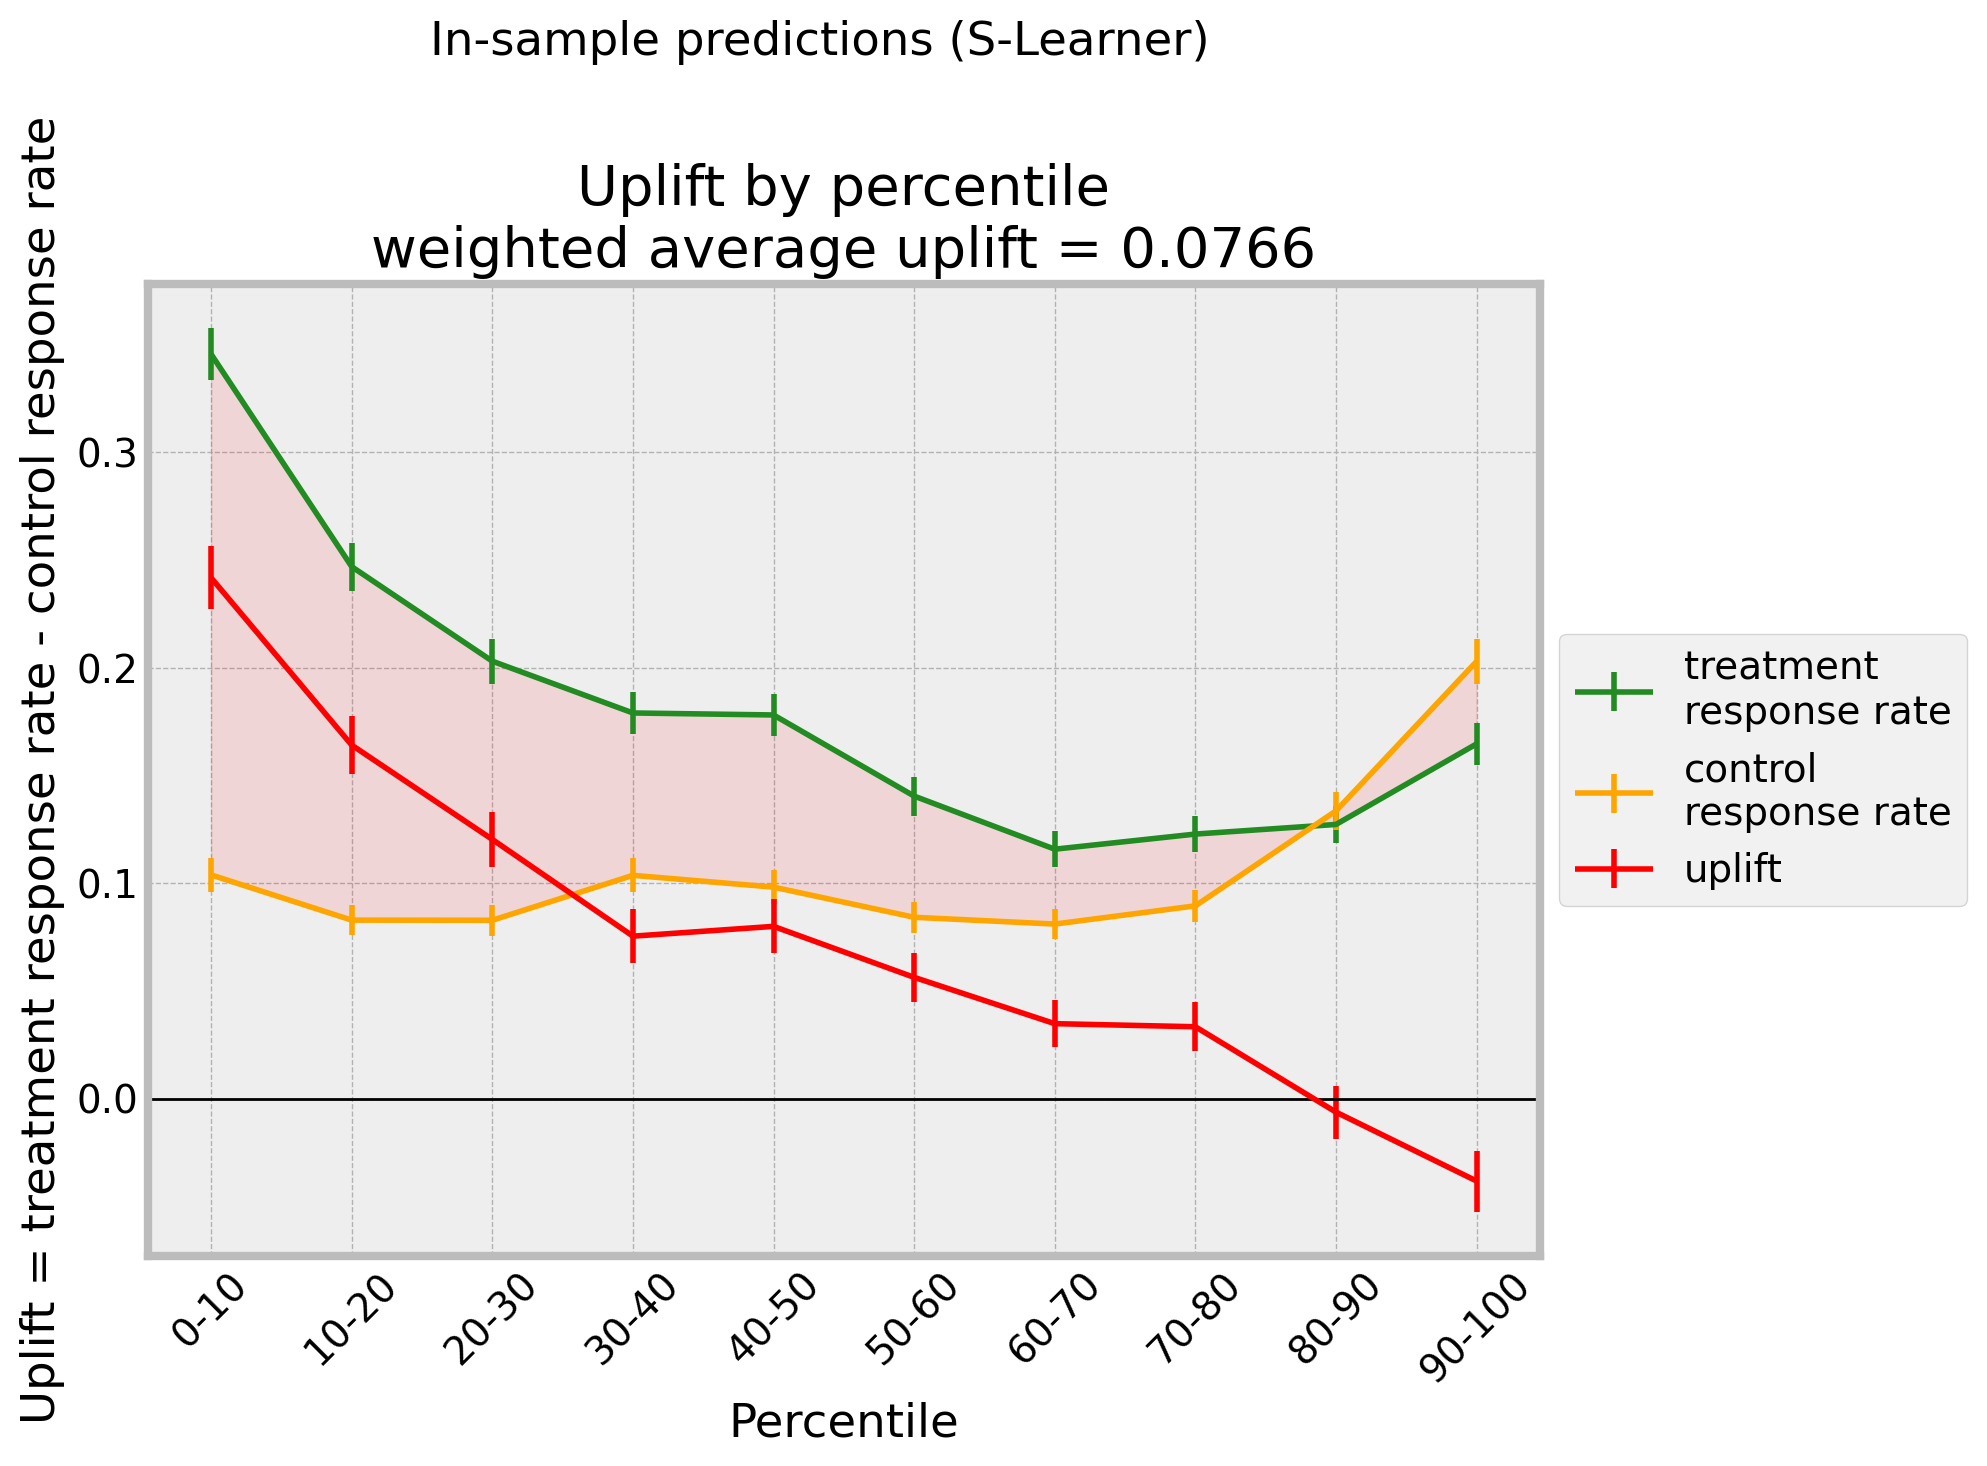

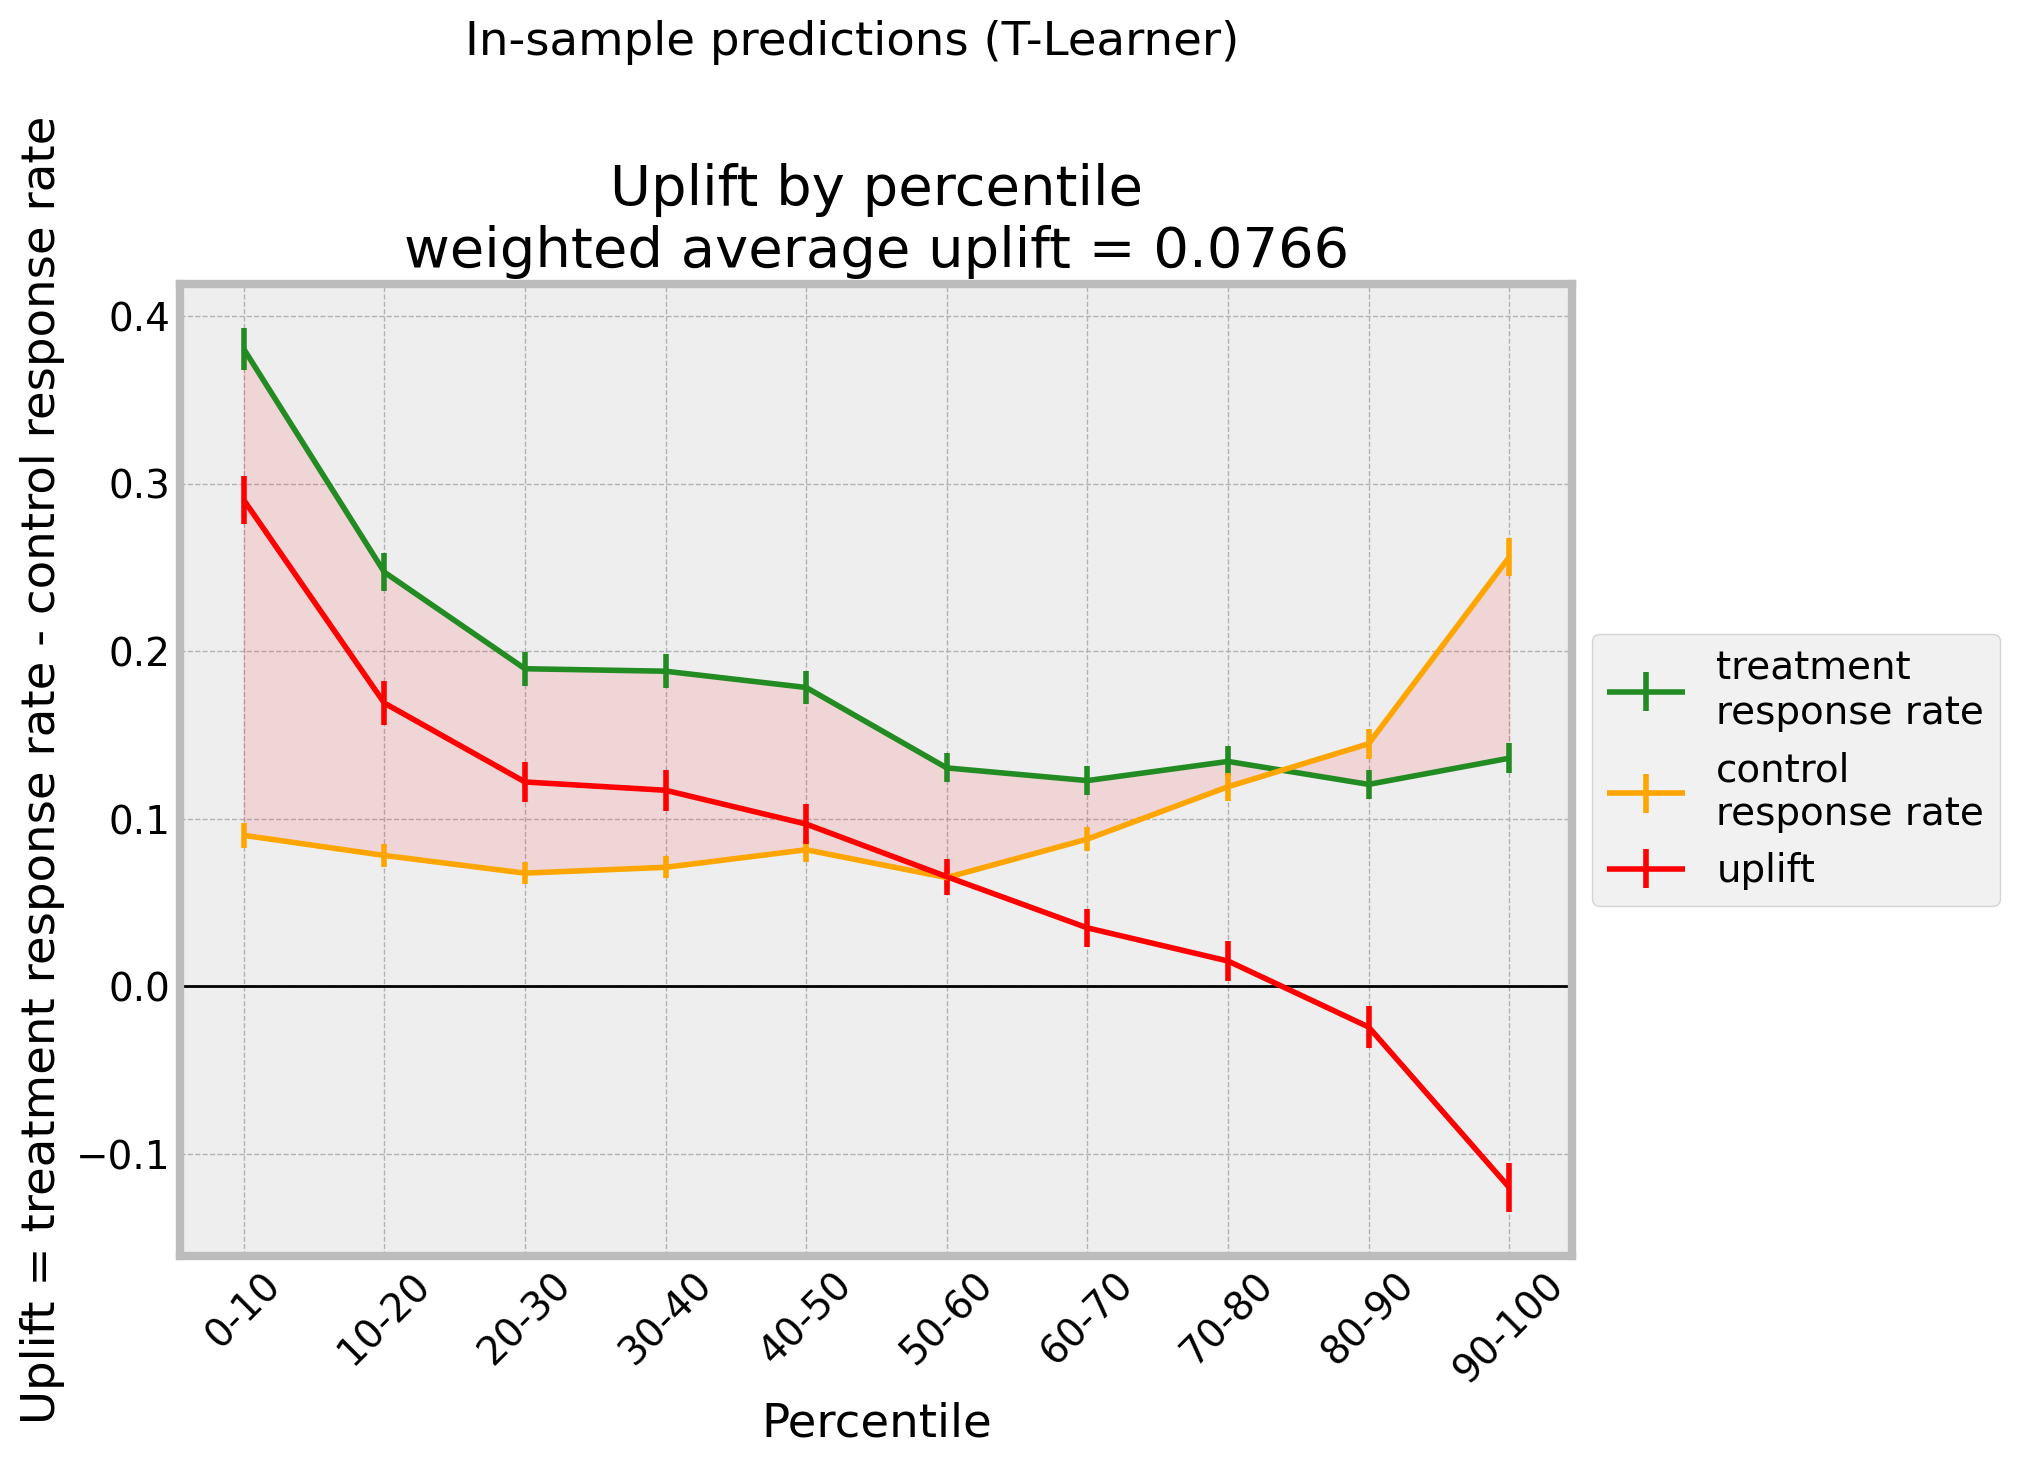

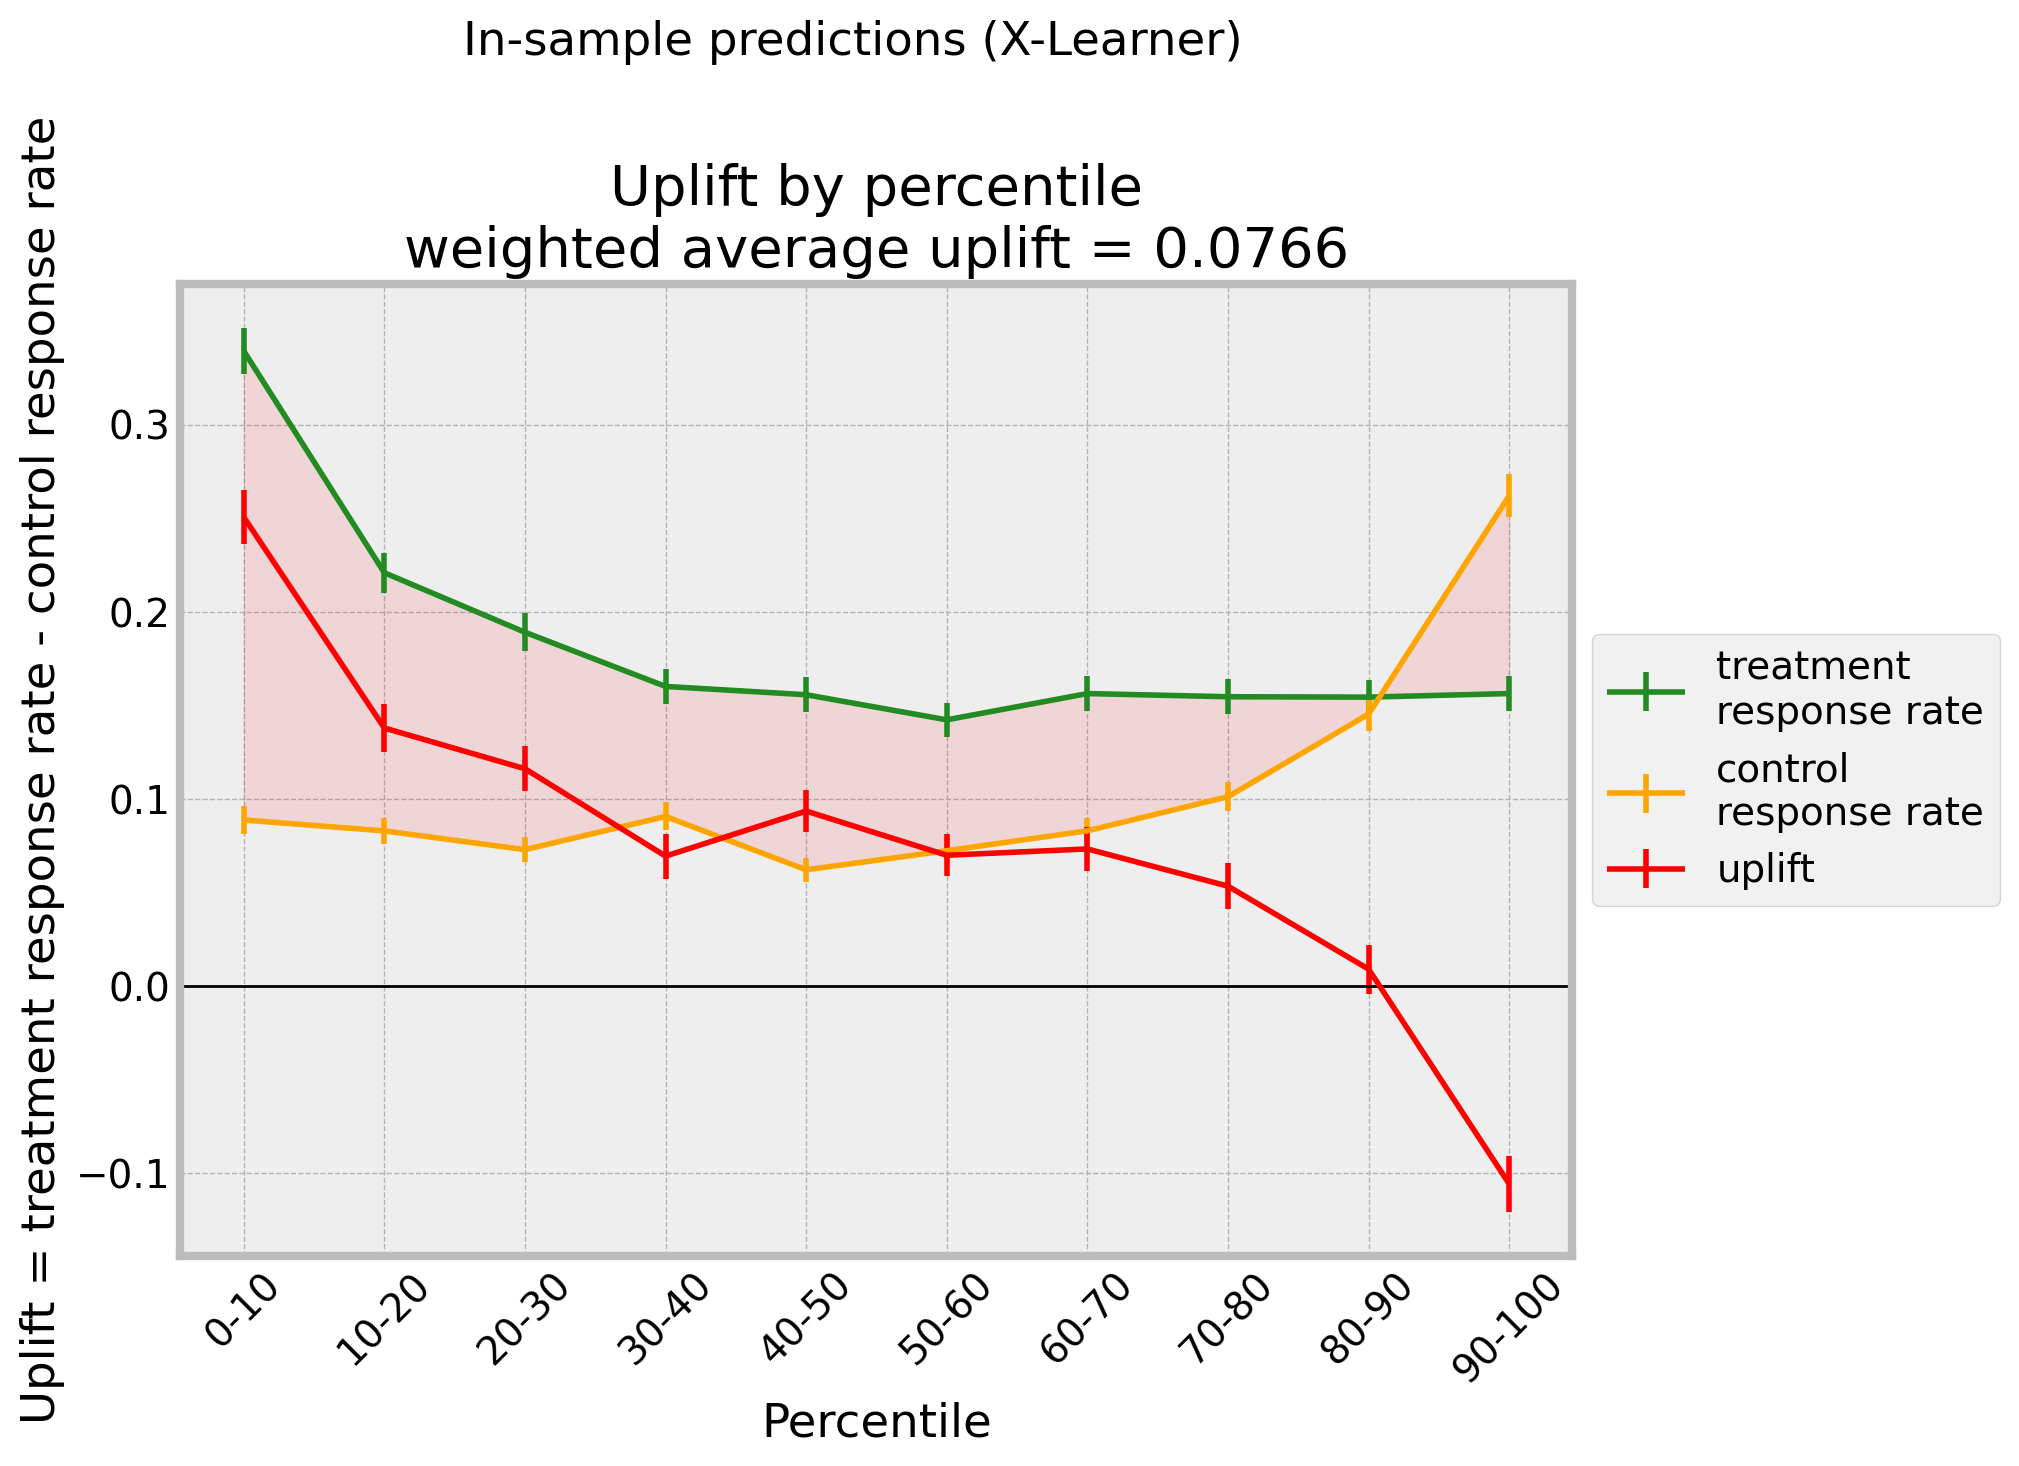

In [58]:
train_pred = [data_out_train_s, data_out_train_t, data_out_train_x]

for data_out_train in train_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(
      f"In-sample predictions ({data_out_train.meta_learner_name})", y=1.1
    )

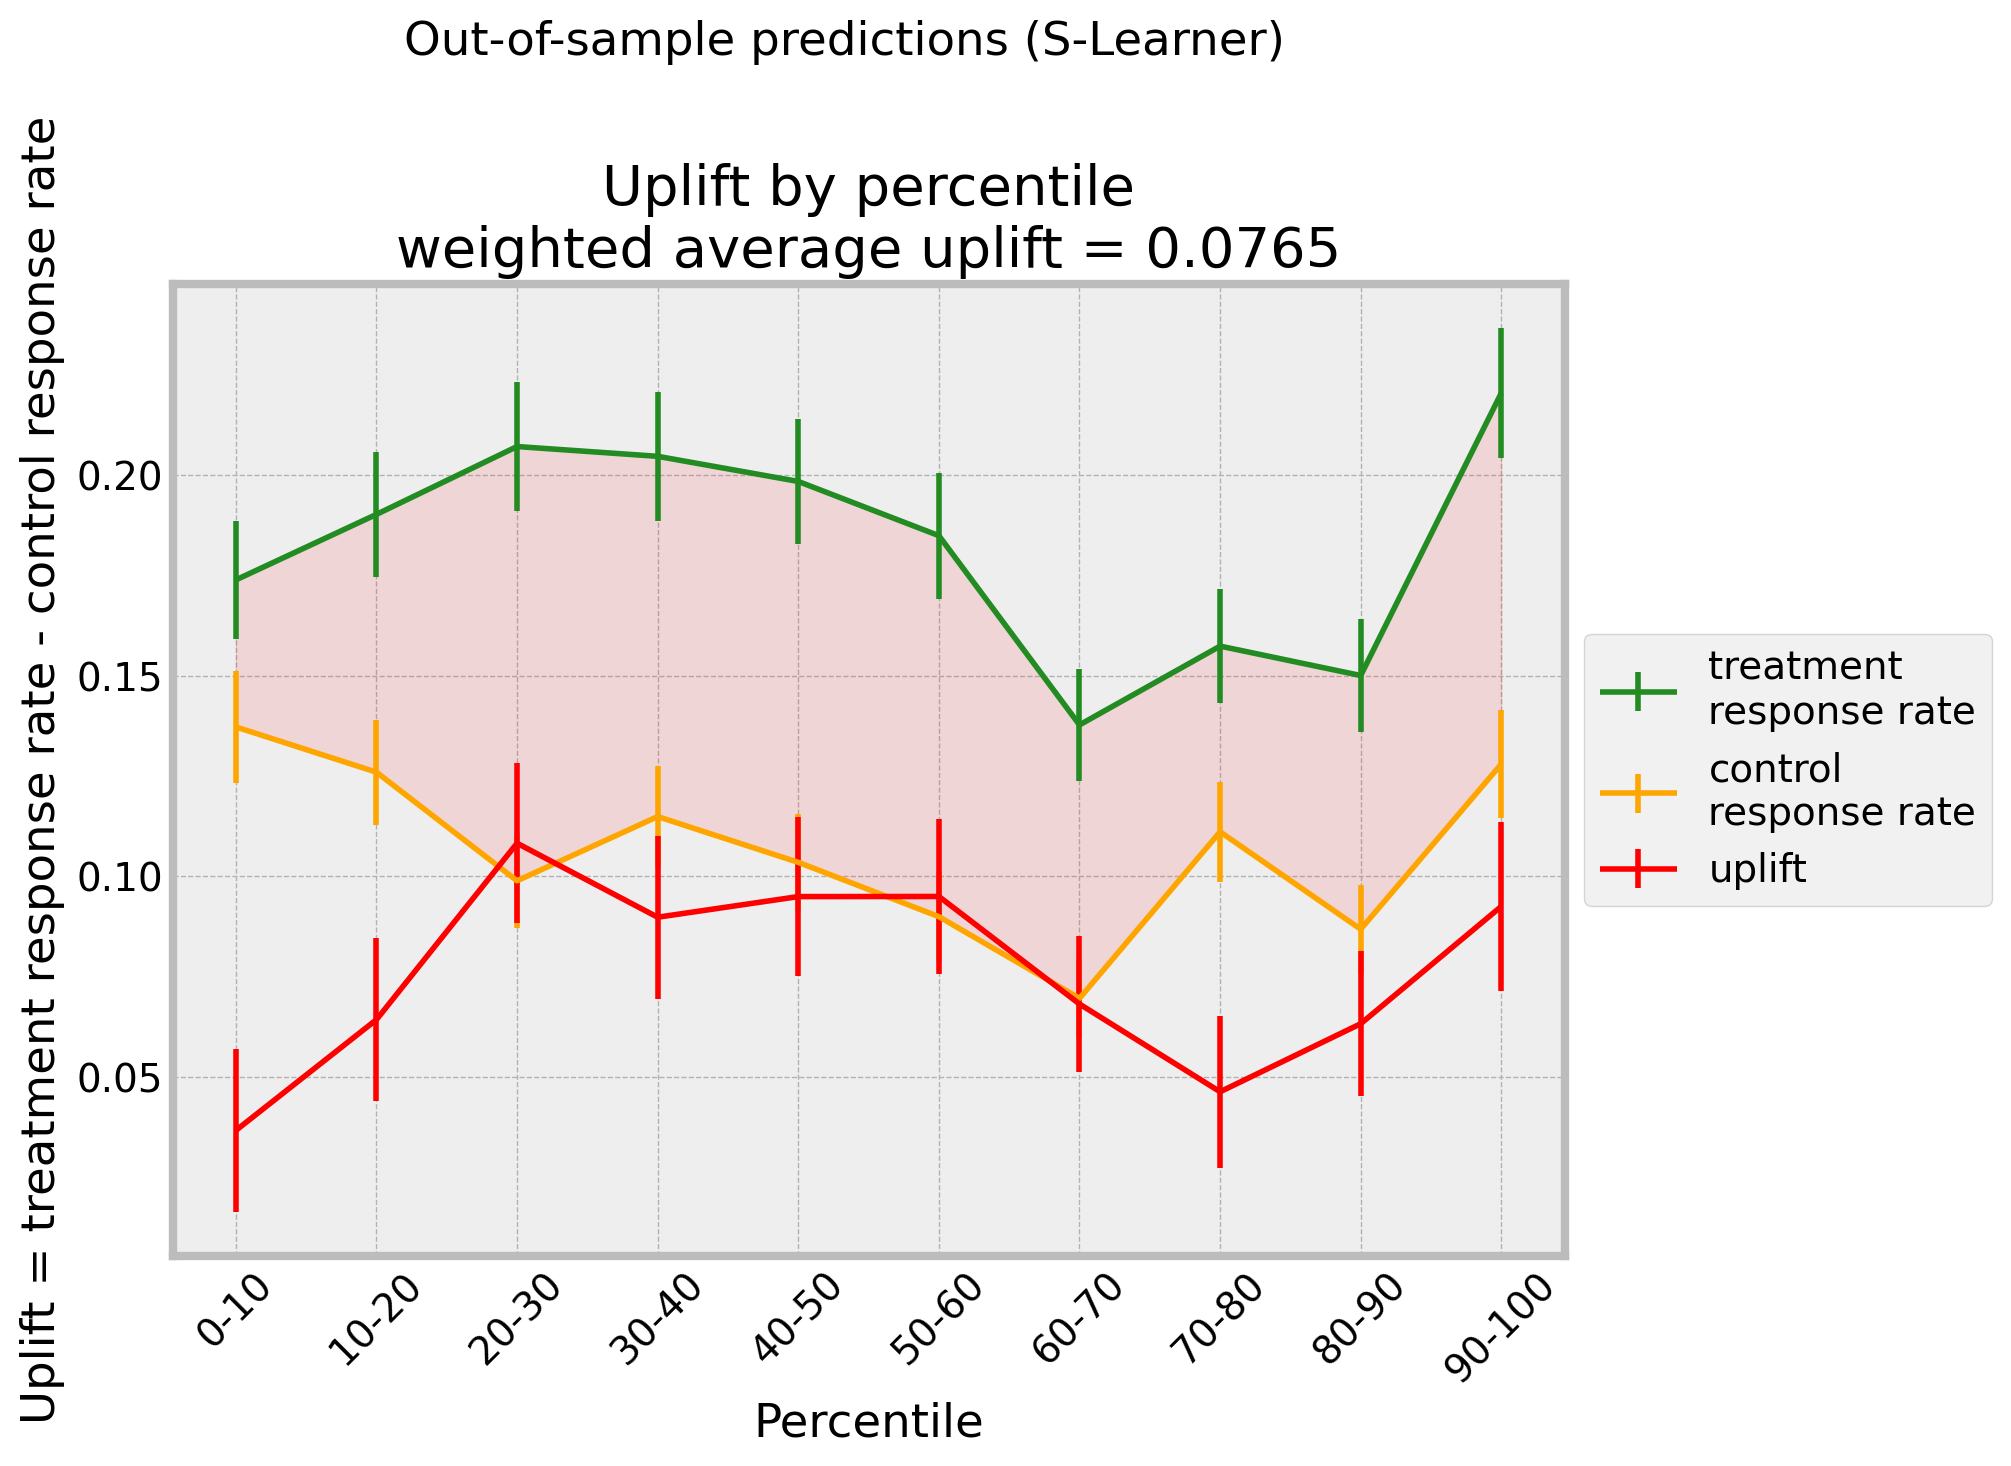

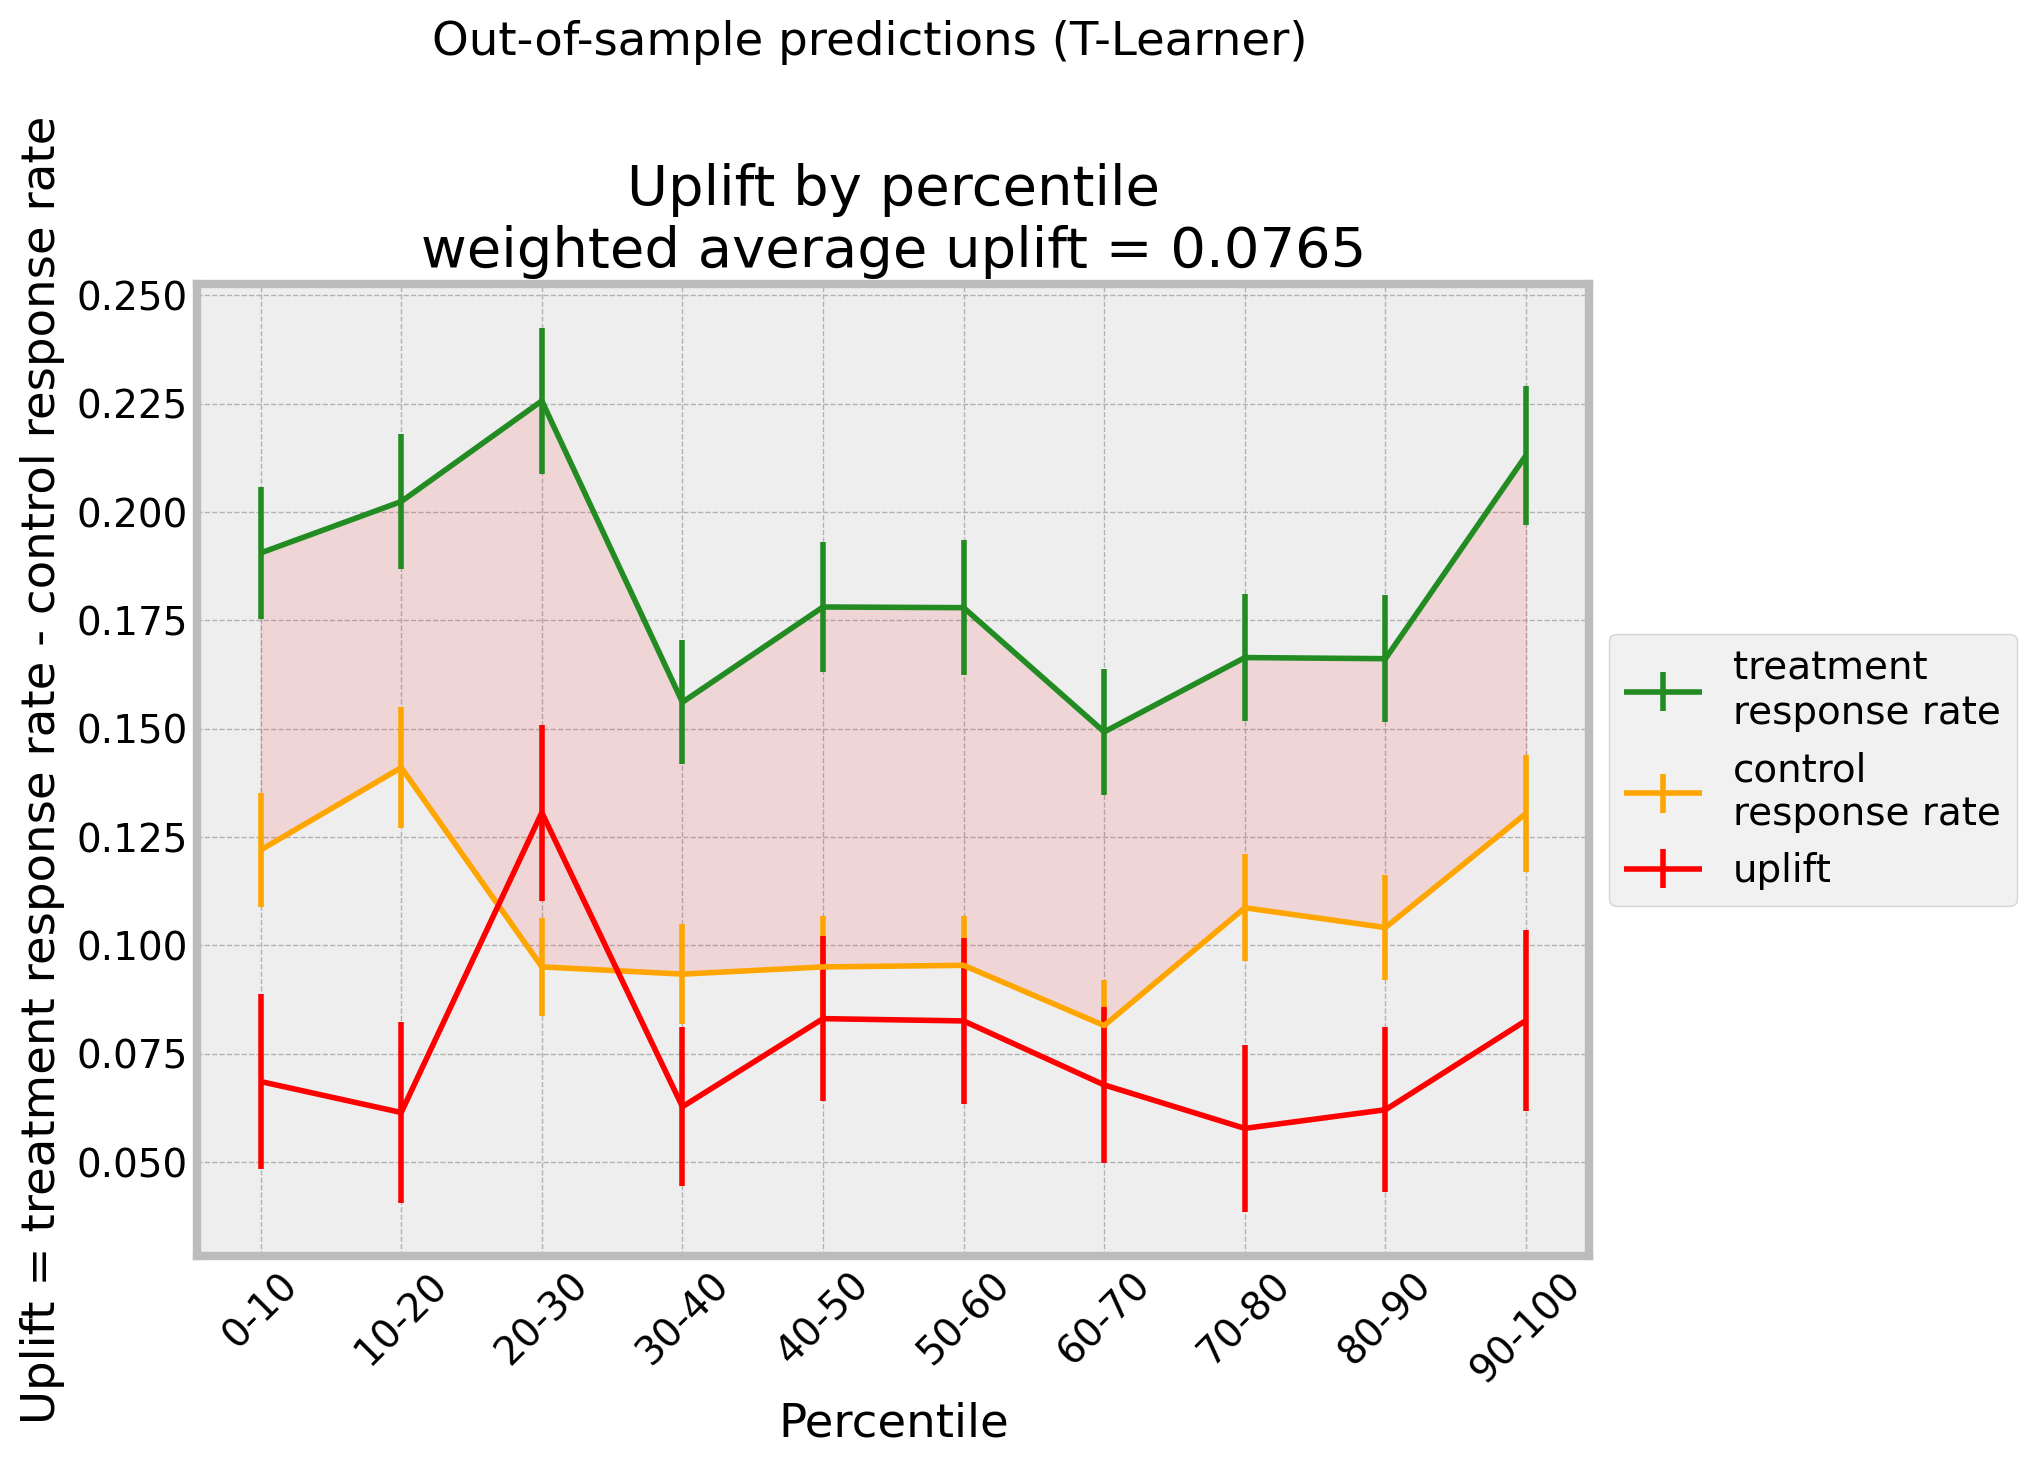

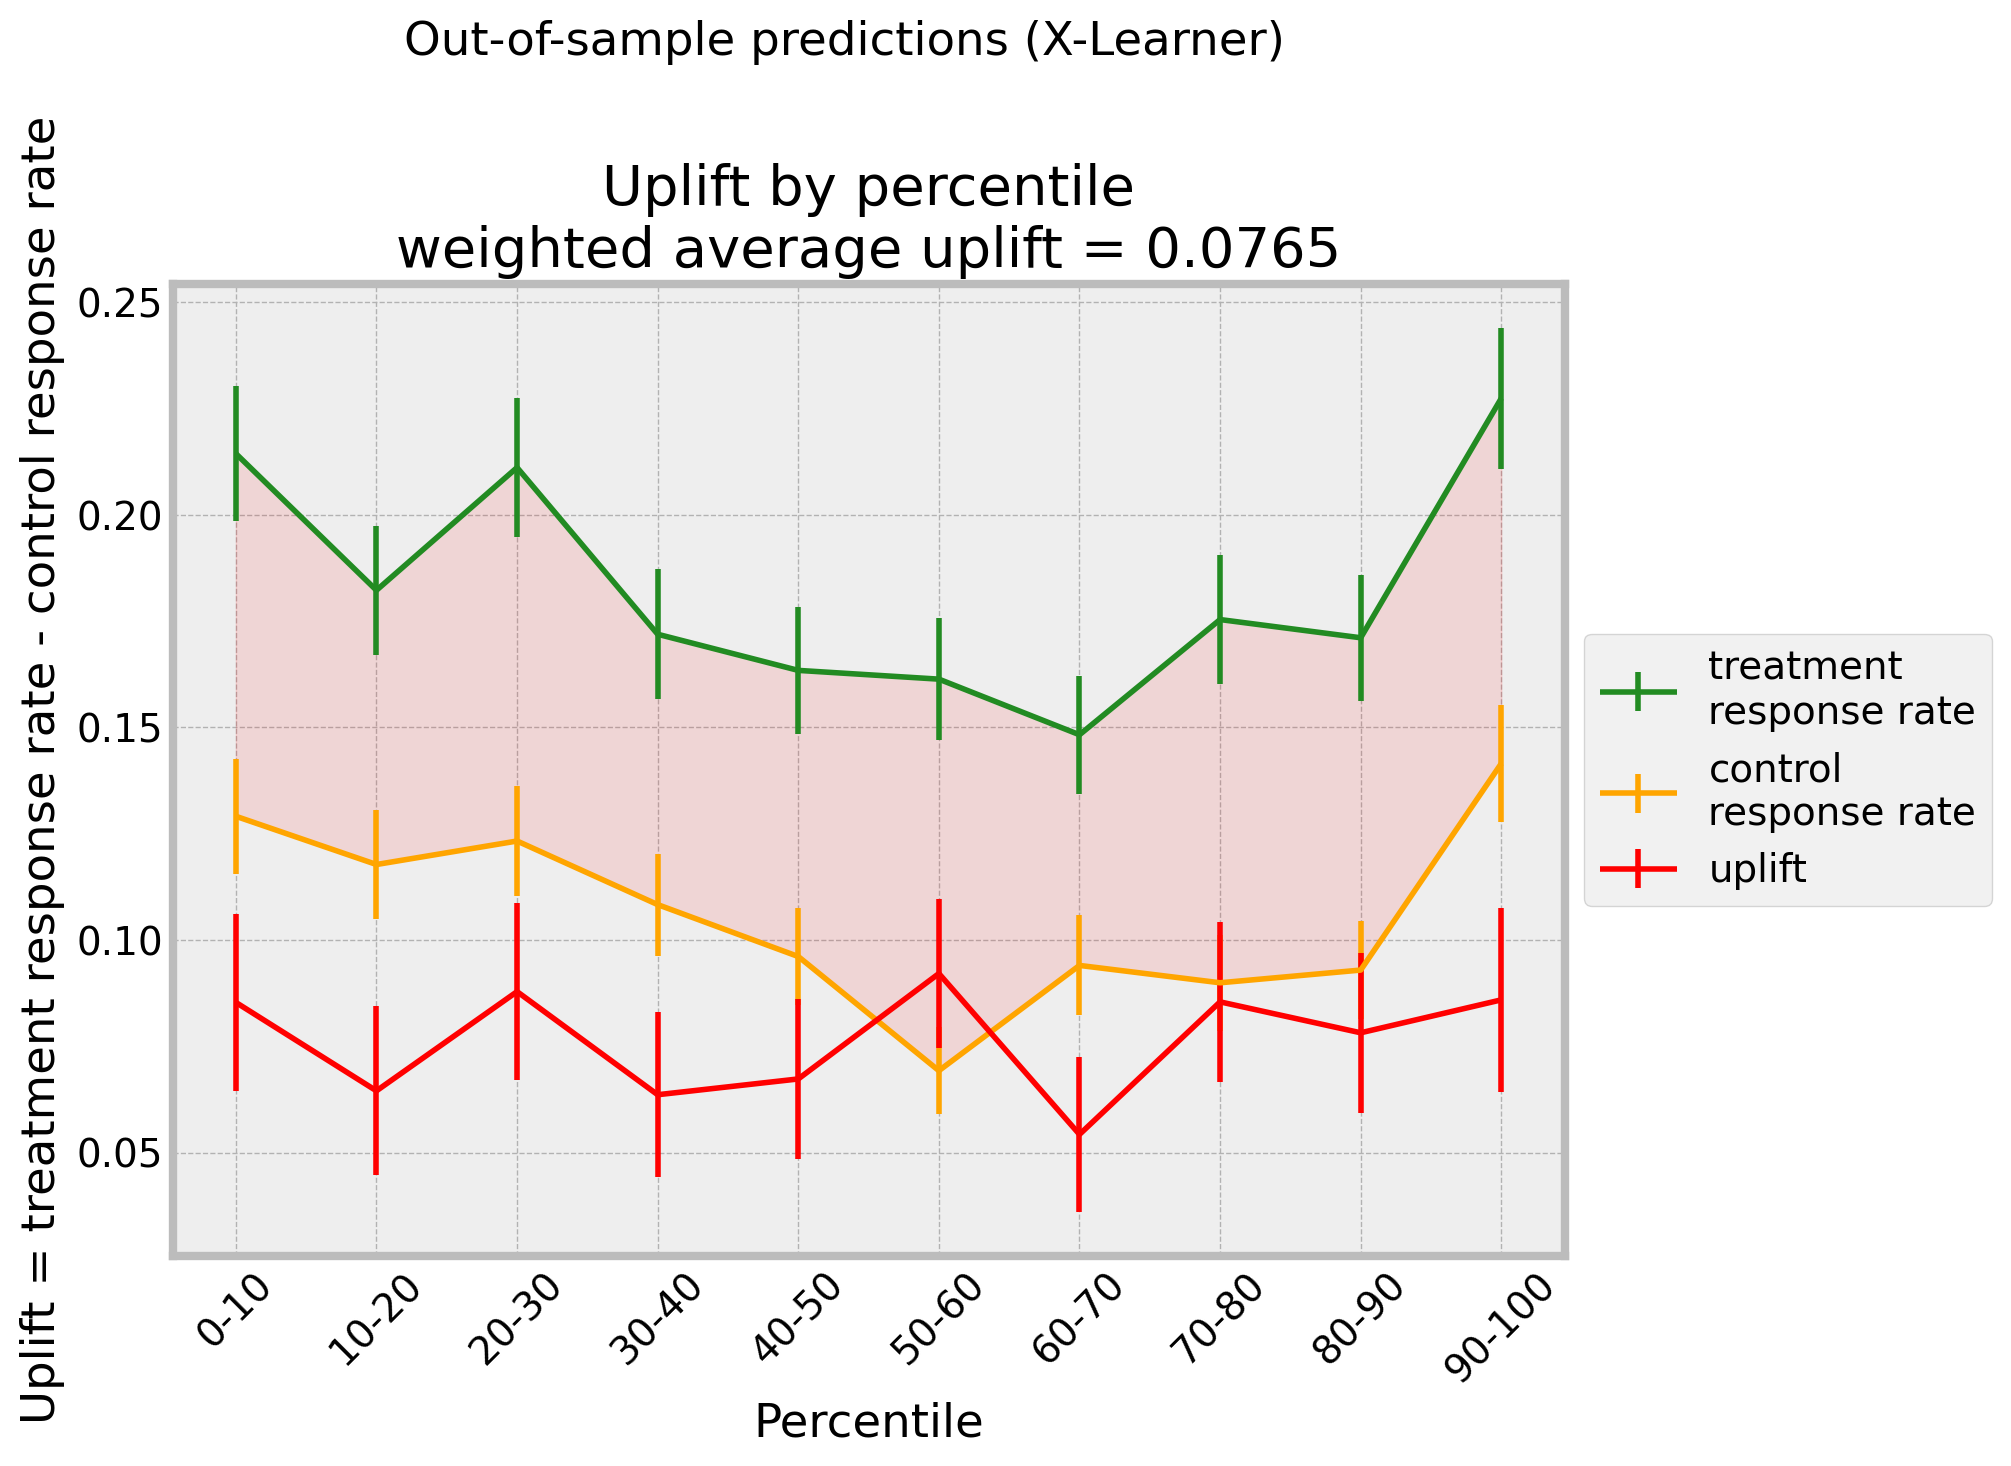

In [59]:
val_pred = [data_out_val_s, data_out_val_t, data_out_val_x]

for data_out_val in val_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(
      f"Out-of-sample predictions ({data_out_val.meta_learner_name})", y=1.1
    )

#### Cumulative gain chart

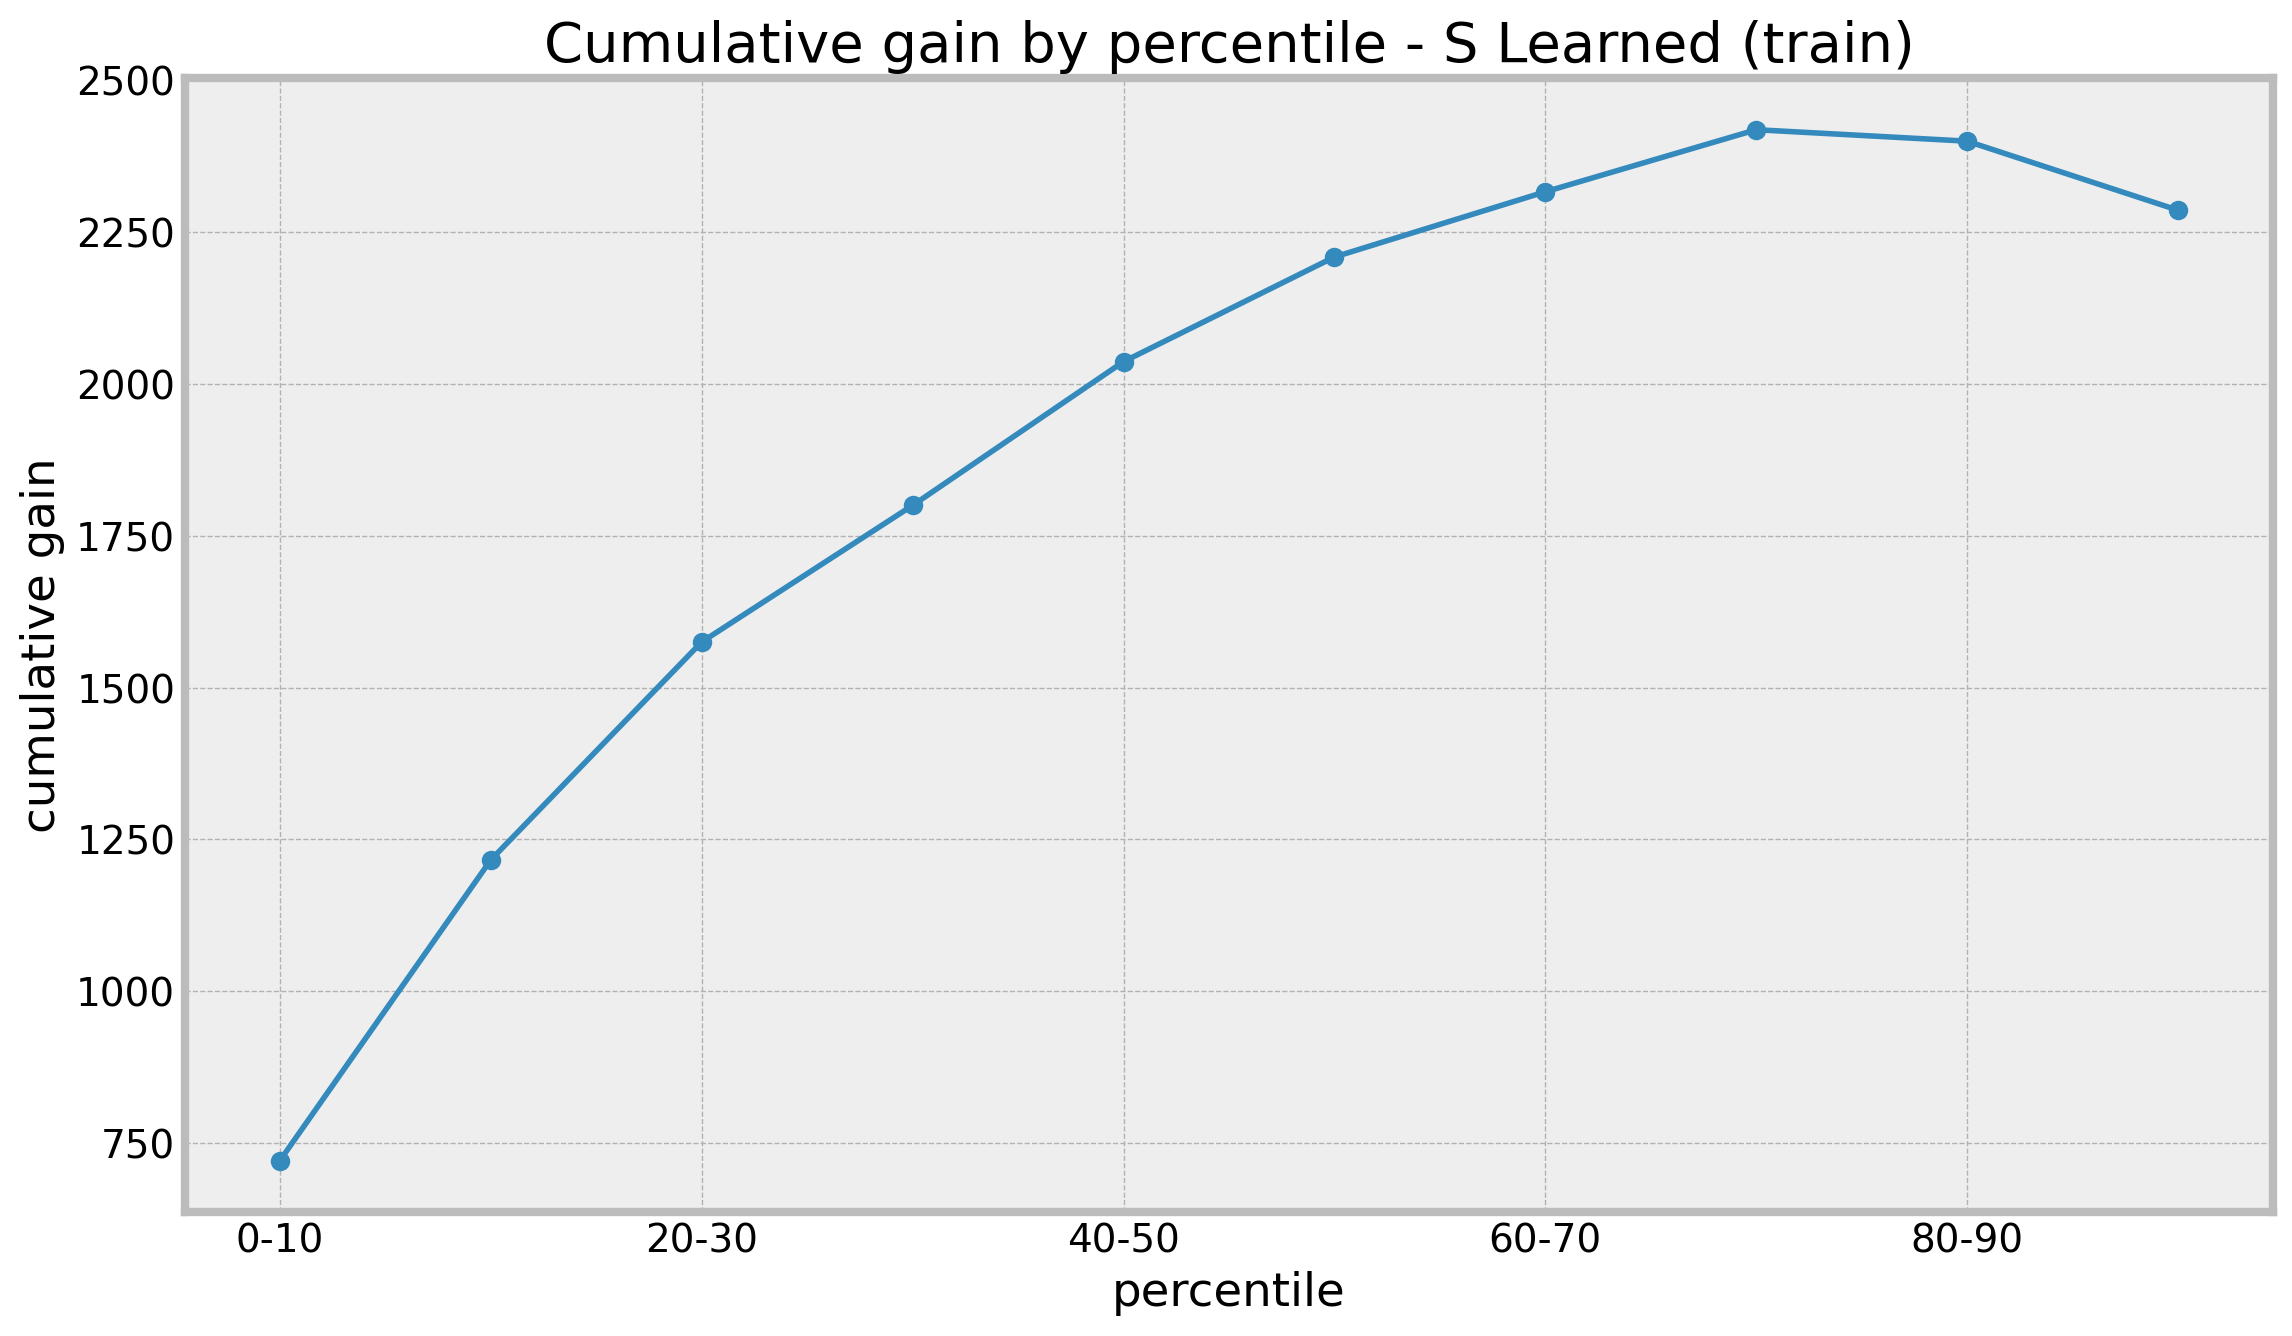

In [60]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=data_out_train_s.y_pred.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    total=False,
)


def compute_response_absolutes(df: pd.DataFrame) -> pd.DataFrame:
    df["responses_treatment"] = df["n_treatment"] * df["response_rate_treatment"]
    df["responses_control"] = df["n_control"] * df["response_rate_control"]
    return df


def compute_cumulative_response_rates(df: pd.DataFrame) -> pd.DataFrame:
    df["n_treatment_cumsum"] = df["n_treatment"].cumsum()
    df["n_control_cumsum"] = df["n_control"].cumsum()
    df["responses_treatment_cumsum"] = df["responses_treatment"].cumsum()
    df["responses_control_cumsum"] = df["responses_control"].cumsum()
    df["response_rate_treatment_cumsum"] = (
        df["responses_treatment_cumsum"] / df["n_treatment_cumsum"]
    )
    df["response_rate_control_cumsum"] = (
        df["responses_control_cumsum"] / df["n_control_cumsum"]
    )
    return df


def compute_cumulative_gain(df: pd.DataFrame) -> pd.DataFrame:
    df["uplift_cumsum"] = (
        df["response_rate_treatment_cumsum"] - df["response_rate_control_cumsum"]
    )
    df["cum_gain"] = df["uplift_cumsum"] * (
        df["n_treatment_cumsum"] + df["n_control_cumsum"]
    )
    return df


fig, ax = plt.subplots()

uplift_by_percentile_df \
  .pipe(compute_response_absolutes) \
  .pipe(compute_cumulative_response_rates) \
  .pipe(compute_cumulative_gain) \
  .plot(y="cum_gain", kind="line", marker="o", ax=ax)
ax.legend().remove()
ax.set(
    title="Cumulative gain by percentile - S Learned (train)",
    ylabel="cumulative gain"
);


Marketers can quickly determine whether a treatment has a favorable or negative worldwide impact and whether they can anticipate a higher profit by focusing on a specific segment of the population, which is helpful. Thus, we can set the limit of the population to be targeted at the decile that maximizes the gain.

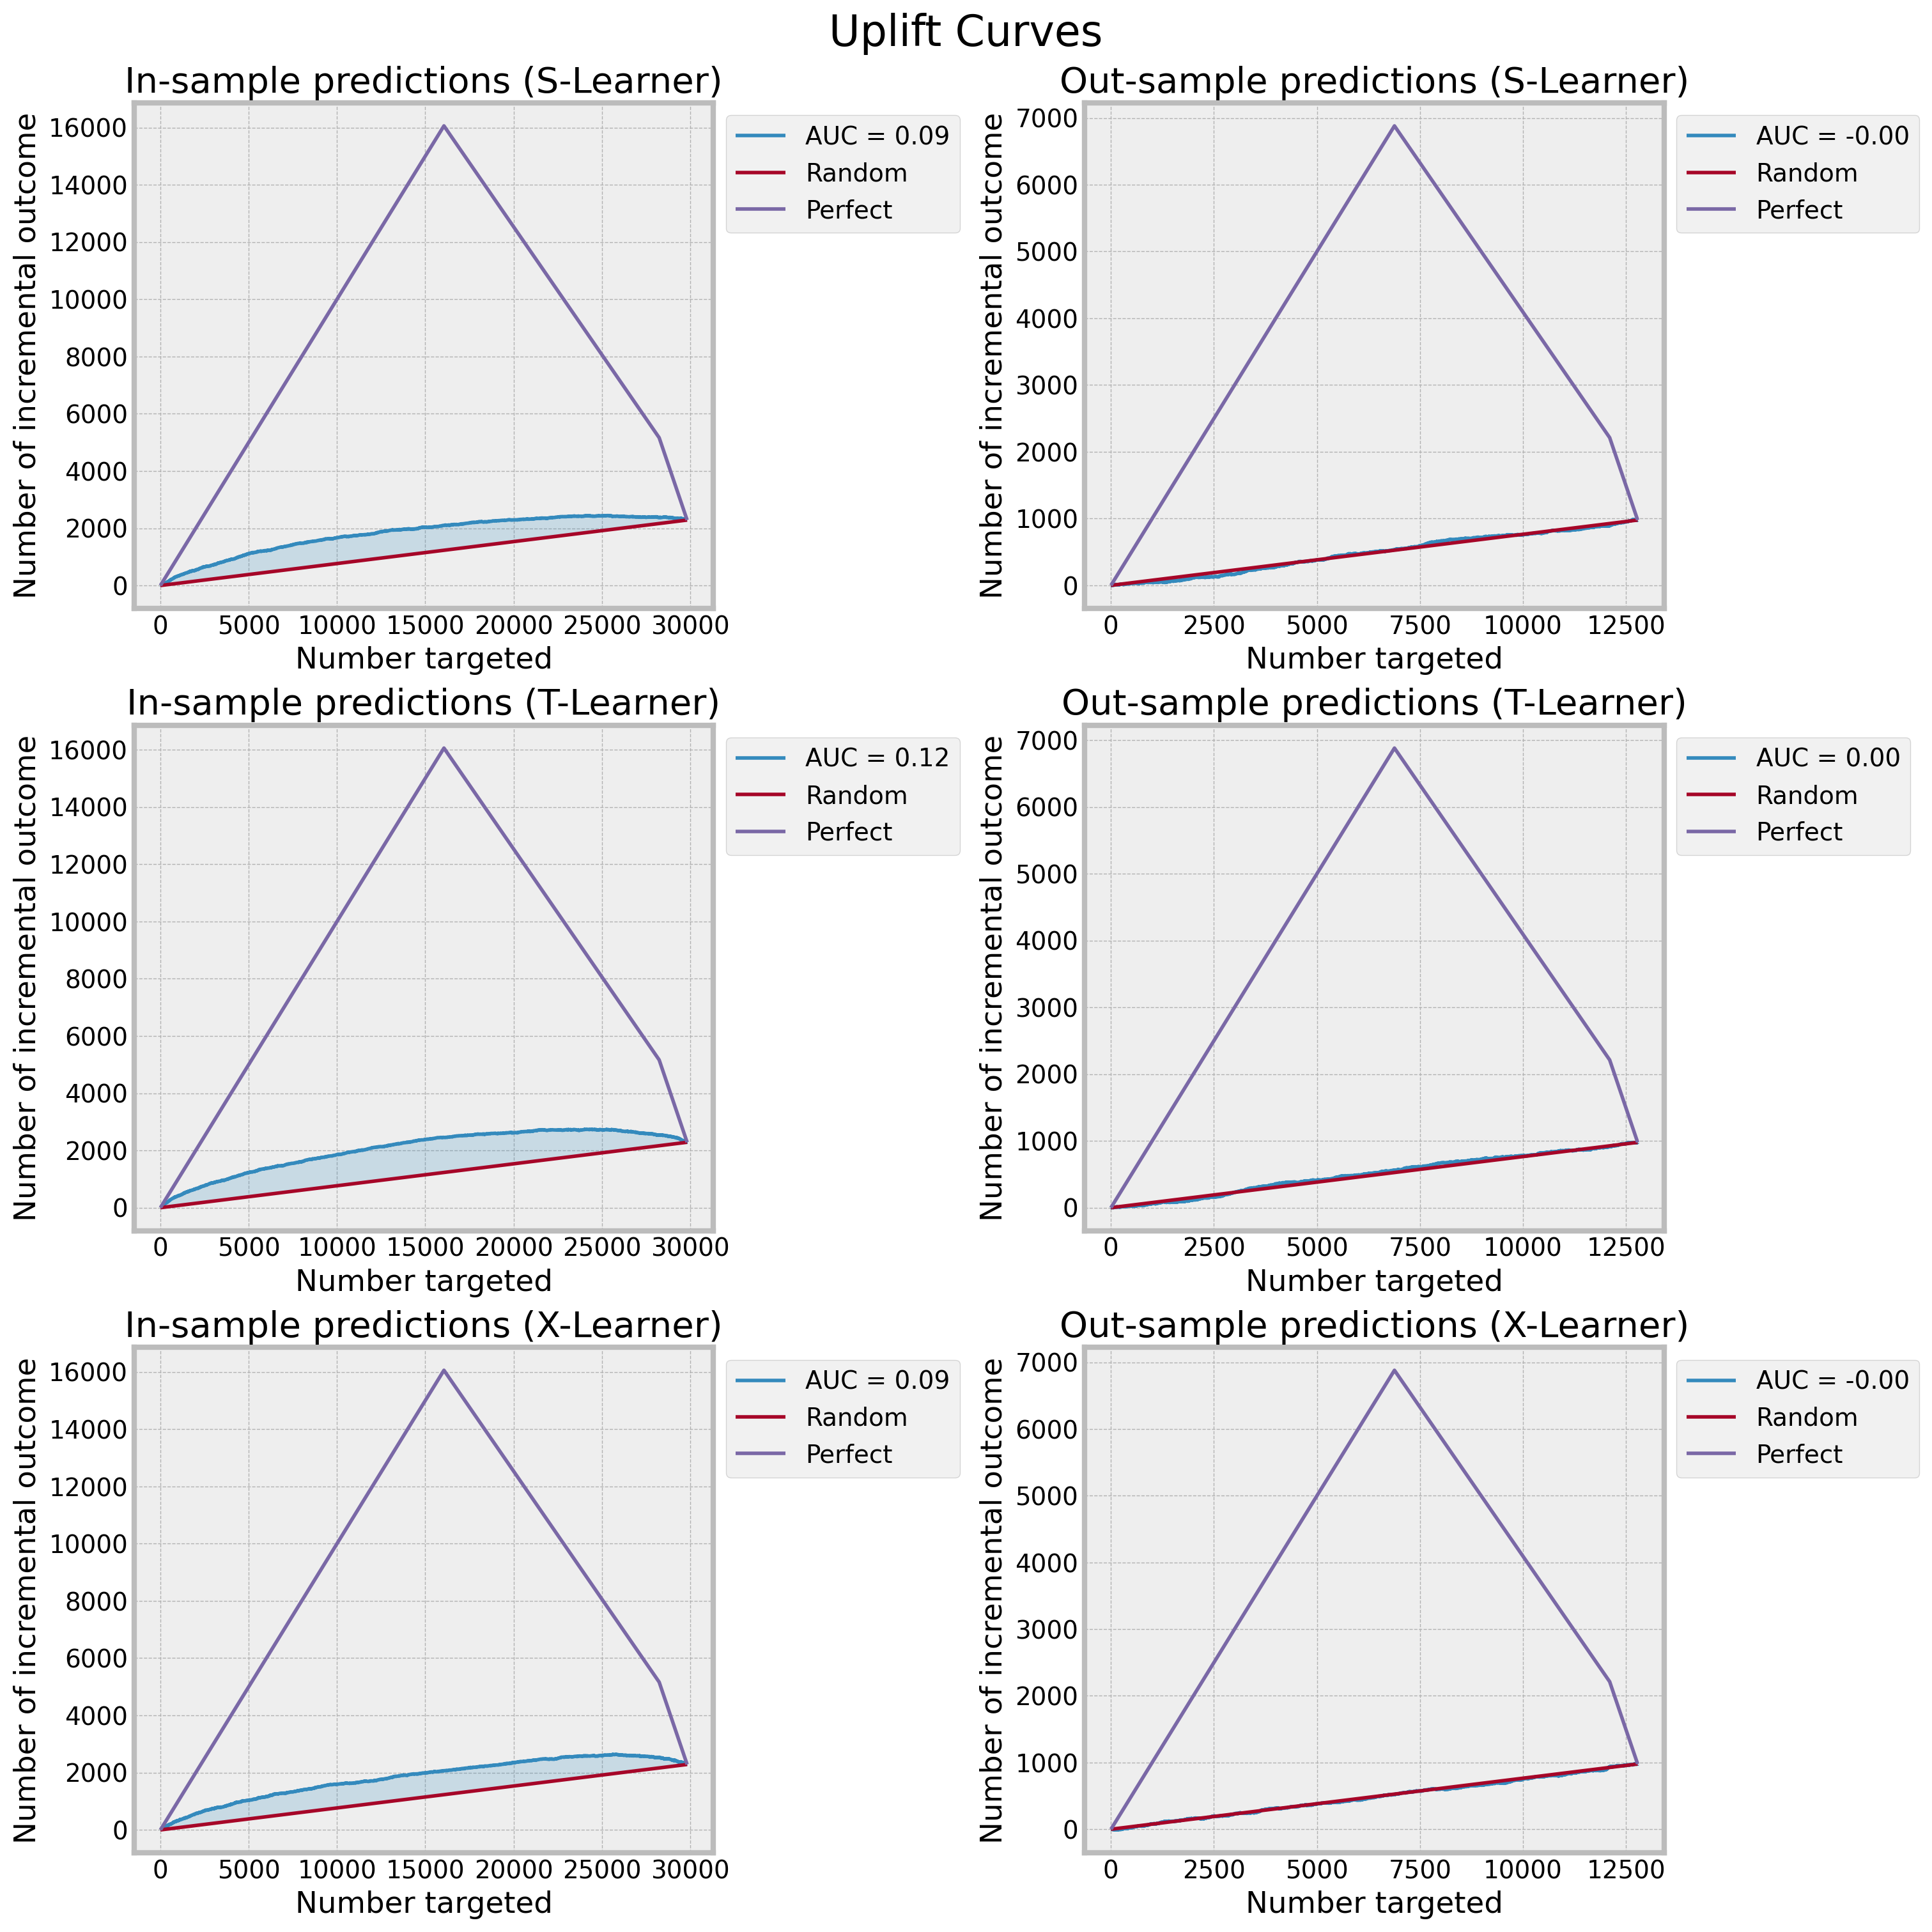

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), layout="constrained")
# in-sample
for i, data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_uplift_curve(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"In-sample predictions ({data_out_train.meta_learner_name})")

# out-of-sample
for j, data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_uplift_curve(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"Out-sample predictions ({data_out_val.meta_learner_name})")

fig.suptitle("Uplift Curves", fontsize=24);

#### Lets do it for BOGO(Buy One Get One)

In [68]:
target_col = "conversion"
treatment_col = "treatment_flg"

y_bogo = df_bogo[target_col]
w_bogo = df_bogo[treatment_col]
x_bogo = df_bogo.drop(columns=[treatment_col, target_col])


idx_train_bogo, idx_val_bogo = train_test_split(
    df_bogo.index,
    test_size=0.3,
    random_state=42,
    stratify=(y_bogo.astype(str) + "_" + w_bogo.astype(str)),
)

x_train_bogo = x_bogo.loc[idx_train_bogo]
x_val_bogo = x_bogo.loc[idx_val_bogo]

w_train_bogo = w_bogo.loc[idx_train_bogo]
w_val_bogo = w_bogo.loc[idx_val_bogo]

y_train_bogo = y_bogo.loc[idx_train_bogo]
y_val_bogo = y_bogo.loc[idx_val_bogo]

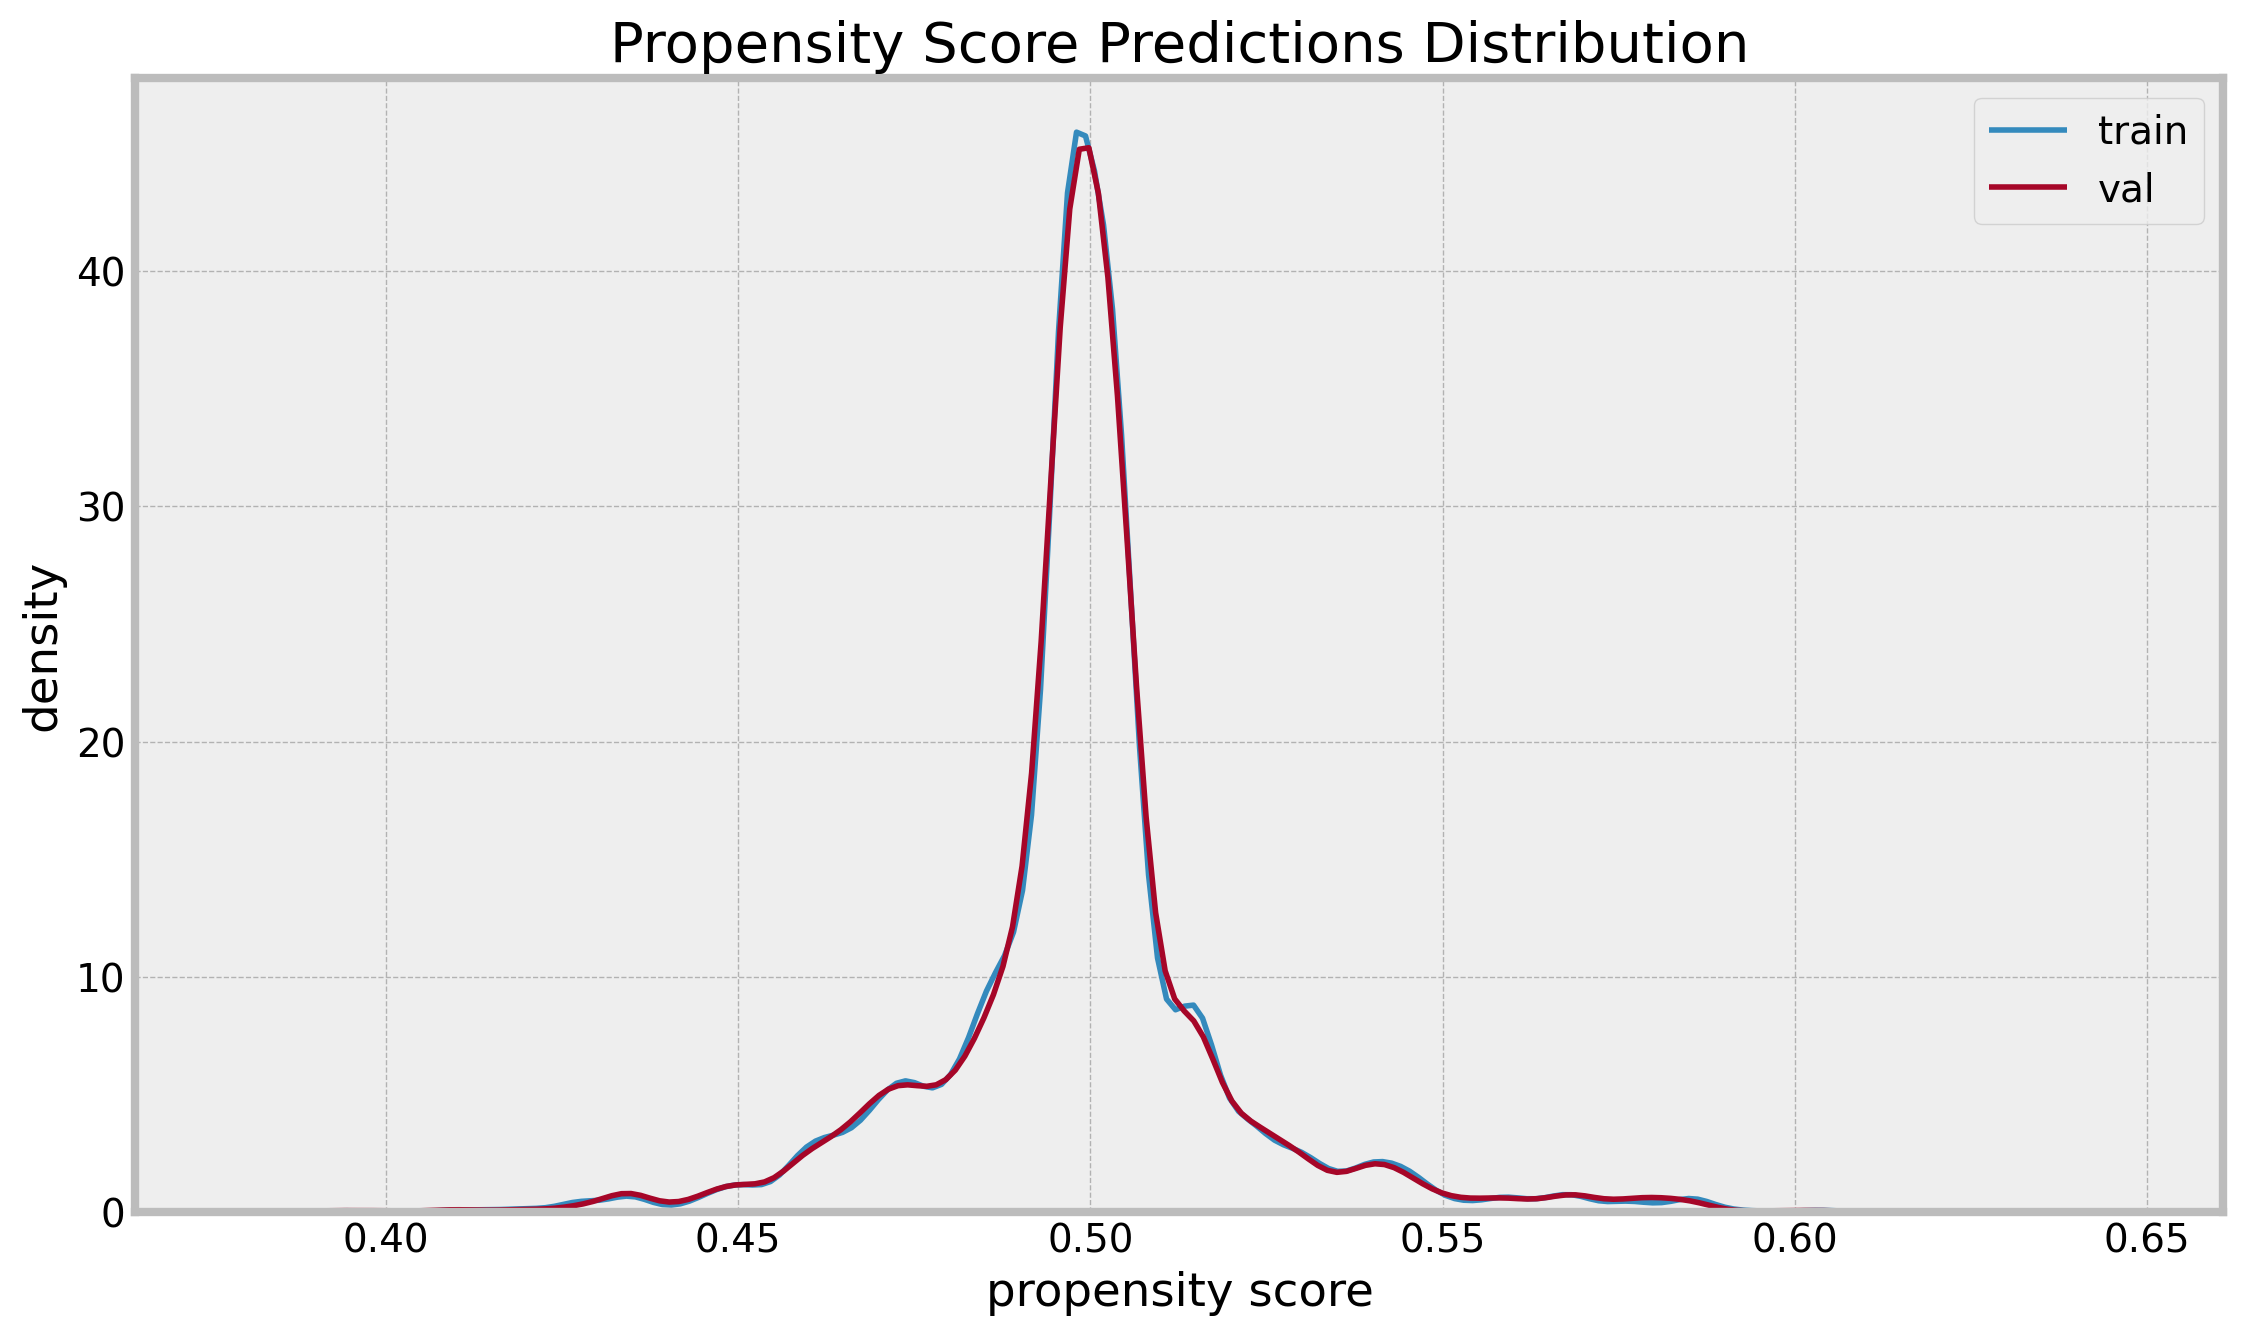

In [69]:
## Lets fit the model 

propensity_model_bogo = HistGradientBoostingClassifier()

propensity_model_bogo.fit(X=x_train_bogo, y=w_train_bogo)
p_train_bogo = propensity_model_bogo.predict_proba(X=x_train_bogo)
p_val_bogo = propensity_model_bogo.predict_proba(X=x_val_bogo)

p_train_bogo = pd.Series(p_train_bogo[:, 0], index=idx_train_bogo)
p_val_bogo = pd.Series(p_val_bogo[:, 0], index=idx_val_bogo)


fig, ax = plt.subplots()
sns.kdeplot(x=p_train_bogo, label="train", ax=ax)
sns.kdeplot(x=p_val_bogo, label="val", ax=ax)
ax.legend()
ax.set(
    title="Propensity Score Predictions Distribution",
    xlabel="propensity score",
    ylabel="density",
);

In [70]:
@dataclass
class DataIn:
    x: pd.DataFrame
    y: pd.Series
    treatment: pd.Series
    p: pd.Series


data_train_bogo = DataIn(
    x=x_train_bogo,
    y=y_train_bogo,
    treatment=w_train_bogo,
    p=p_train_bogo,
)

data_val_bogo = DataIn(
    x=x_val_bogo,
    y=y_val_bogo,
    treatment=w_val_bogo,
    p=p_val_bogo
)

In [71]:
##S-learner model
s_ate_bogo = s_learner.estimate_ate(
    X=data_train_bogo.x, treatment=data_train_bogo.treatment, y=data_train_bogo.y)

##T-learner model
t_ate_lwr_bogo, t_ate_bogo, t_ate_upr_bogo = t_learner.estimate_ate(
    X=data_train_bogo.x, treatment=data_train_bogo.treatment, y=data_train_bogo.y
)

##X-learner model
x_ate_lwr_bogo, x_ate_bogo, x_ate_upr_bogo = x_learner.estimate_ate(
    X=data_train_bogo.x,
    treatment=data_train_bogo.treatment,
    y=data_train_bogo.y,
    p=data_train_bogo.p,

)



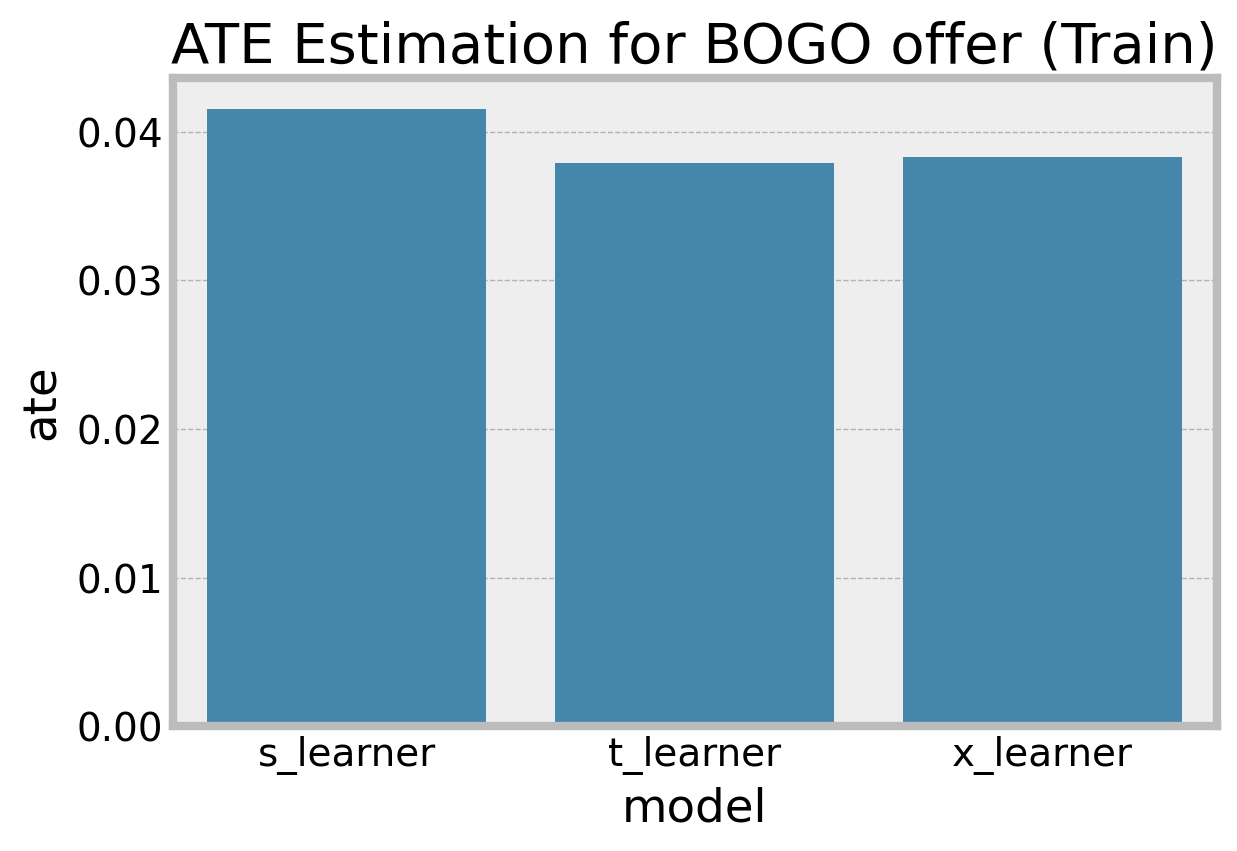

In [73]:
fig, ax = plt.subplots(figsize=(6, 4))

pd.DataFrame(
    data={
        "model": ["s_learner", "t_learner", "x_learner"],
        "ate": np.array([s_ate_bogo, t_ate_bogo, x_ate_bogo]).flatten(),
    },
).pipe((sns.barplot, "data"), x="model", y="ate", ax=ax)
ax.set(title="ATE Estimation for BOGO offer (Train)");

In [74]:
@dataclass
class DataOut:
    meta_learner_name: str
    meta_learner: BaseLearner
    y_pred: np.array


# in-sample predictions
bogo_data_out_train_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
        X=data_train_bogo.x, treatment=data_train_bogo.treatment
    ),
)
bogo_data_out_train_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
        X=data_train_bogo.x, treatment=data_train_bogo.treatment
    ),
)
bogo_data_out_train_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_train_bogo.x, treatment=data_train_bogo.treatment, p=data_train_bogo.p
    ),
)
# out-of-sample predictions
bogo_data_out_val_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
      X=data_val_bogo.x, treatment=data_val_bogo.treatment
    ),
)
bogo_data_out_val_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
      X=data_val_bogo.x, treatment=data_val_bogo.treatment
    ),
)
bogo_data_out_val_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_val_bogo.x, treatment=data_val_bogo.treatment, p=data_val_bogo.p
    ),
)

X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names


#### Uplift of the conversion by BOGO offer 

In [75]:
bogo_uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train_bogo.y,
    uplift=bogo_data_out_train_s.y_pred.flatten(),
    treatment=data_train_bogo.treatment,
    strategy="overall",
    total=True,
)

bogo_uplift_by_percentile_df




Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


n_treatment  n_control  response_rate_treatment  \
percentile                                                    
0-10               1520       1469                 0.311842   
10-20              1485       1504                 0.214815   
20-30              1499       1490                 0.171448   
30-40              1477       1512                 0.132024   
40-50              1488       1501                 0.147177   
50-60              1494       1494                 0.130522   
60-70              1487       1501                 0.084062   
70-80              1503       1485                 0.108450   
80-90              1519       1469                 0.105991   
90-100             1499       1489                 0.106071   
total             14971      14914                 0.151426   

            response_rate_control    uplift  
percentile                                   
0-10                     0.083730  0.228112  
10-20                    0.091090  0.123724  
20-30                    0.095973  0.075474  
30-40                    0.080026  0.051998  
40-50                    0.110593  0.036584  
50-60                    0.083668  0.046854  
60-70                    0.079280  0.004781  
70-80                    0.099663  0.008786  
80-90                    0.122532 -0.016542  
90-100                   0.215581 -0.109510  
total                    0.106142  0.045284

#### Let the check the Uplift by percent for each Learner on In and Out samples 

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


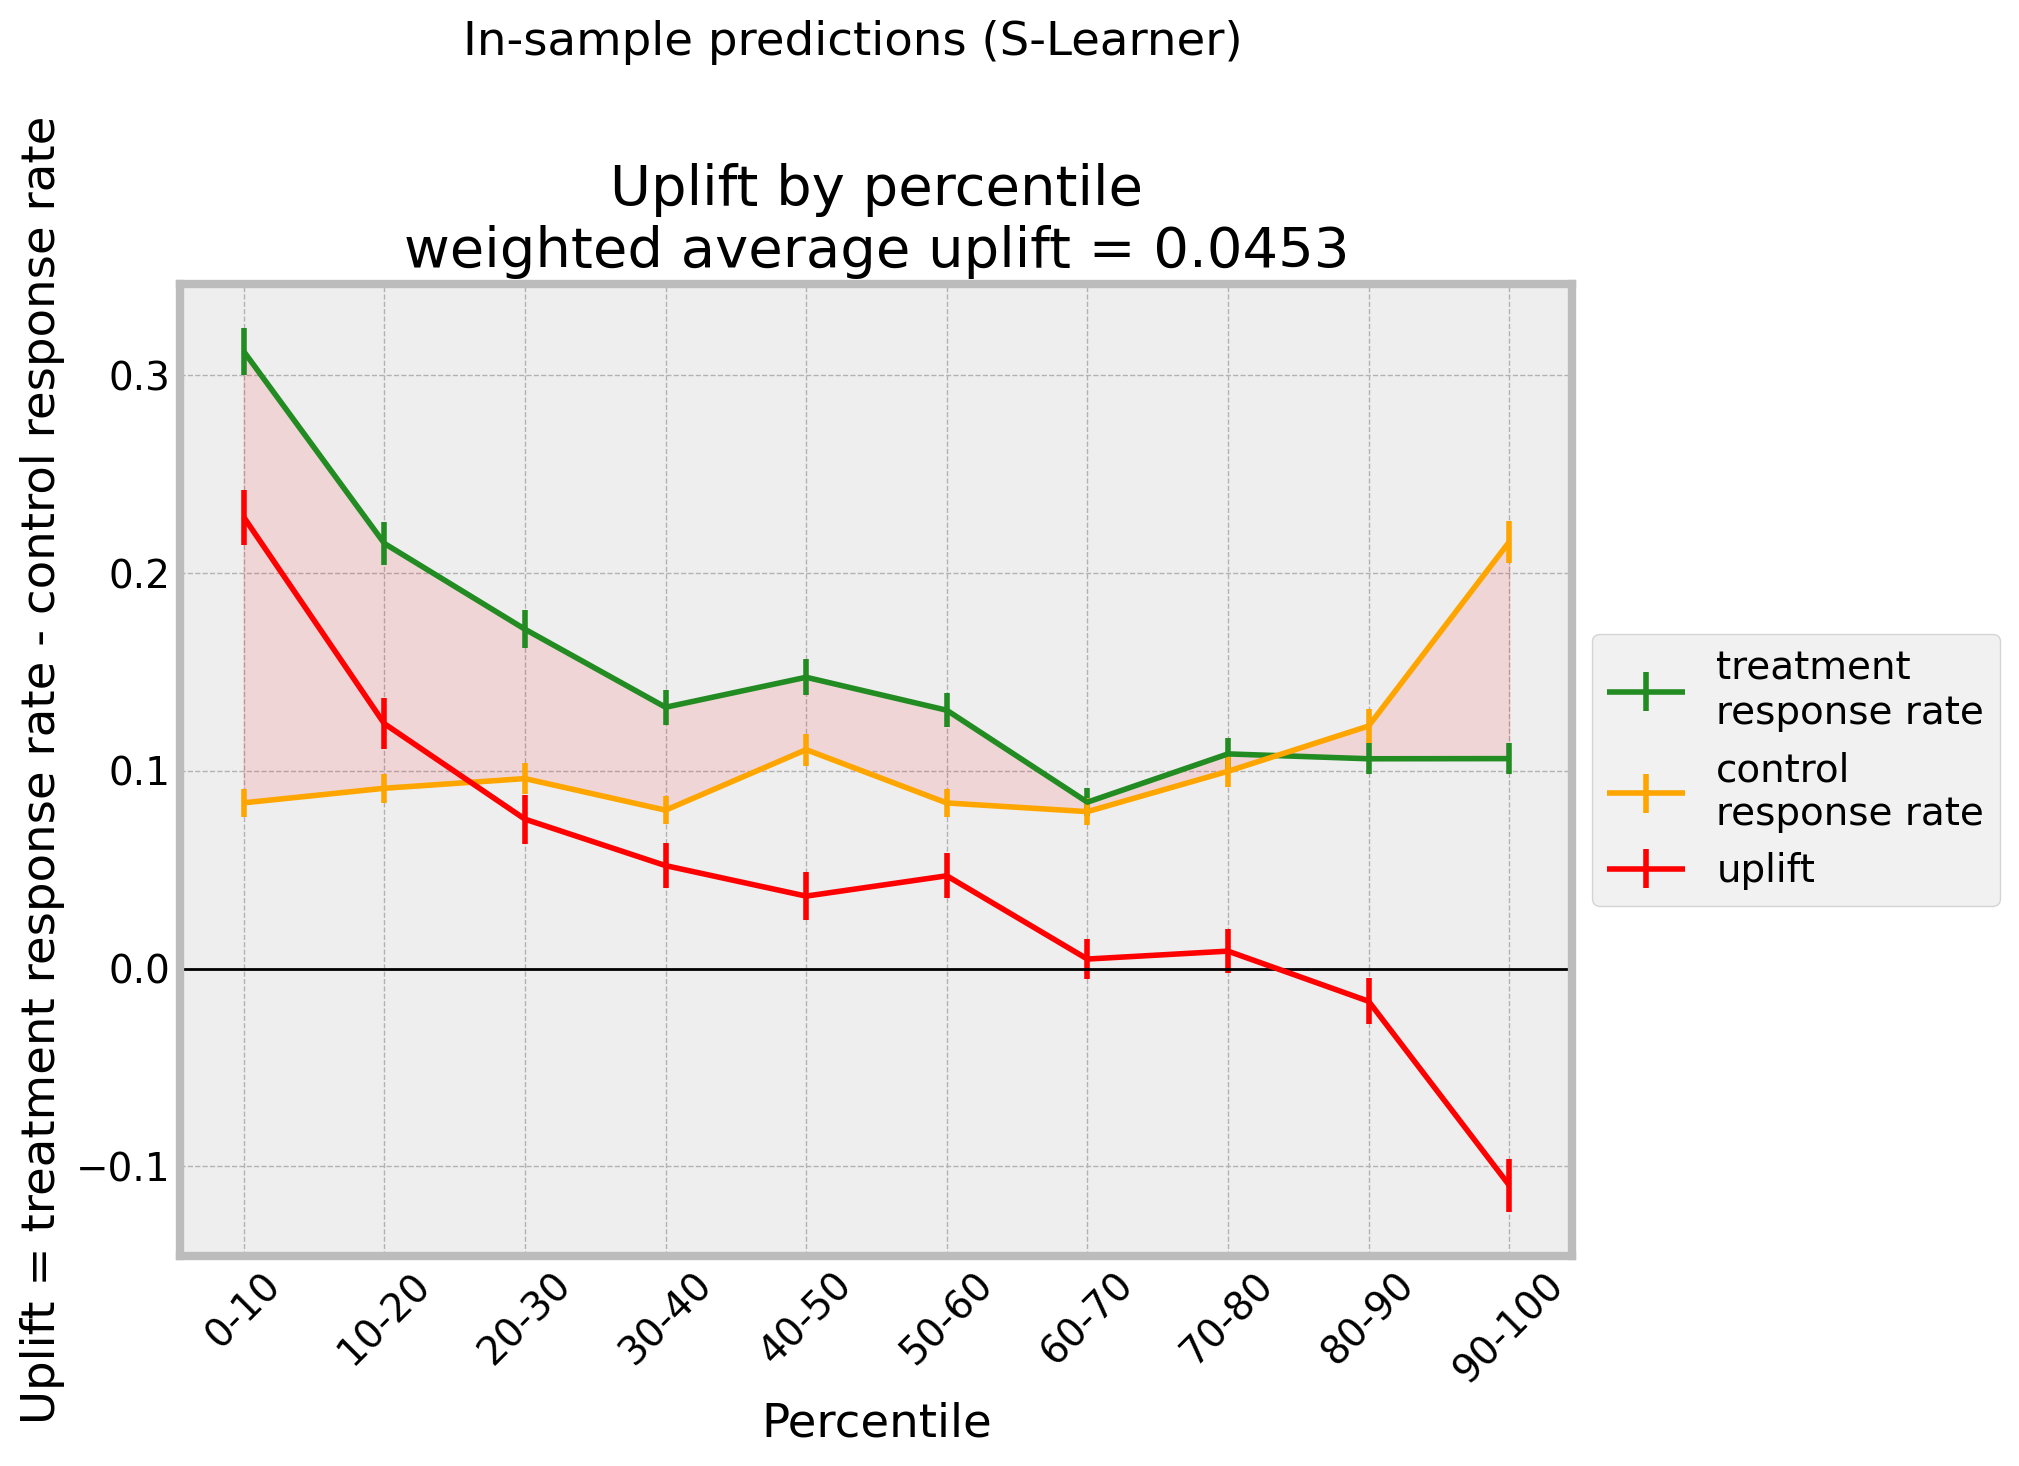

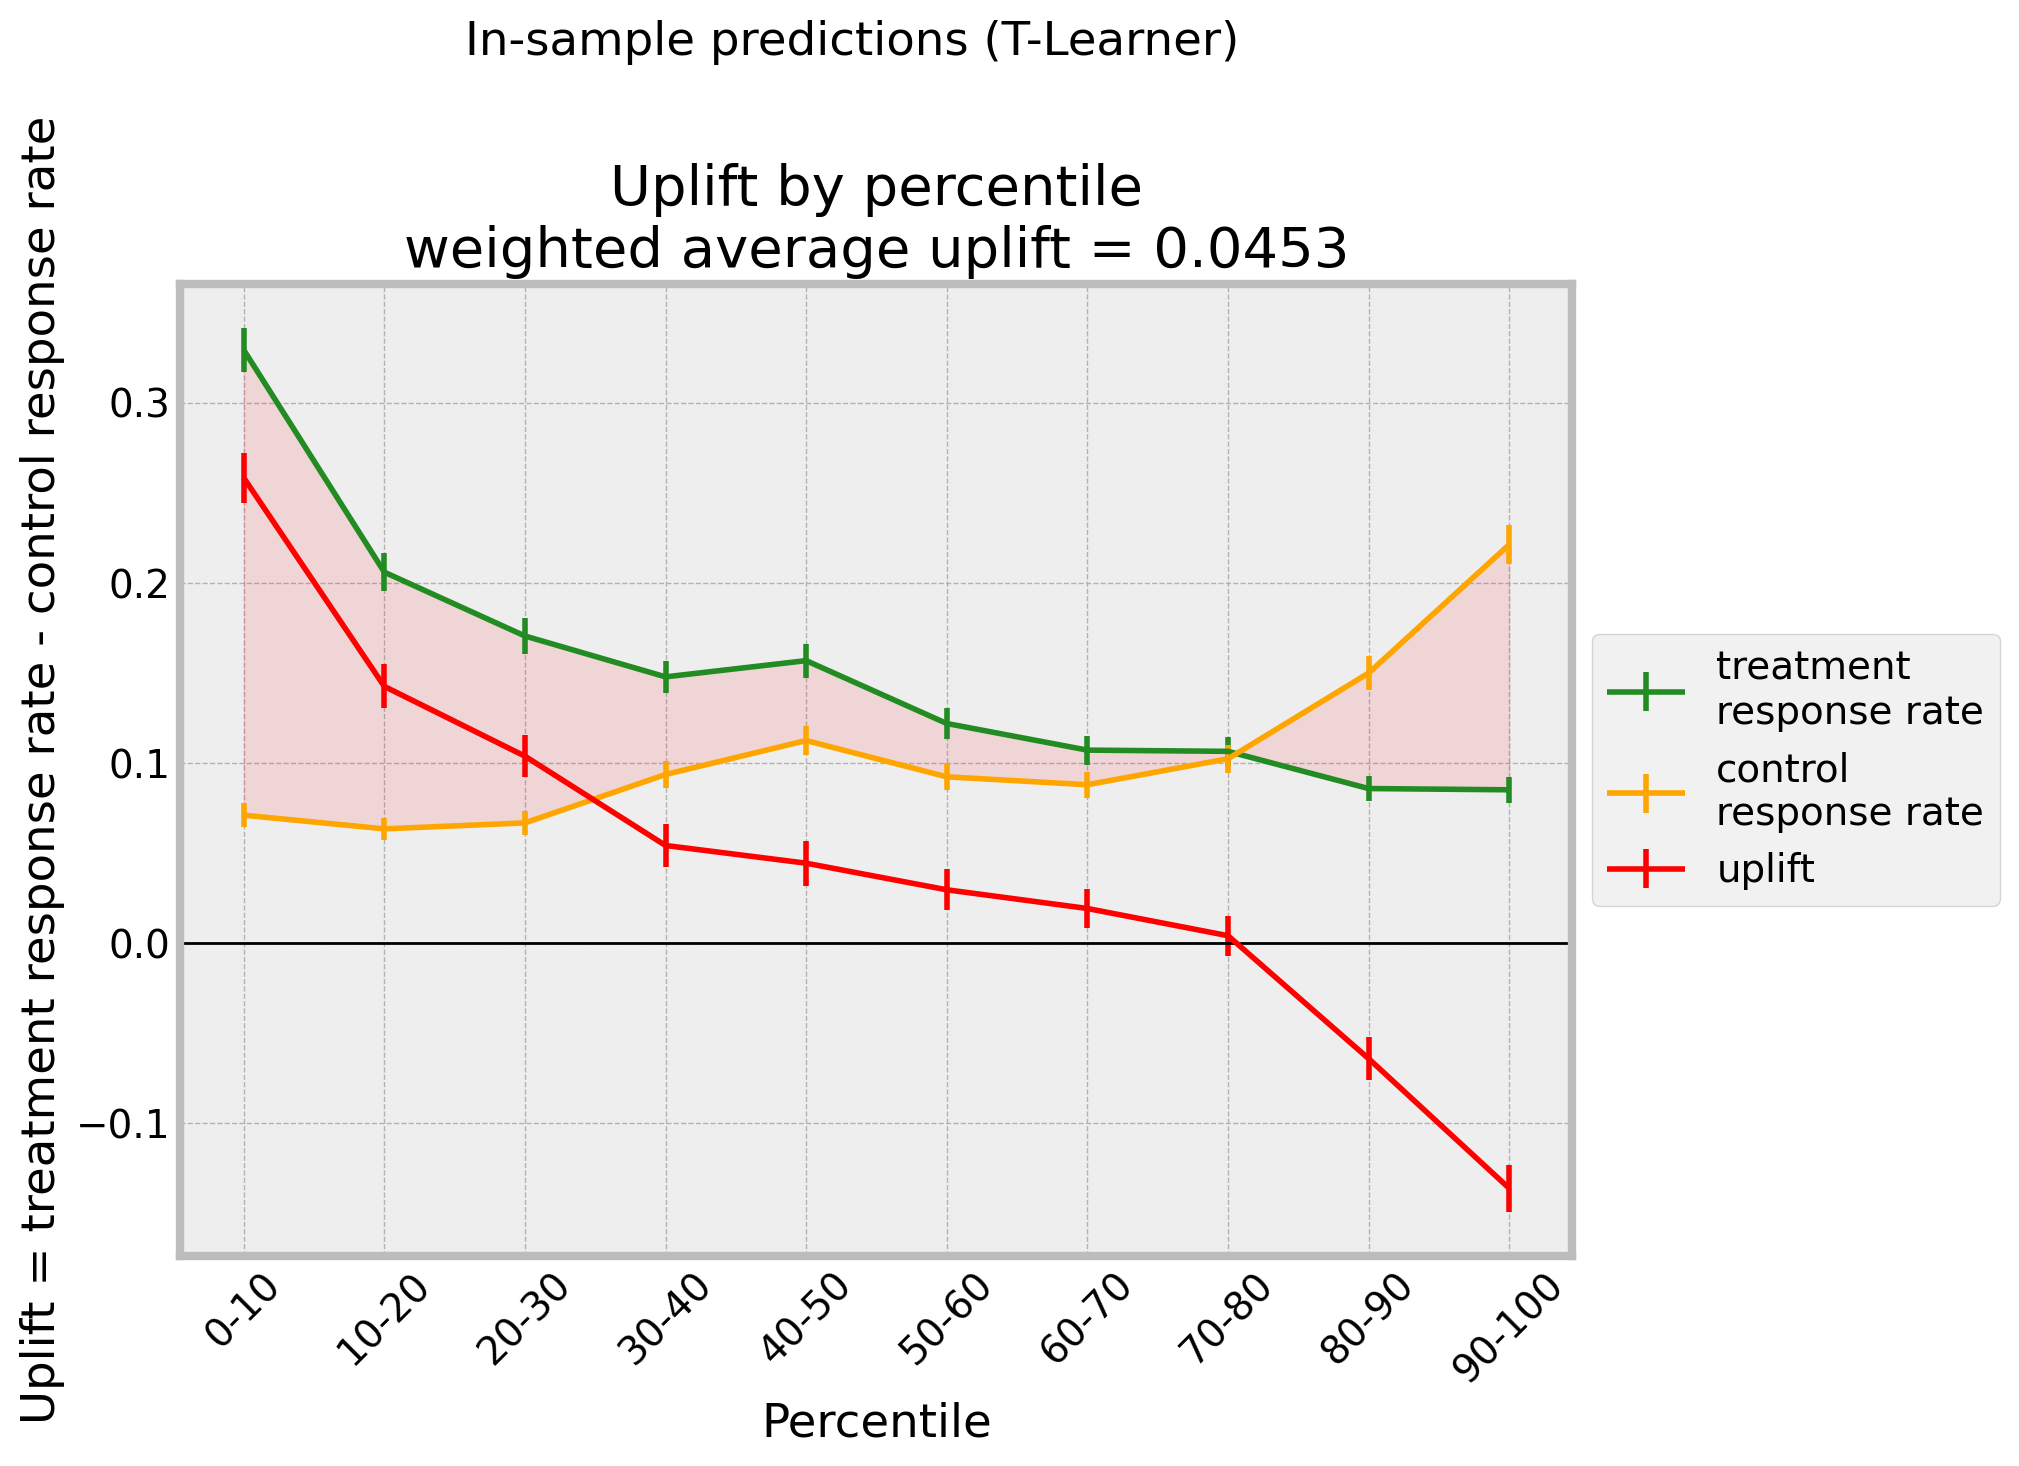

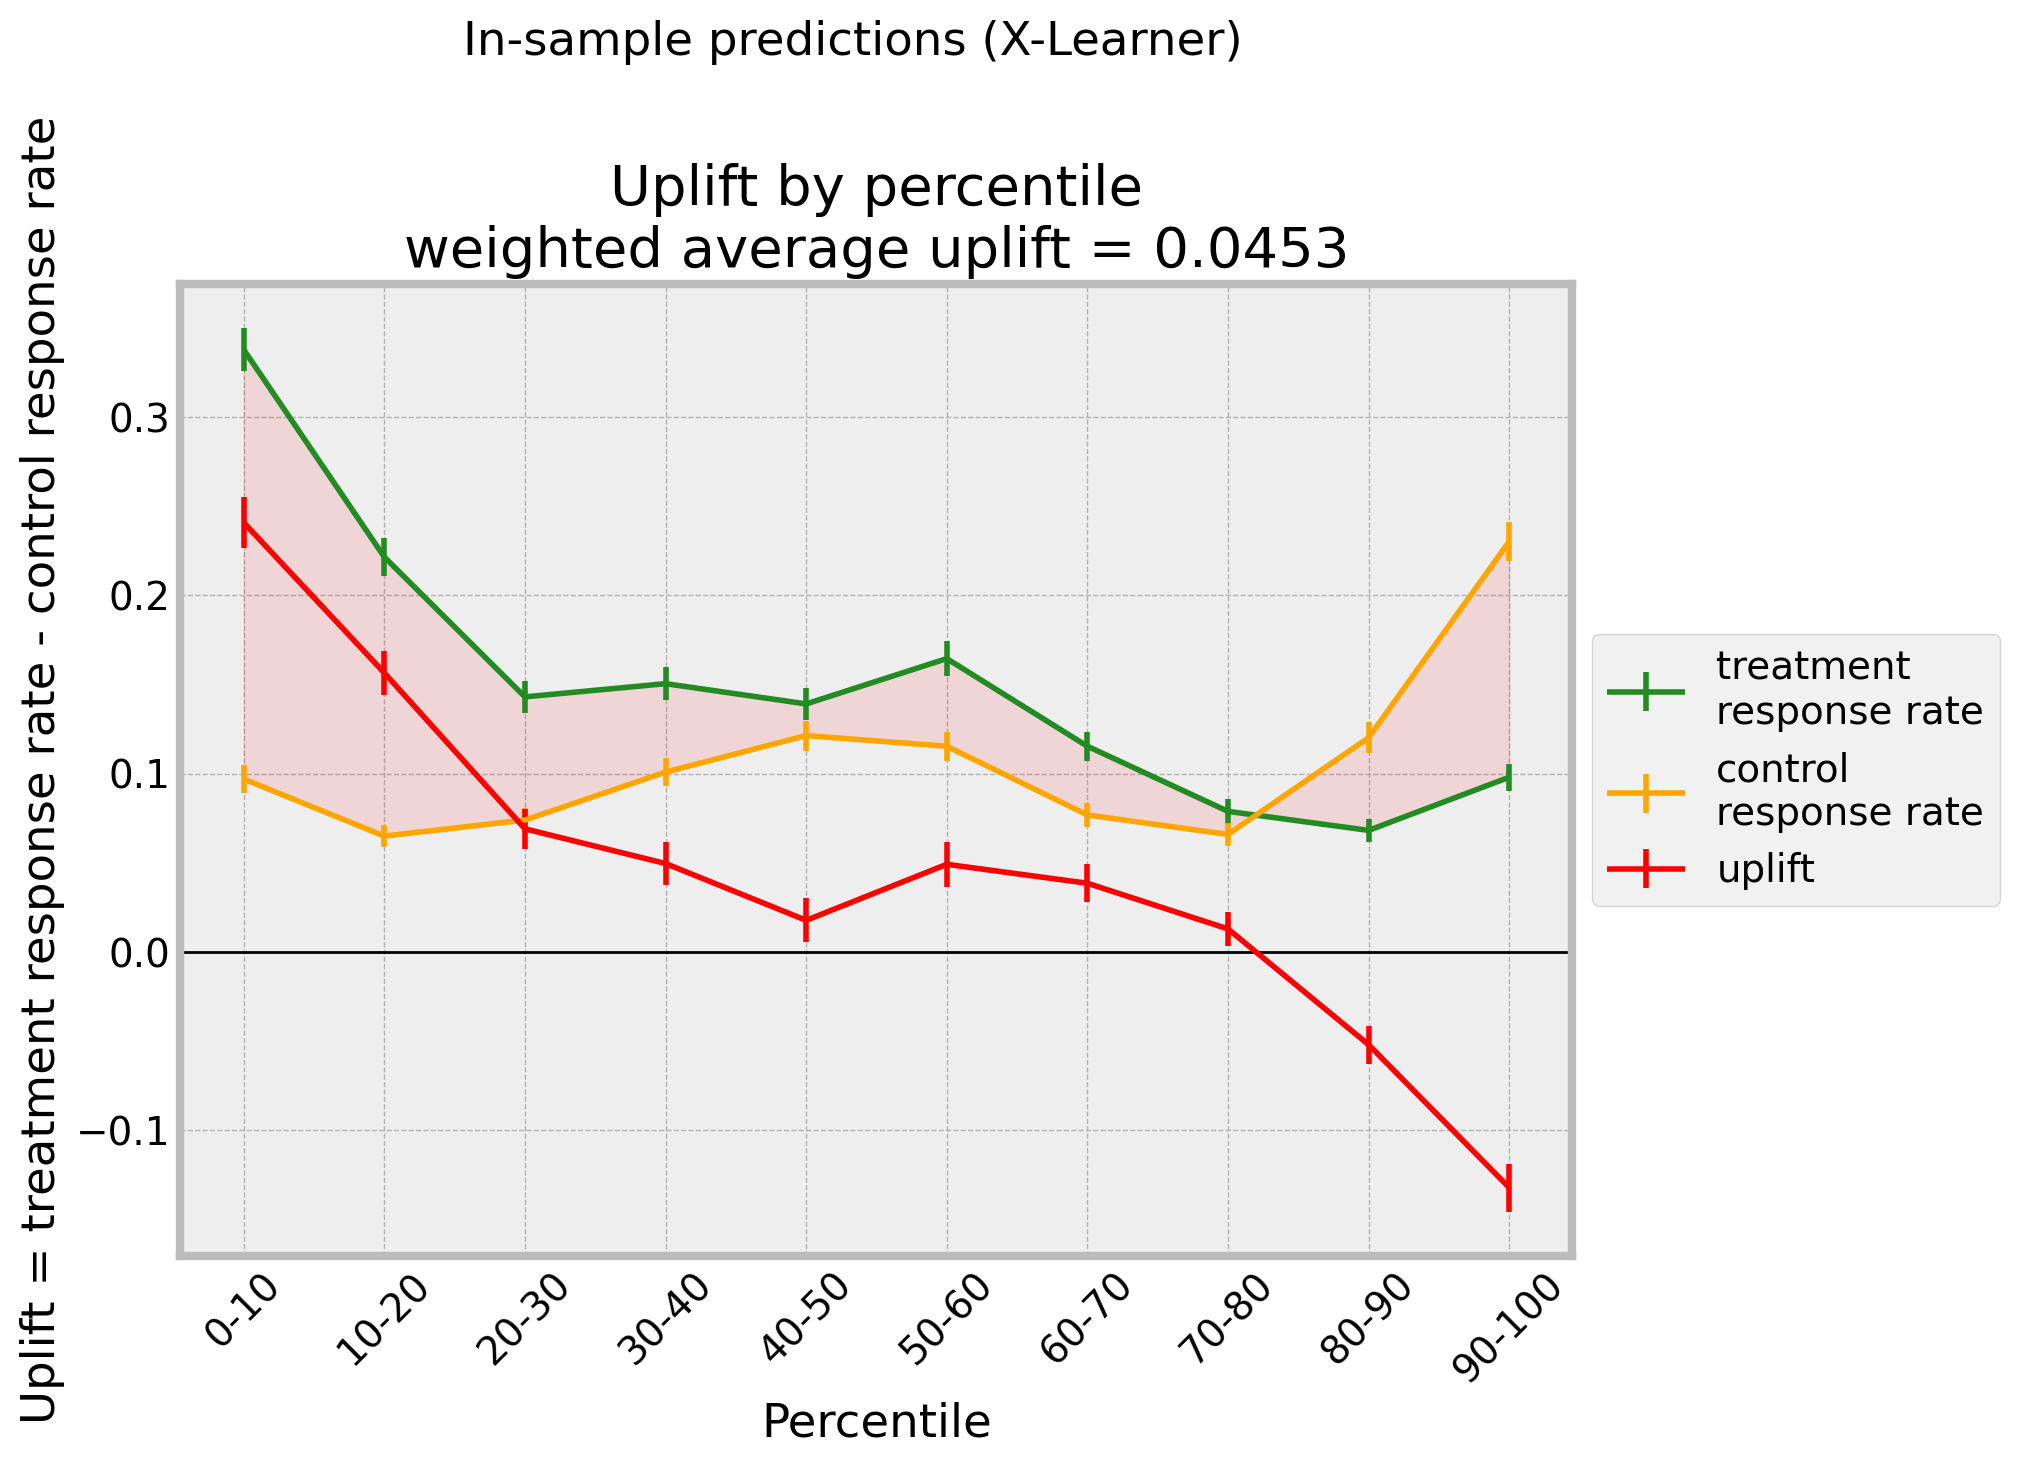

In [76]:
train_pred = [bogo_data_out_train_s, bogo_data_out_train_t, bogo_data_out_train_x]

for data_out_train in train_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_train_bogo.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train_bogo.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(
      f"In-sample predictions ({data_out_train.meta_learner_name})", y=1.1
    )

#### Out of Smaple Uplift percent

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


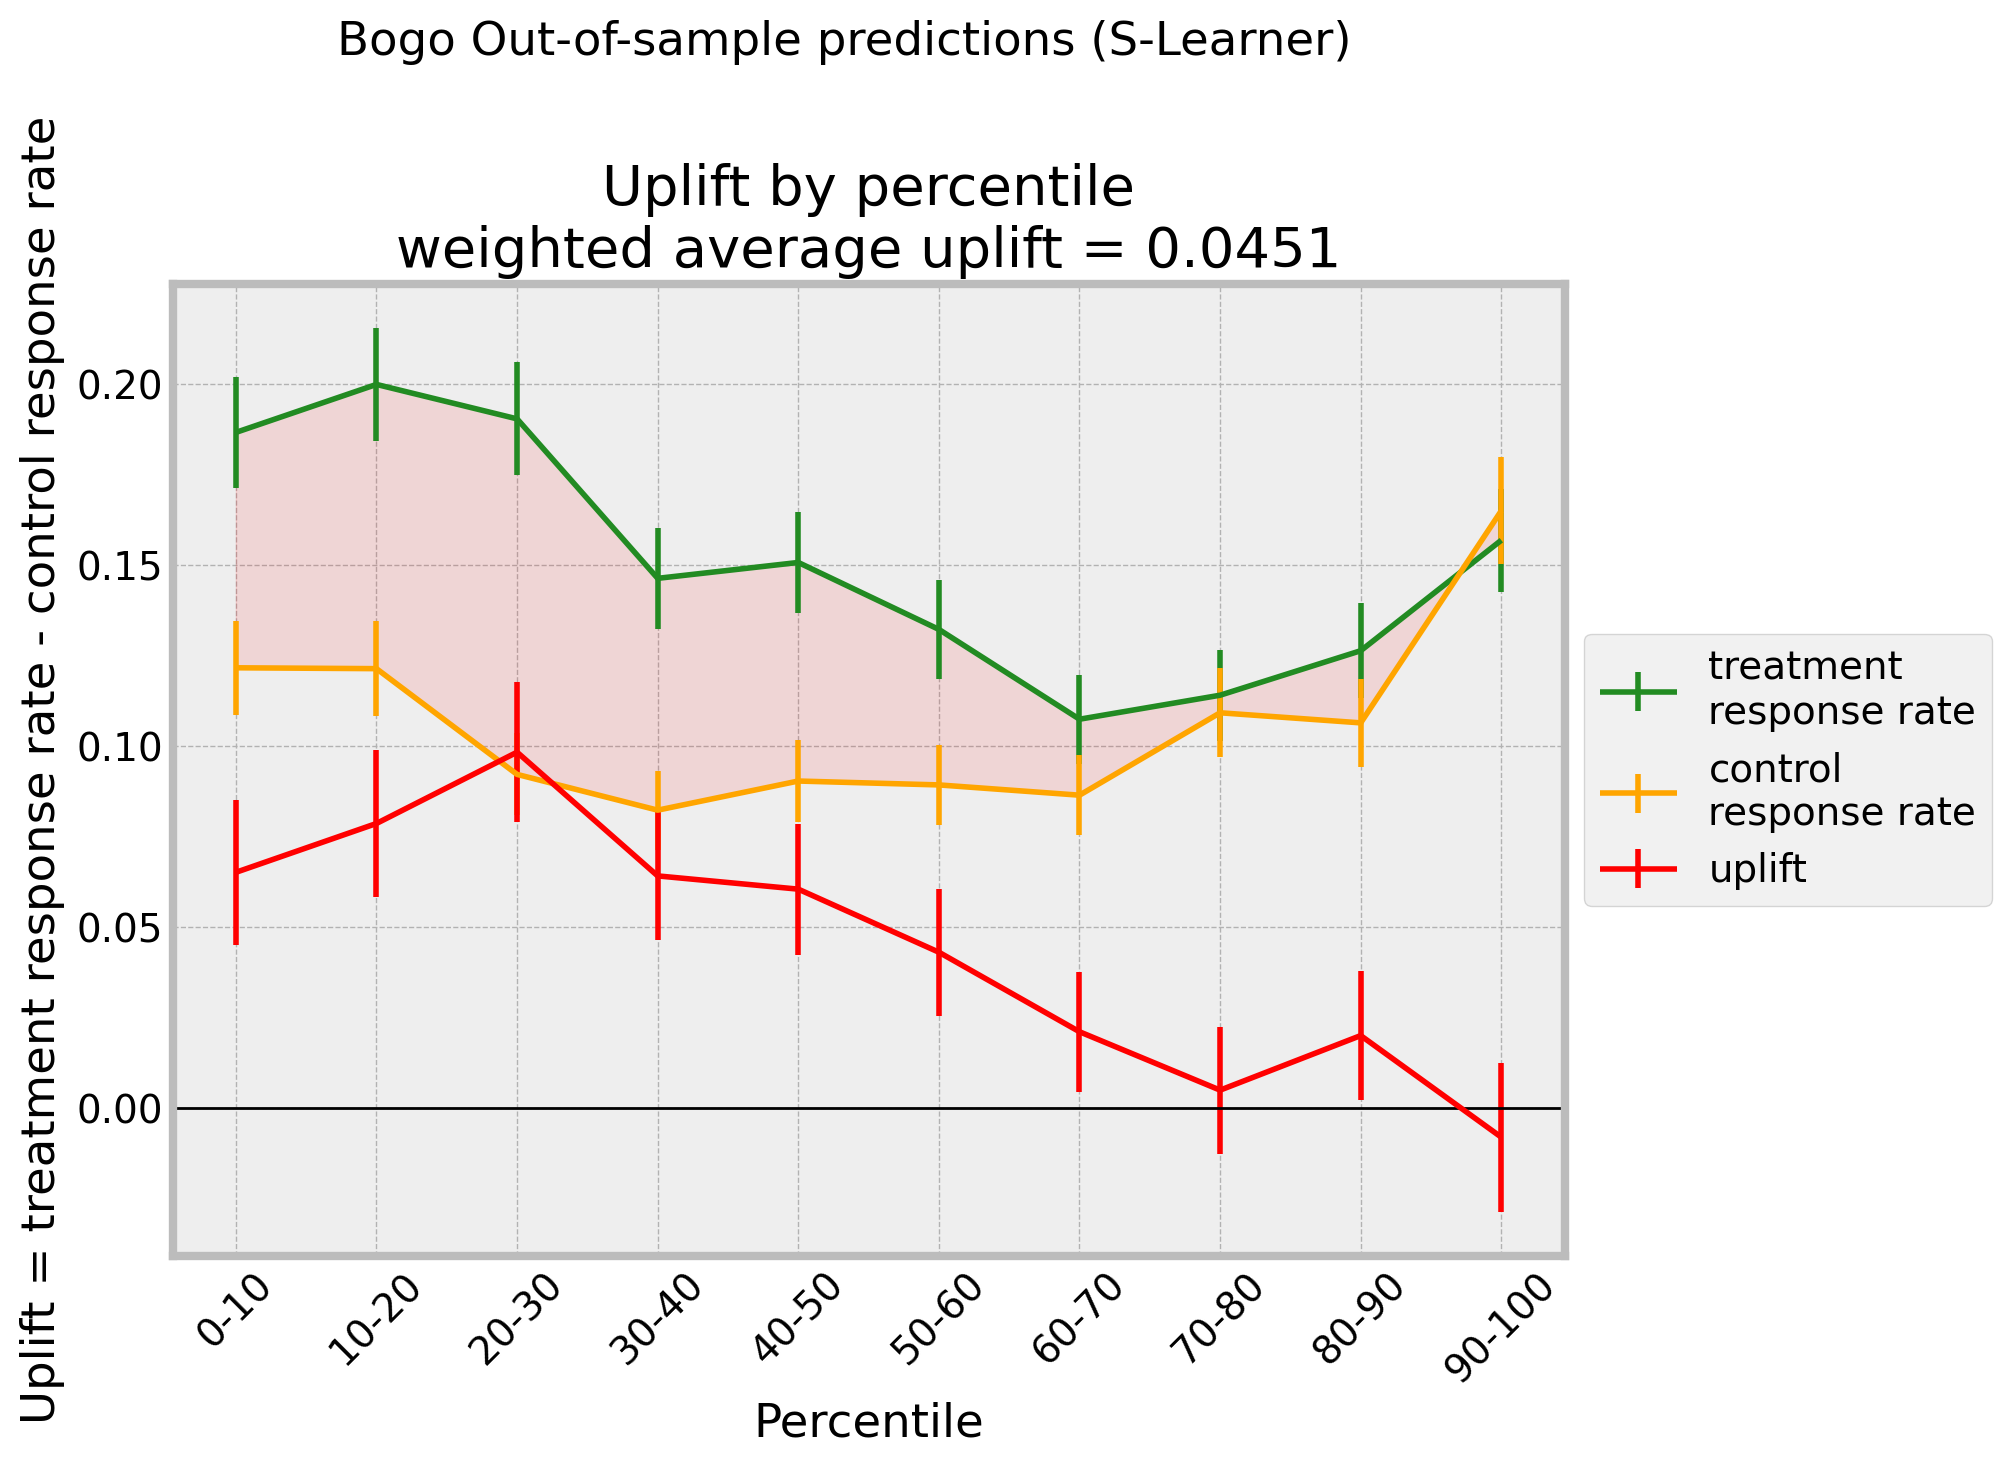

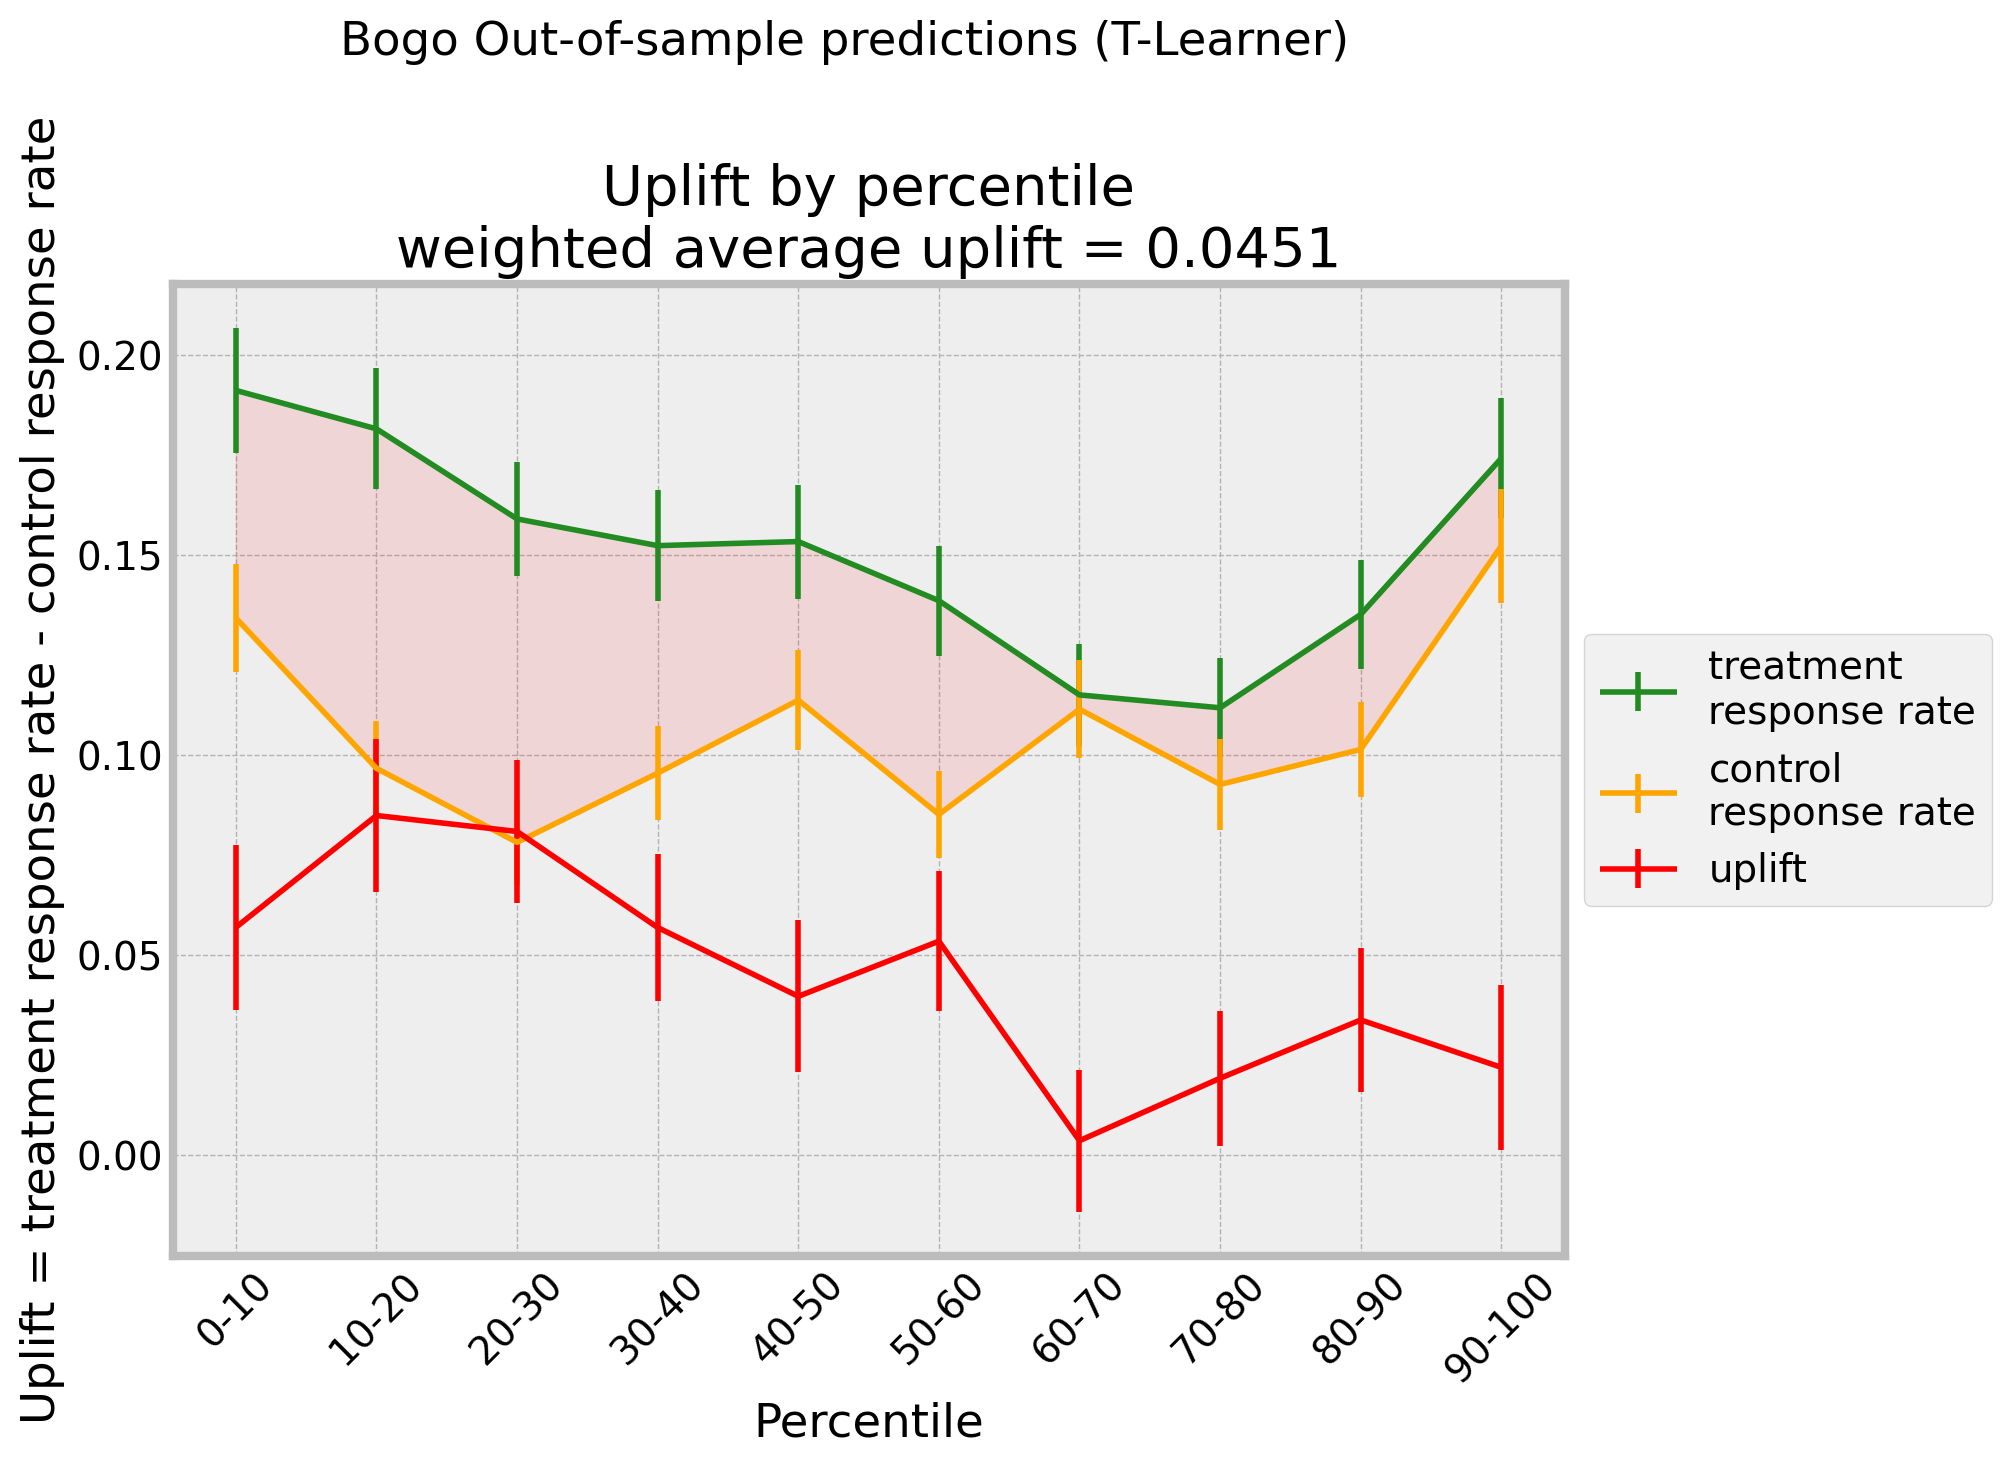

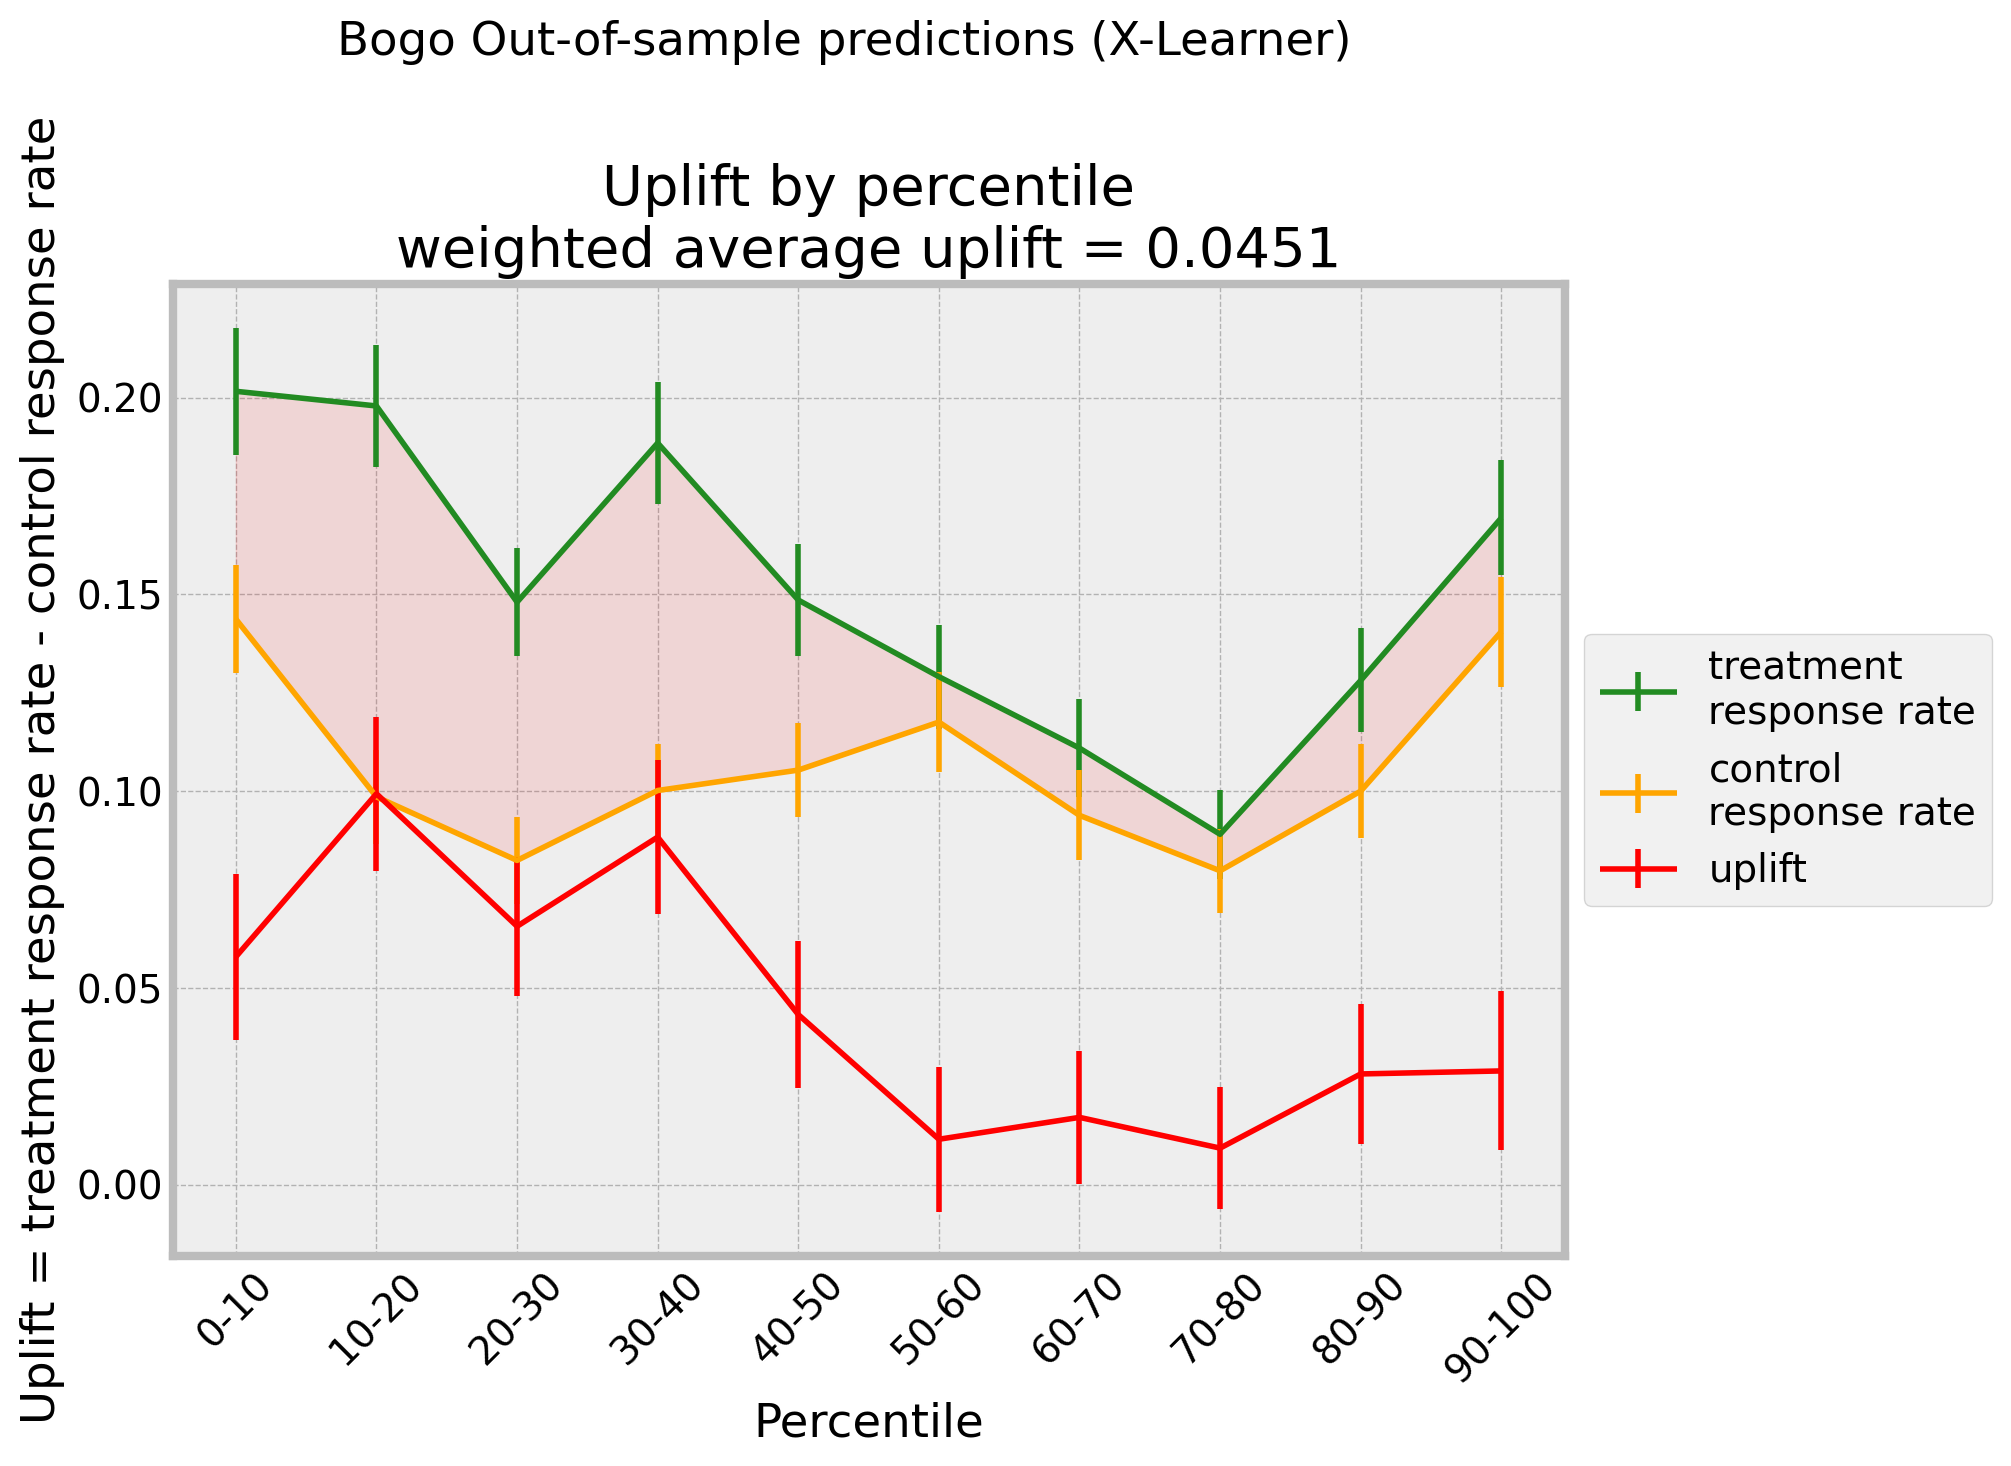

In [77]:
val_pred = [bogo_data_out_val_s, bogo_data_out_val_t, bogo_data_out_val_x]

for data_out_val in val_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_val_bogo.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val_bogo.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(
      f"Bogo Out-of-sample predictions ({data_out_val.meta_learner_name})", y=1.1
    )

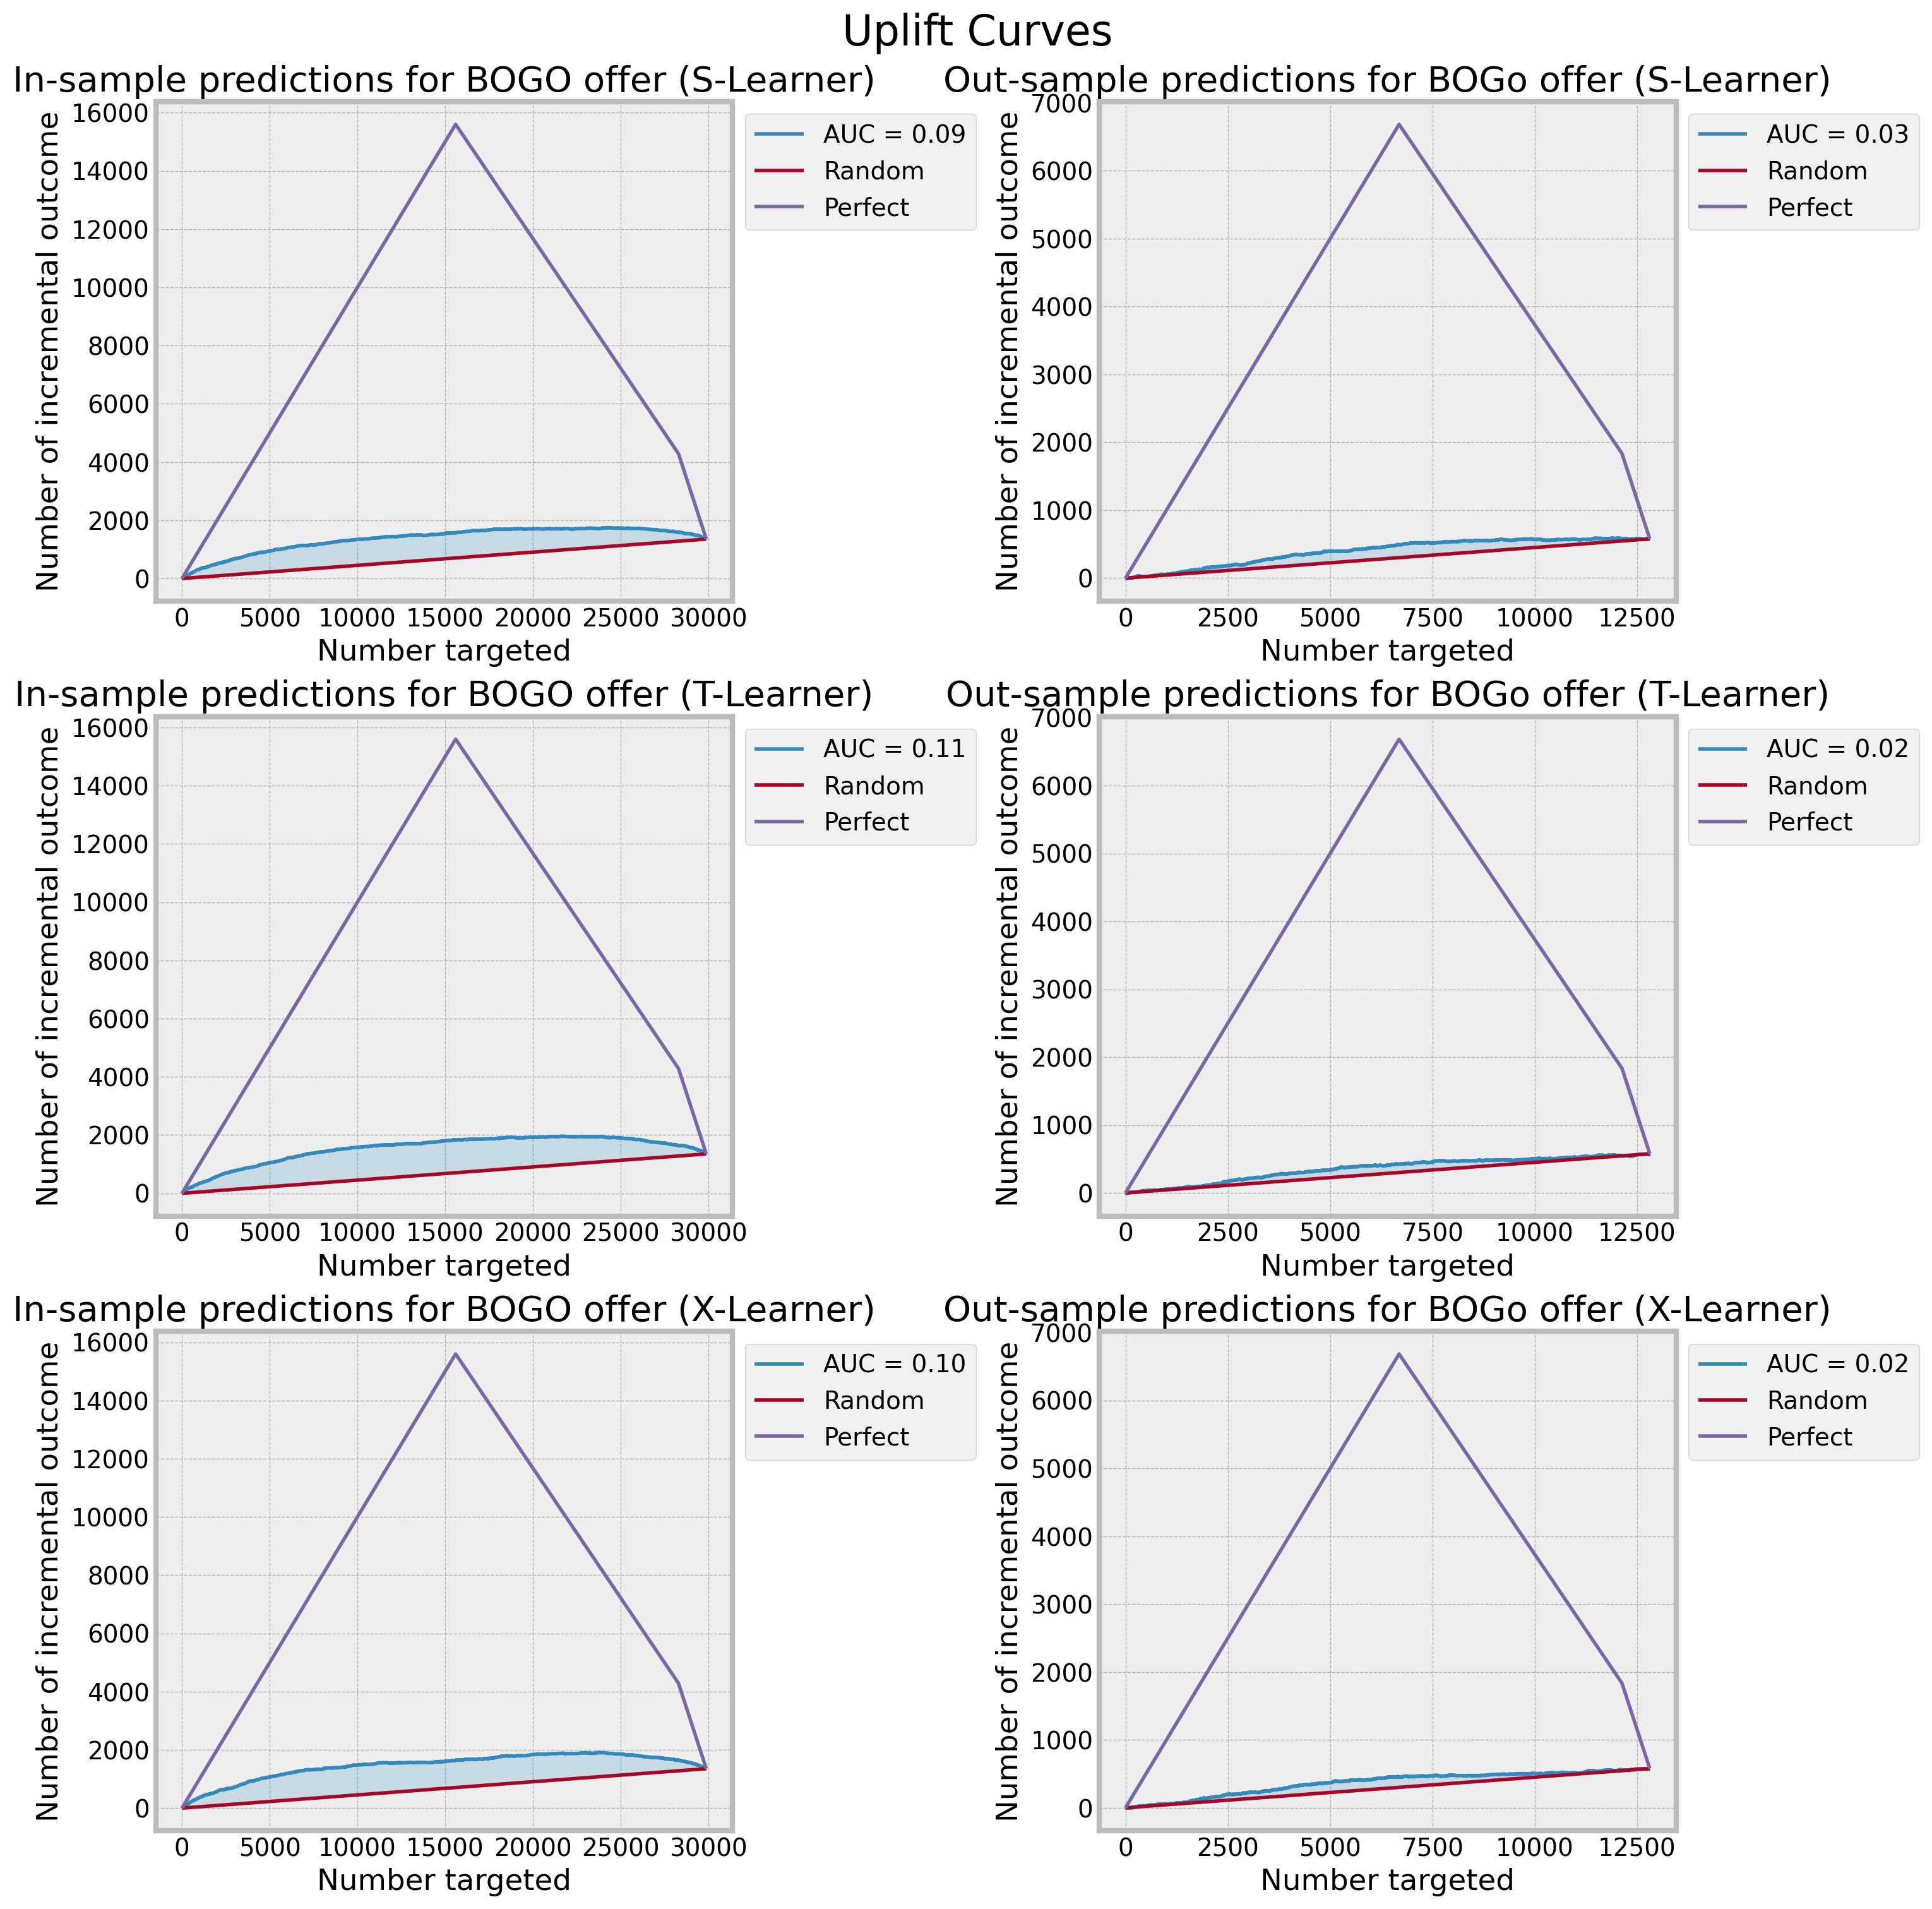

In [79]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), layout="constrained")
# in-sample
for i, bogo_data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_uplift_curve(
        y_true=data_train_bogo.y,
        uplift=bogo_data_out_train.y_pred.flatten(),
        treatment=data_train_bogo.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"In-sample predictions for BOGO offer ({bogo_data_out_train.meta_learner_name})")

# out-of-sample
for j, bogo_data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_uplift_curve(
        y_true=data_val_bogo.y,
        uplift=bogo_data_out_val.y_pred.flatten(),
        treatment=data_val_bogo.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"Out-sample predictions for BOGo offer ({bogo_data_out_val.meta_learner_name})")

fig.suptitle("Uplift Curves", fontsize=24);

#### Culatimave gain on In Sample data 

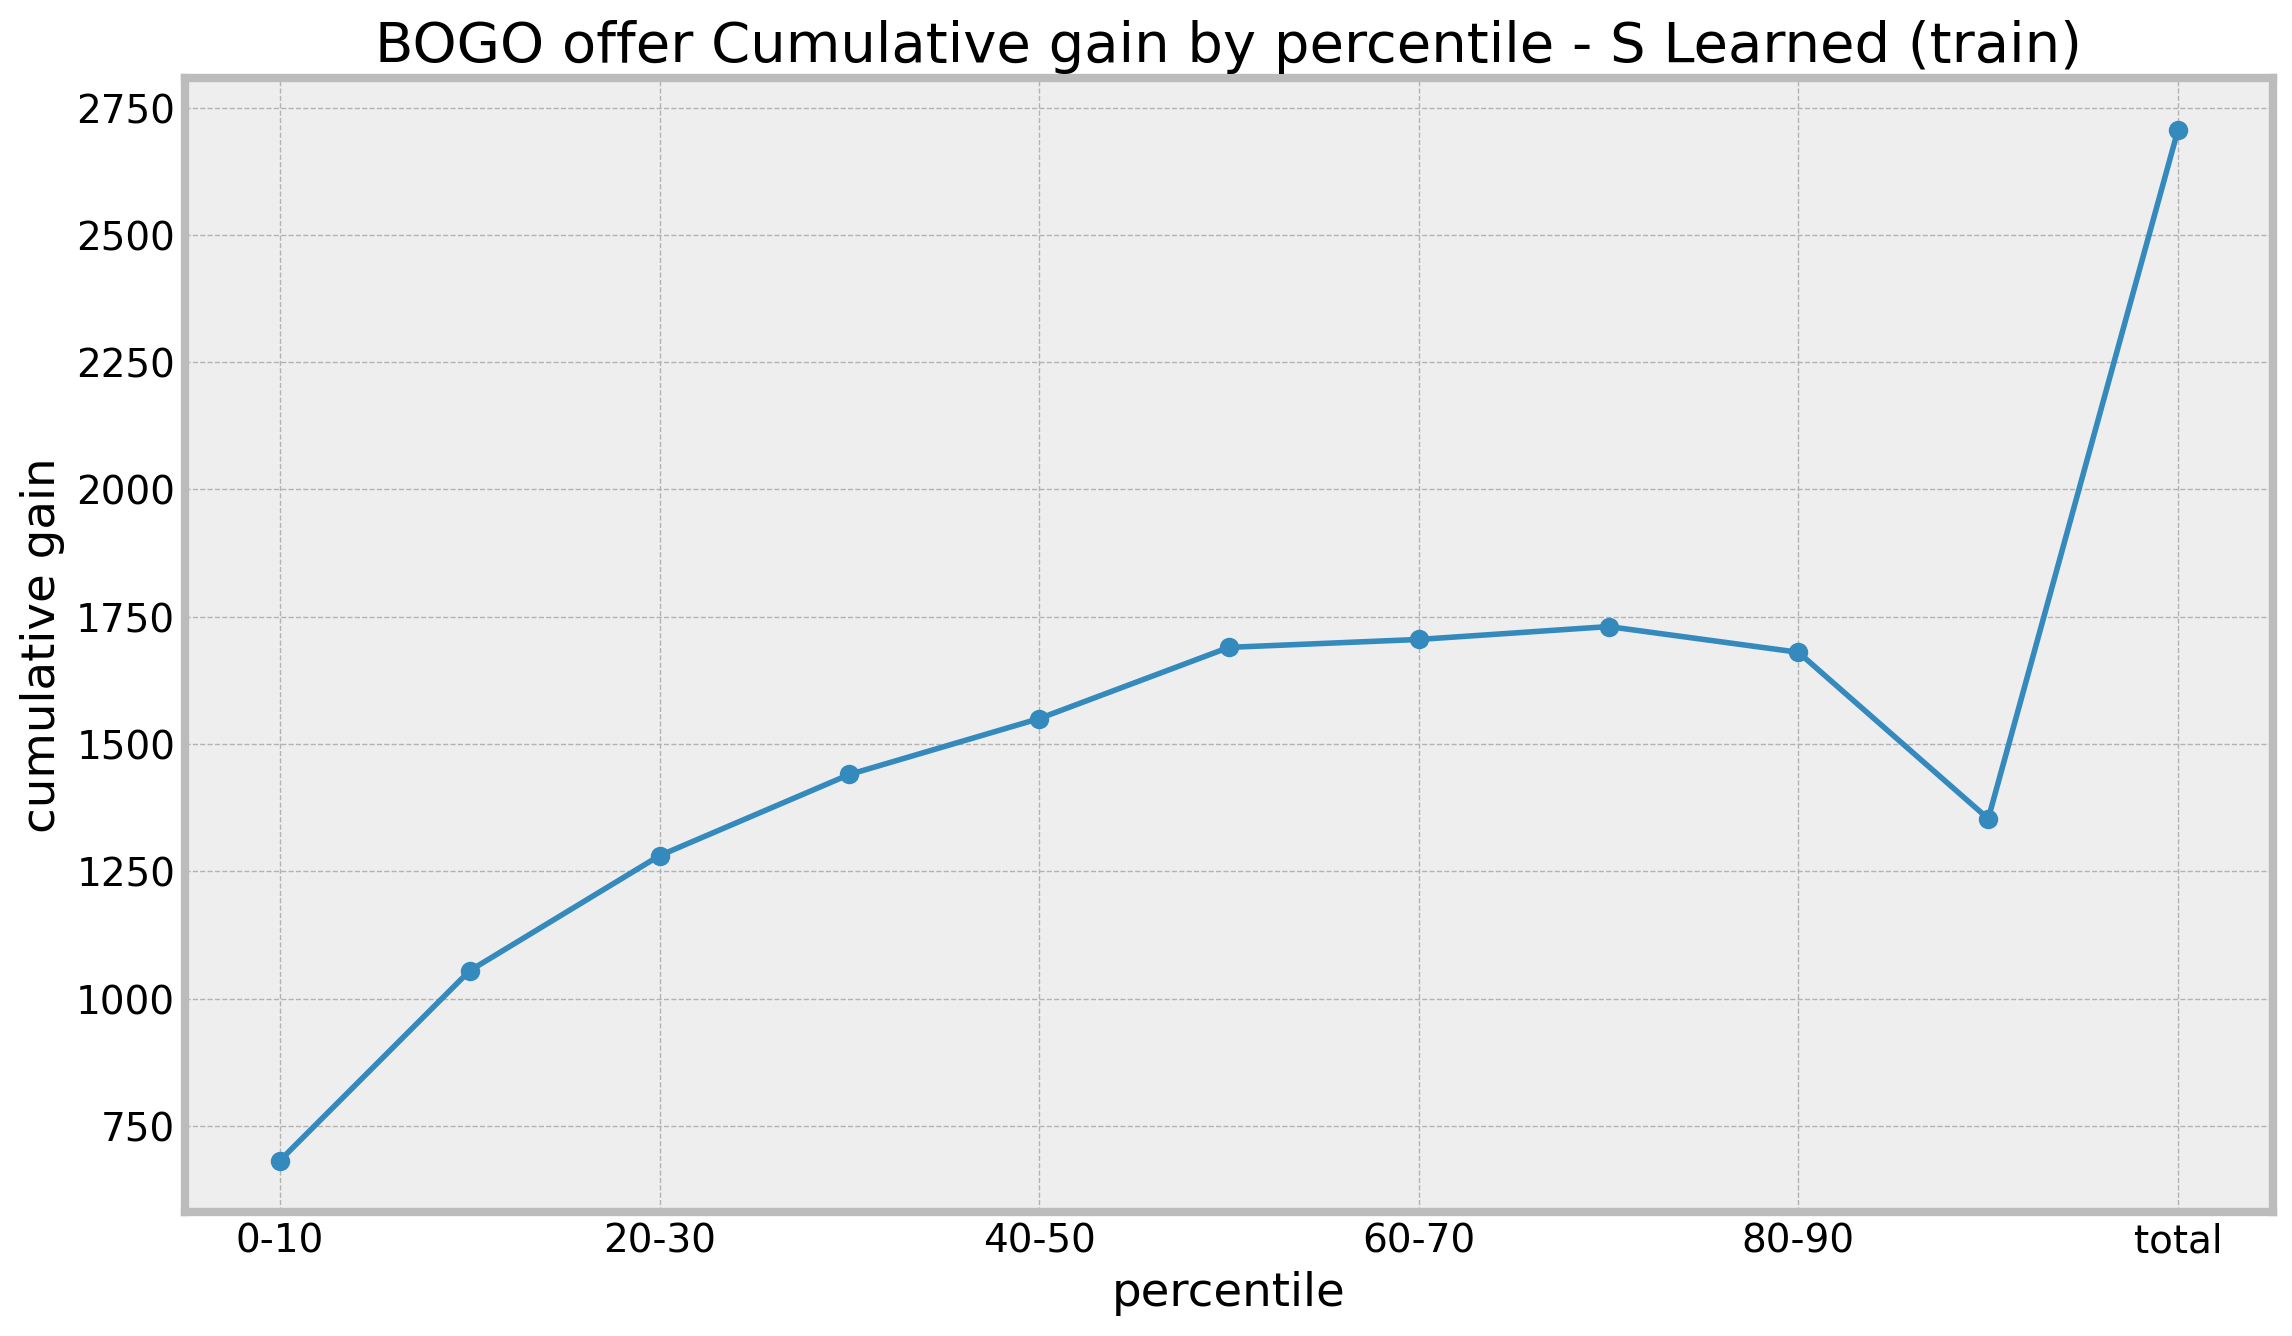

In [78]:
fig, ax = plt.subplots()

bogo_uplift_by_percentile_df \
  .pipe(compute_response_absolutes) \
  .pipe(compute_cumulative_response_rates) \
  .pipe(compute_cumulative_gain) \
  .plot(y="cum_gain", kind="line", marker="o", ax=ax)
ax.legend().remove()
ax.set(
    title="BOGO offer Cumulative gain by percentile - S Learned (train)",
    ylabel="cumulative gain"
);